# Premier League Engine: One vs Rest (OVR) Binary Classification for Loss Model

In [1]:
# Importing Dependencies
from epl_metrics import plot_roc_curve, print_classification_report, plot_confusion_matrix, find_optimal_threshold, evaluate_model_performance
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from epl_model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from epl_pipeline import build_pipeline
from epl_datasets import load_data
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import logging
import shutil
import skopt
import yaml

In [2]:
logging.basicConfig(filename = "../Logs/loss_modeling.log", filemode = "w", format = "%(asctime)s - %(levelname)s - %(message)s", level = logging.INFO)
sns.set(font_scale = 1.5, style = "darkgrid", palette = "bright")
warnings.filterwarnings(action = "ignore")
plt.rcParams["figure.figsize"] = (30, 10)
pd.options.display.max_columns = None
np.random.seed(seed = 42)

Let"s load the yaml file, extract the dependent variable and assign it to a global variable.

In [3]:
# Loading the yaml file
with open(file = "../Configuration/config.yml") as yaml_file:
    config = yaml.safe_load(stream = yaml_file)

# Loading the dependent variable for Loss modeling
TARGET = config.get("target").get("loss_model")

Let"s call the function to load the dataset.

In [4]:
# Calling the function to load the dataset
df = load_data()

# Logging information to the log file
logging.info(msg = "Data has been loaded")

# Displaying the first five records of the dataset
df.head()

season  match_week match_date  month  day  weekday          referee  \
0  2006/07           1 2006-08-19      8   19        6        Phil Dowd   
1  2006/07           1 2006-08-19      8   19        6      Mark Halsey   
2  2006/07           1 2006-08-19      8   19        6       Alan Wiley   
3  2006/07           1 2006-08-19      8   19        6  Martin Atkinson   
4  2006/07           1 2006-08-19      8   19        6     Peter Walton   

    home_team      away_team                       stadium  attendance  \
0      Bolton          Spurs  University of Bolton Stadium     22899.0   
1     Reading  Middlesbrough              Madejski Stadium     23802.0   
2  Portsmouth      Blackburn                  Fratton Park     19502.0   
3   Newcastle          Wigan           Sports Direct Arena     52227.0   
4     Everton        Watford                 Goodison Park     39691.0   

  derby_name               club_tier_h               club_tier_a  h_position  \
0   No Derby                Small Club  Considered as a Big Club           4   
1   No Derby                Small Club                Small Club          15   
2   No Derby  Considered as a Big Club  Considered as a Big Club          14   
3   No Derby  Considered as a Big Club                Small Club          13   
4   No Derby                  Big Club                Small Club           7   

   a_position         streak_h         streak_a  goals_h  goals_a  \
0          17  Out of Interval  Out of Interval        2        0   
1          12  Out of Interval  Out of Interval        3        2   
2           3  Out of Interval  Out of Interval        3        0   
3          20  Out of Interval  Out of Interval        2        1   
4          18  Out of Interval  Out of Interval        2        1   

   possession_h  possession_a  shots_on_target_h  shots_on_target_a  shots_h  \
0          37.8          62.2                  4                  2       13   
1          52.1          47.9                  8                  7       14   
2          44.3          55.7                 11                  3       21   
3          55.3          44.7                  5                  4        8   
4          47.0          53.0                  2                  7        8   

   shots_a  touches_h  touches_a  passes_h  passes_a  tackles_h  tackles_a  \
0       10        411        591       243       427         28         17   
1       11        515        441       335       328         23         28   
2        8        415        527       279       327         23         19   
3       13        519        448       352       278         27         33   
4       13        460        493       288       321         17         24   

   clearances_h  clearances_a  corners_h  corners_a  offsides_h  offsides_a  \
0            20            43          6          3           0           0   
1             9            18          8          2           0           1   
2            15            28          6          2           5           0   
3            15            16          4         11           6           3   
4            61            32          0          6           5           1   

   yellow_cards_h  yellow_cards_a  red_cards_h  red_cards_a  fouls_conceded_h  \
0               3               1            0            0                22   
1               1               3            0            0                 7   
2               2               0            0            1                22   
3               1               2            0            0                18   
4               2               2            0            0                12   

   fouls_conceded_a result_h result_a  points_h  points_a  n_epls_h  n_epls_a  \
0                22      Win   Defeat         3         0         0         2   
1                16      Win   Defeat         3         0         0         0   
2                17      Win   Defeat         3         0

Let"s call the function to split the data into a train and a test set.

In [5]:
# Calling the function to split the data into a train and a test set
X_train, X_test, y_train, y_test = train_test_split(data_frame = df, 
                                                    target = TARGET)

# Logging information to the log file
logging.info(msg = "Train and test sets have been created")

# Displaying the shapes of features and labels for train & test set
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4560, 326), (4560,), (1520, 326), (1520,))

Let"s visualize the class ratio for train and test sets.

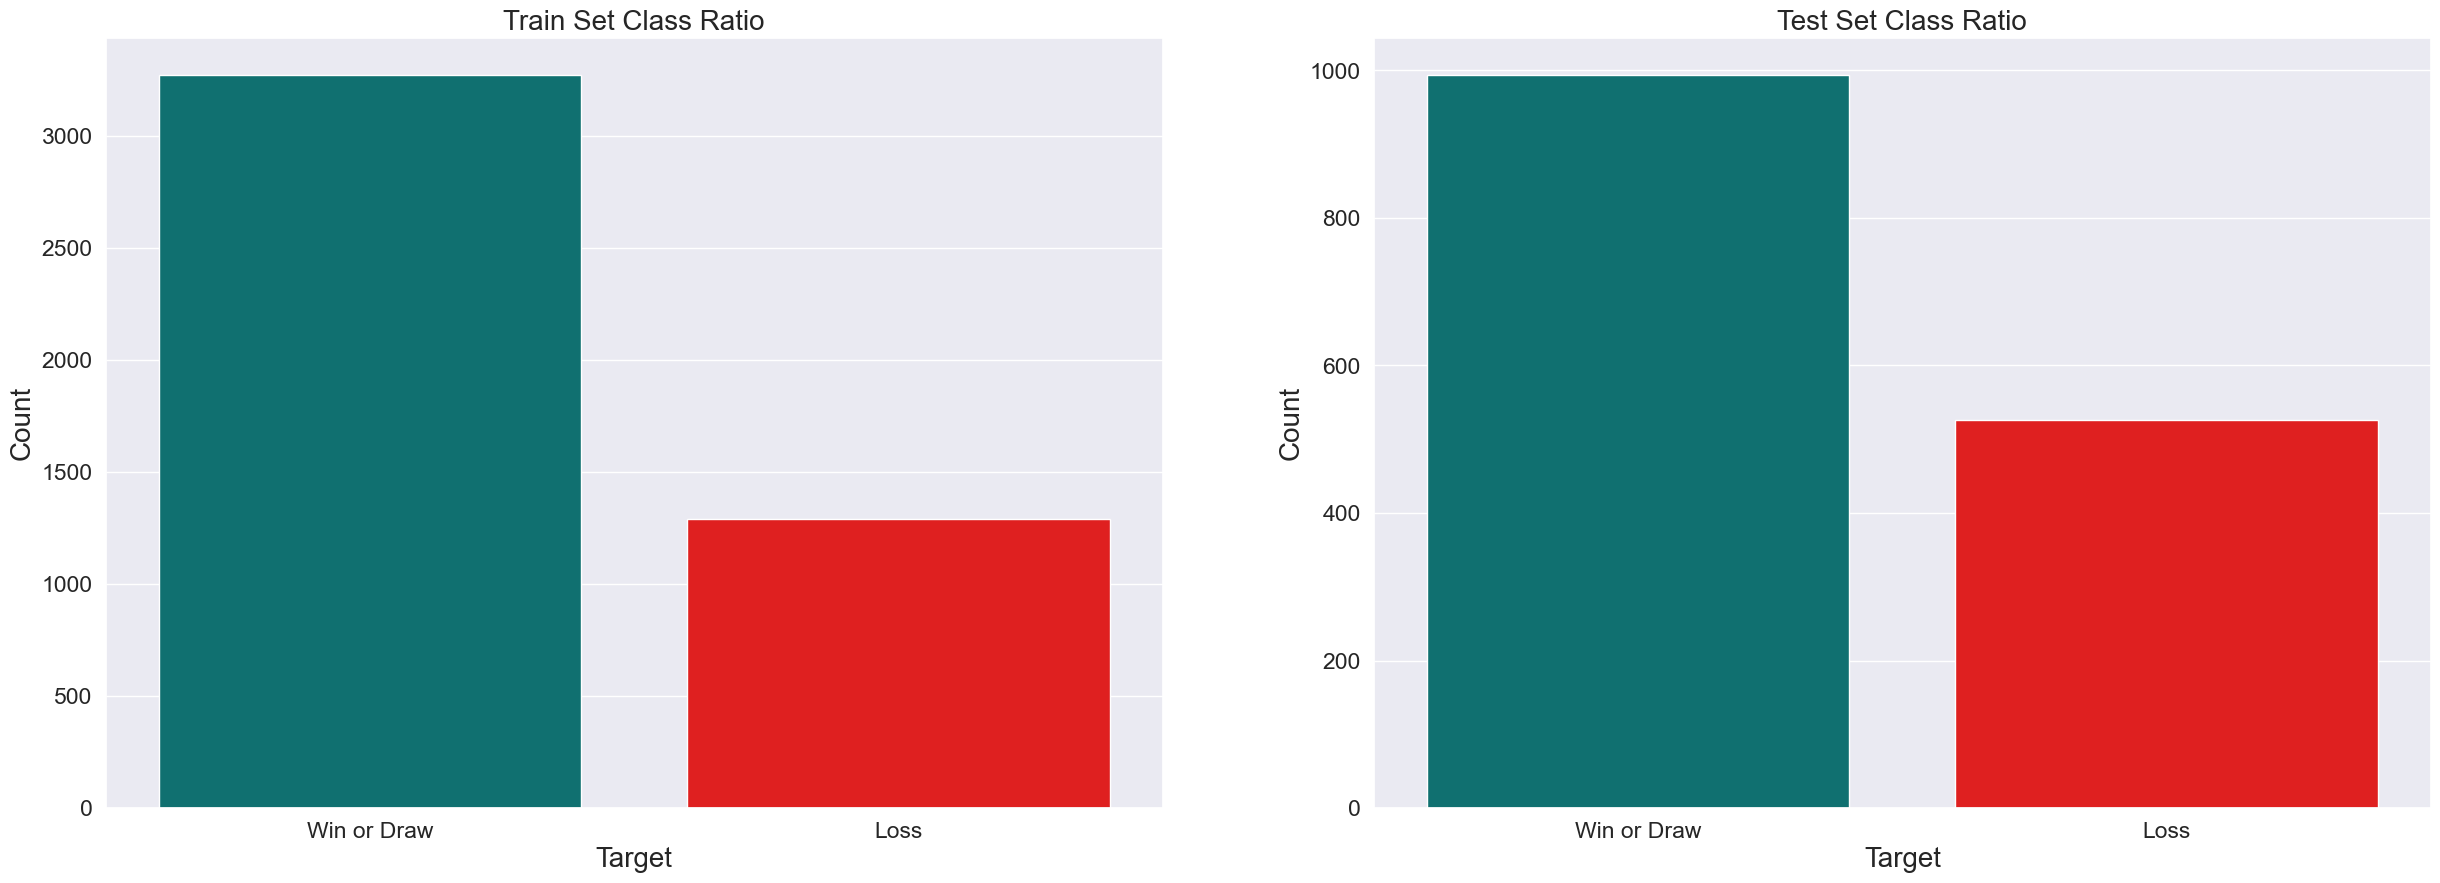

In [6]:
# Visualizing the class ratio for train set
plt.subplot(1, 2, 1)
sns.countplot(x = y_train, palette = ["teal", "red"])
plt.title(label = "Train Set Class Ratio", fontsize = 20)
plt.xlabel(xlabel = "Target", fontsize = 20)
plt.ylabel(ylabel = "Count", fontsize = 20)
plt.xticks(ticks = [0, 1], labels = ["Win or Draw", "Loss"])

# Visualizing the class ratio for test set
plt.subplot(1, 2, 2)
sns.countplot(x = y_test, palette = ["teal", "red"])
plt.title(label = "Test Set Class Ratio", fontsize = 20)
plt.xlabel(xlabel = "Target", fontsize = 20)
plt.ylabel(ylabel = "Count", fontsize = 20)
plt.xticks(ticks = [0, 1], labels = ["Win or Draw", "Loss"])
plt.show()

***
## Modeling
#### Baseline

Let"s call the function to build a baseline classifier pipeline.

In [7]:
# Calling the function to build a classifier pipeline
baseline_model = build_pipeline(classifier = DummyClassifier(strategy = "uniform", 
                                                             random_state = 42),
                                train_features = X_train,
                                train_labels = y_train)

# Logging information to the log file
logging.info(msg = "Baseline model has been built")

# Displaying the architecture of a pipeline
baseline_model

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_goals_scored_h',
                                                   'total_goals_scored_a',
                                                   'total_avg_goals_scored_h',
                                                   'total_avg_goals_scored_a',
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('classifier',
                 DummyClassifier(random_state=42, strategy='uniform'))])

Let"s call the function to print out the classification report.

In [8]:
# Calling the function to print out the classification report
print_classification_report(model = baseline_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Baseline")

Classification Report Summary for Baseline Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.00      0.00      0.00      3272
        Loss       0.28      1.00      0.44      1288

    accuracy                           0.28      4560
   macro avg       0.14      0.50      0.22      4560
weighted avg       0.08      0.28      0.12      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.00      0.00      0.00       994
        Loss       0.35      1.00      0.51       526

    accuracy                           0.35      1520
   macro avg       0.17      0.50      0.26      1520
weighted avg       0.12      0.35      0.18      1520



Let"s call the function to plot **Receiver Operating Characteristics (ROC)** curve.

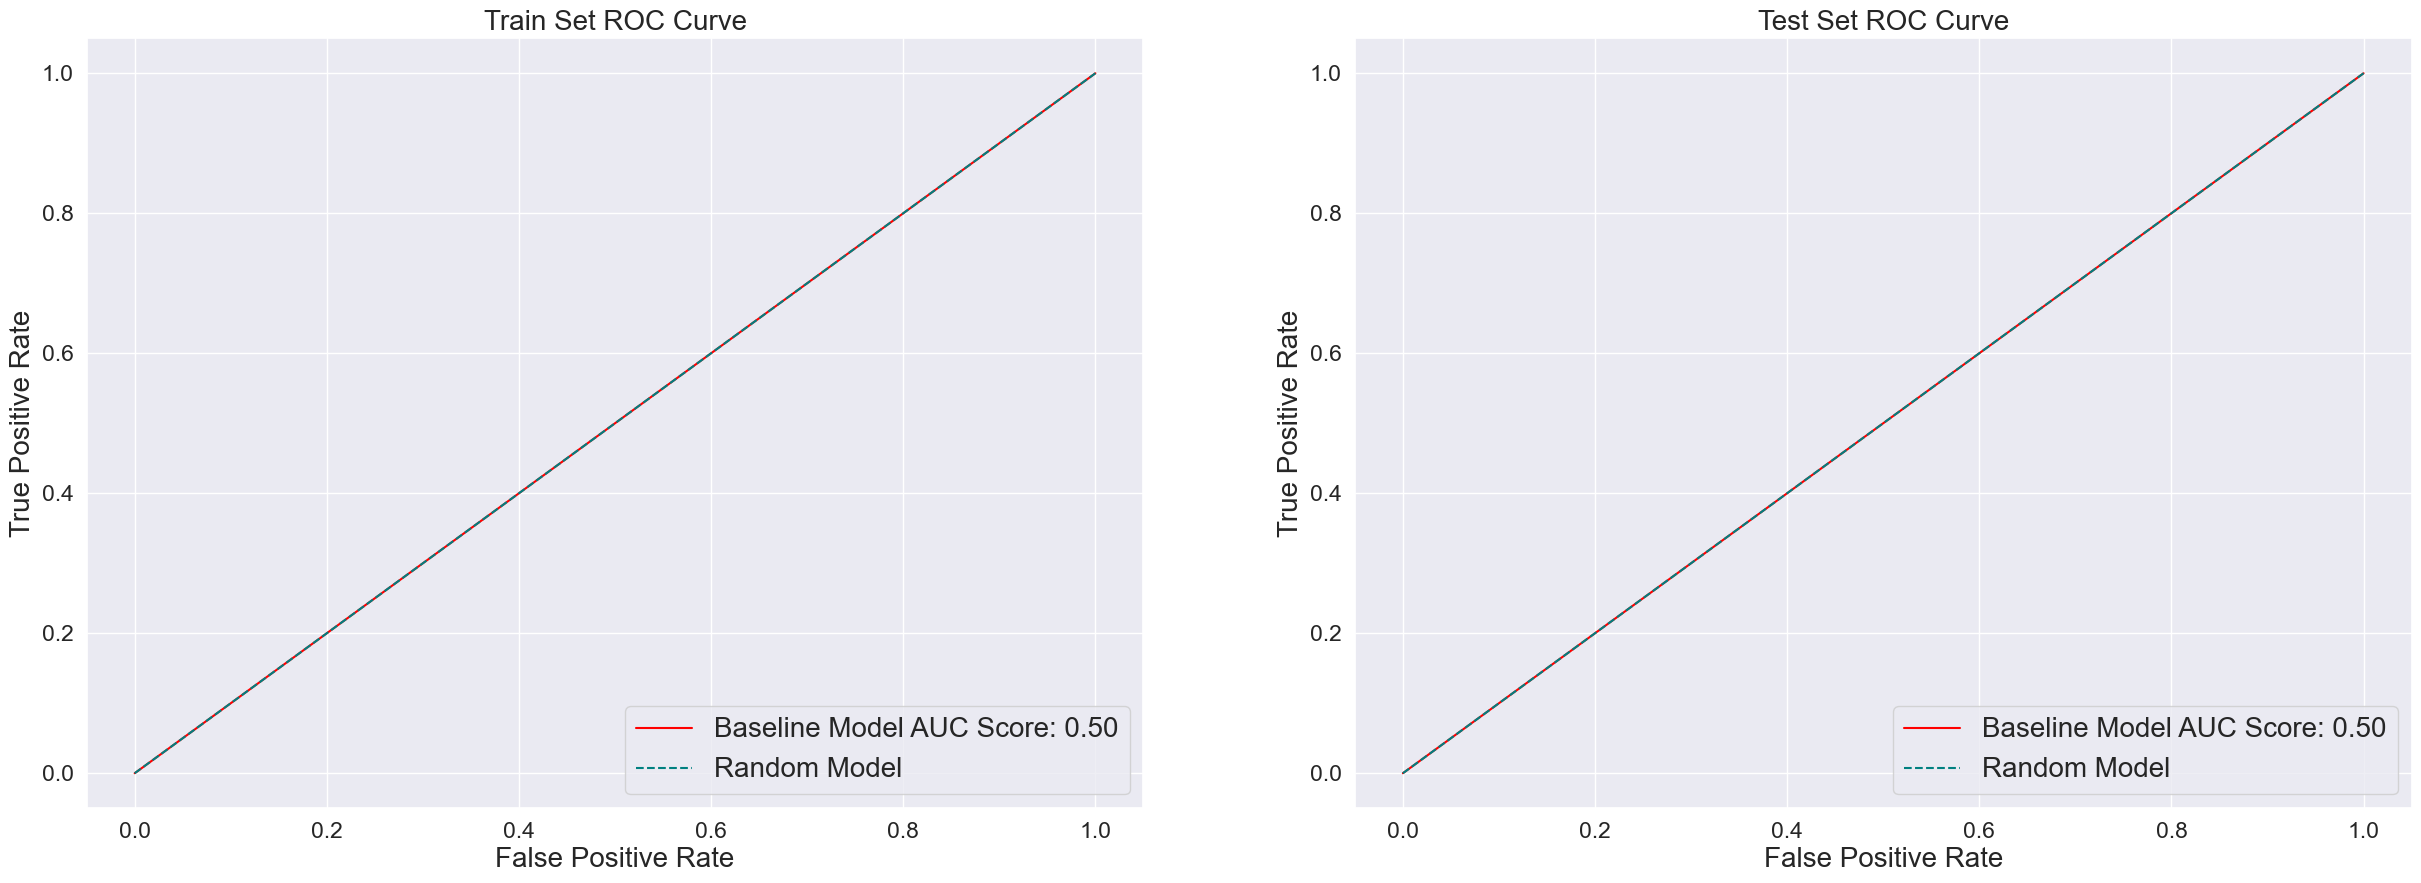

In [9]:
# Calling the function to plot ROC curve
plot_roc_curve(model = baseline_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Baseline")

Let"s call the function to plot a confusion matrix.

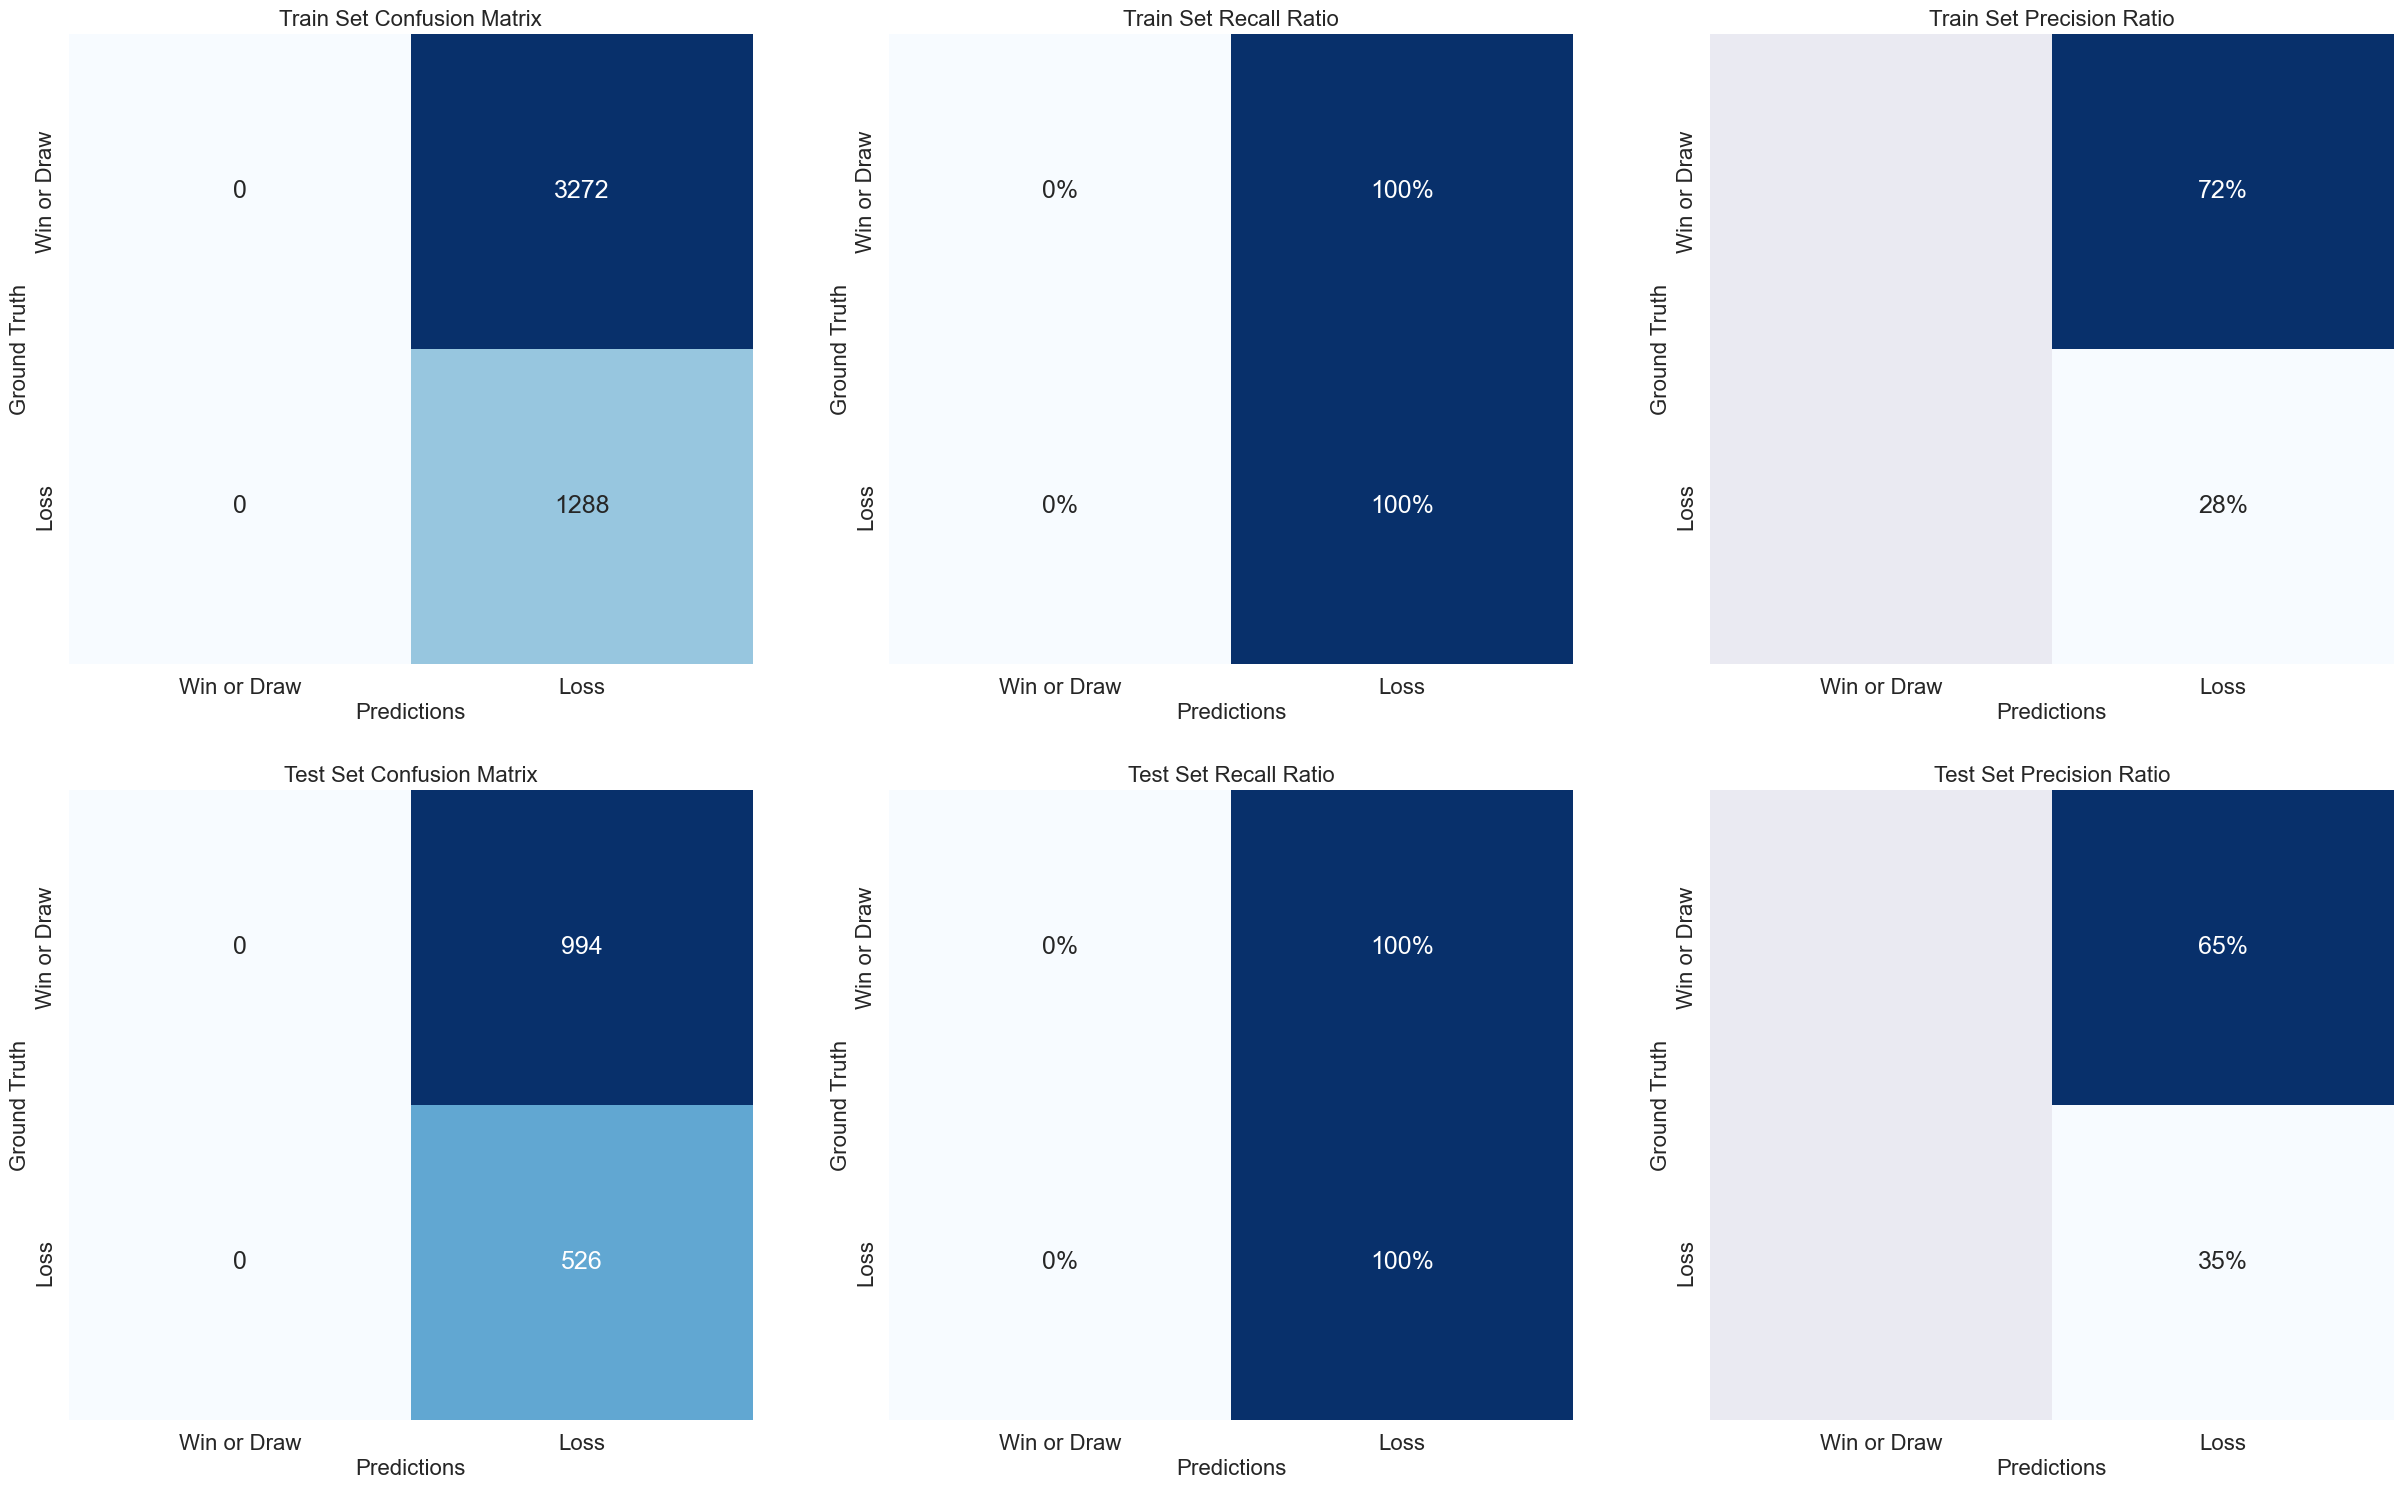

In [10]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = baseline_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      class_labels = ["Win or Draw", "Loss"])

Let"s call the function to evaluate the performance of a classifier.

In [11]:
# Calling the function to evaluate the performance of the classifier
baseline_model_summary_df = evaluate_model_performance(model = baseline_model, 
                                                       train_features = X_train, 
                                                       train_labels = y_train, 
                                                       test_features = X_test, 
                                                       test_labels = y_test,
                                                       algorithm_name = "Baseline")
# Displaying the model performance
baseline_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Baseline        0.5       0.5                      0.5   

          Test Balanced Accuracy  Accuracy  Precision  Recall    F1  MCC  \
Baseline                     0.5      0.35       0.35     1.0  0.52  NaN   

          Brier Loss  N Features  \
Baseline        0.25         305   

                                                   Pipeline  
Baseline  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
#### Gaussian Naïve Bayes

Let"s call the function to build a classifier pipeline using **Gaussian Naïve Bayes** algorithm.

In [12]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a list of feature scaler instances
feature_scalers = [RobustScaler(), MinMaxScaler(), MaxAbsScaler(), StandardScaler(), PowerTransformer(), QuantileTransformer()]

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_transformer__numeric_pipeline__feature_scaler"] = feature_scalers
search_spaces["feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 91, 10)))

# Calling the function to build a classifier pipeline
gnb_model = build_pipeline(classifier = GaussianNB(),
                           apply_feature_scaling = True,
                           feature_scaler_type = "quantile",
                           apply_feature_selection = True,
                           feature_selection_type = "mutual_info",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           train_features = X_train,
                           train_labels = y_train,
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "Gaussian Naïve Bayes model has been built")

# Displaying the architecture of a pipeline
gnb_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_goals_scored_a',
                                                   'total_avg_goals_scored_h',
                                                   'total_avg_goals_scored_a',
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector', SelectPercentile(percentile=30)),
                ('classifier', GaussianNB())])

Let"s call the function to identify the best probability thresholds for train and test set.

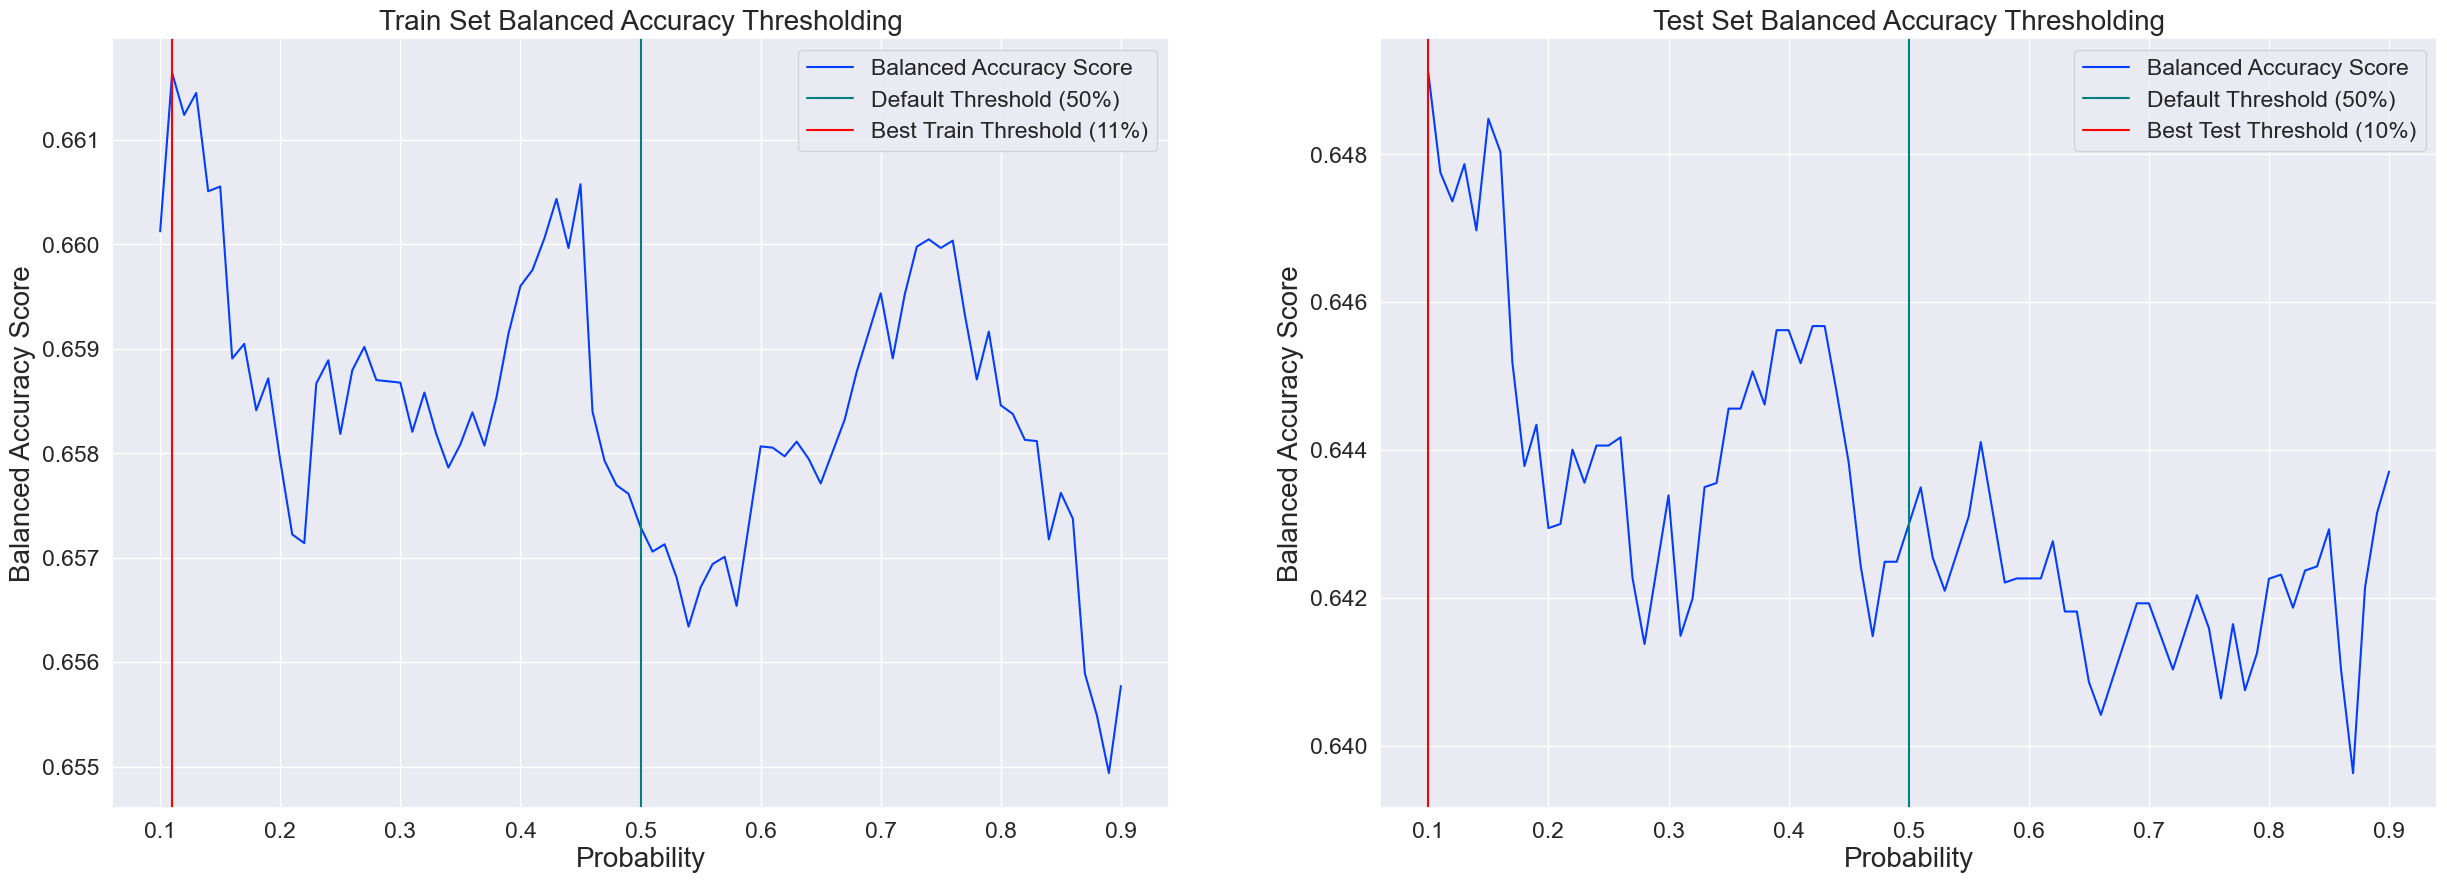

In [13]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = gnb_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

Let"s call the function to print out the classification report.

In [14]:
# Calling the function to print out the classification report
print_classification_report(model = gnb_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Gaussian Naïve Bayes")

Classification Report Summary for Gaussian Naïve Bayes Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.83      0.66      0.74      3272
        Loss       0.44      0.66      0.52      1288

    accuracy                           0.66      4560
   macro avg       0.63      0.66      0.63      4560
weighted avg       0.72      0.66      0.68      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.78      0.63      0.70       994
        Loss       0.49      0.67      0.56       526

    accuracy                           0.64      1520
   macro avg       0.64      0.65      0.63      1520
weighted avg       0.68      0.64      0.65      1520



Let"s call the function to plot **Receiver Operating Characteristics (ROC)** curve.

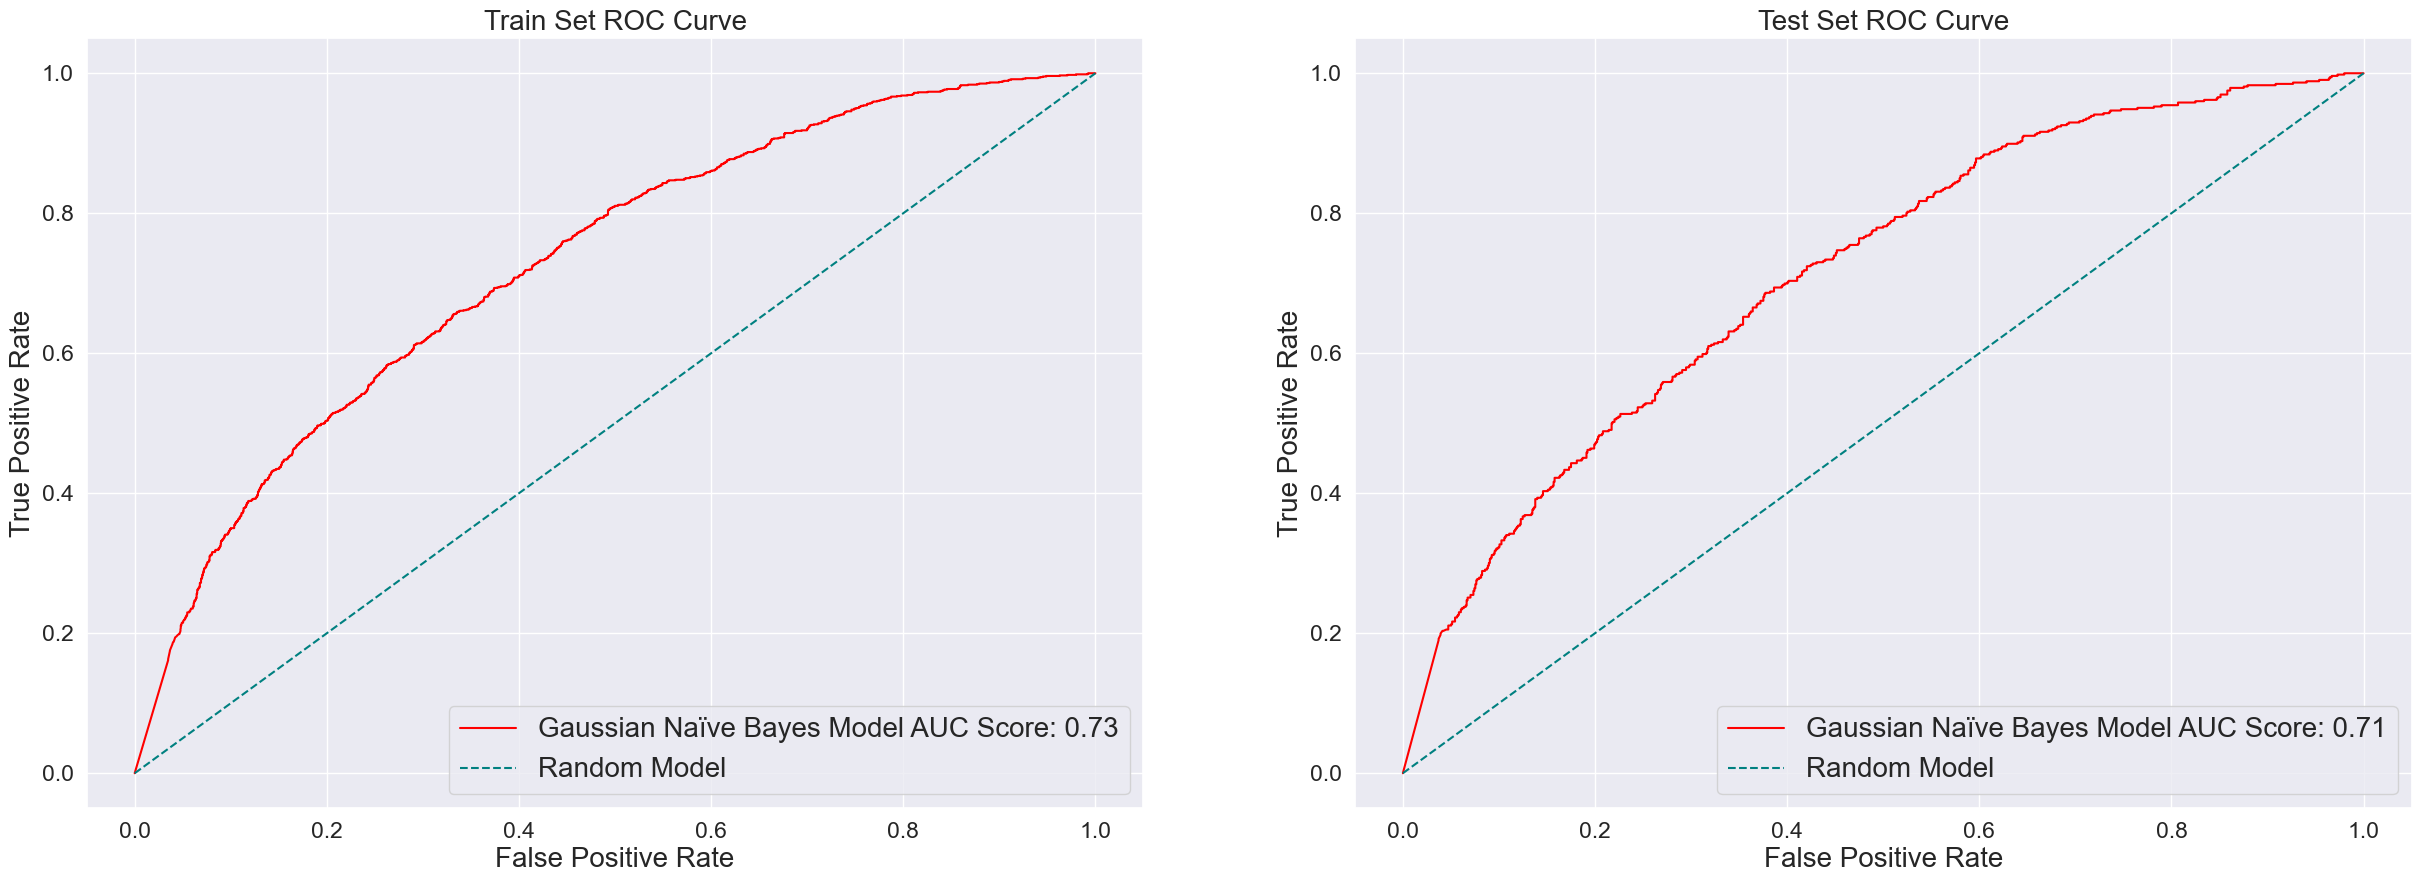

In [15]:
# Calling the function to plot ROC curve
plot_roc_curve(model = gnb_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Gaussian Naïve Bayes")

Let"s call the function to plot a confusion matrix.

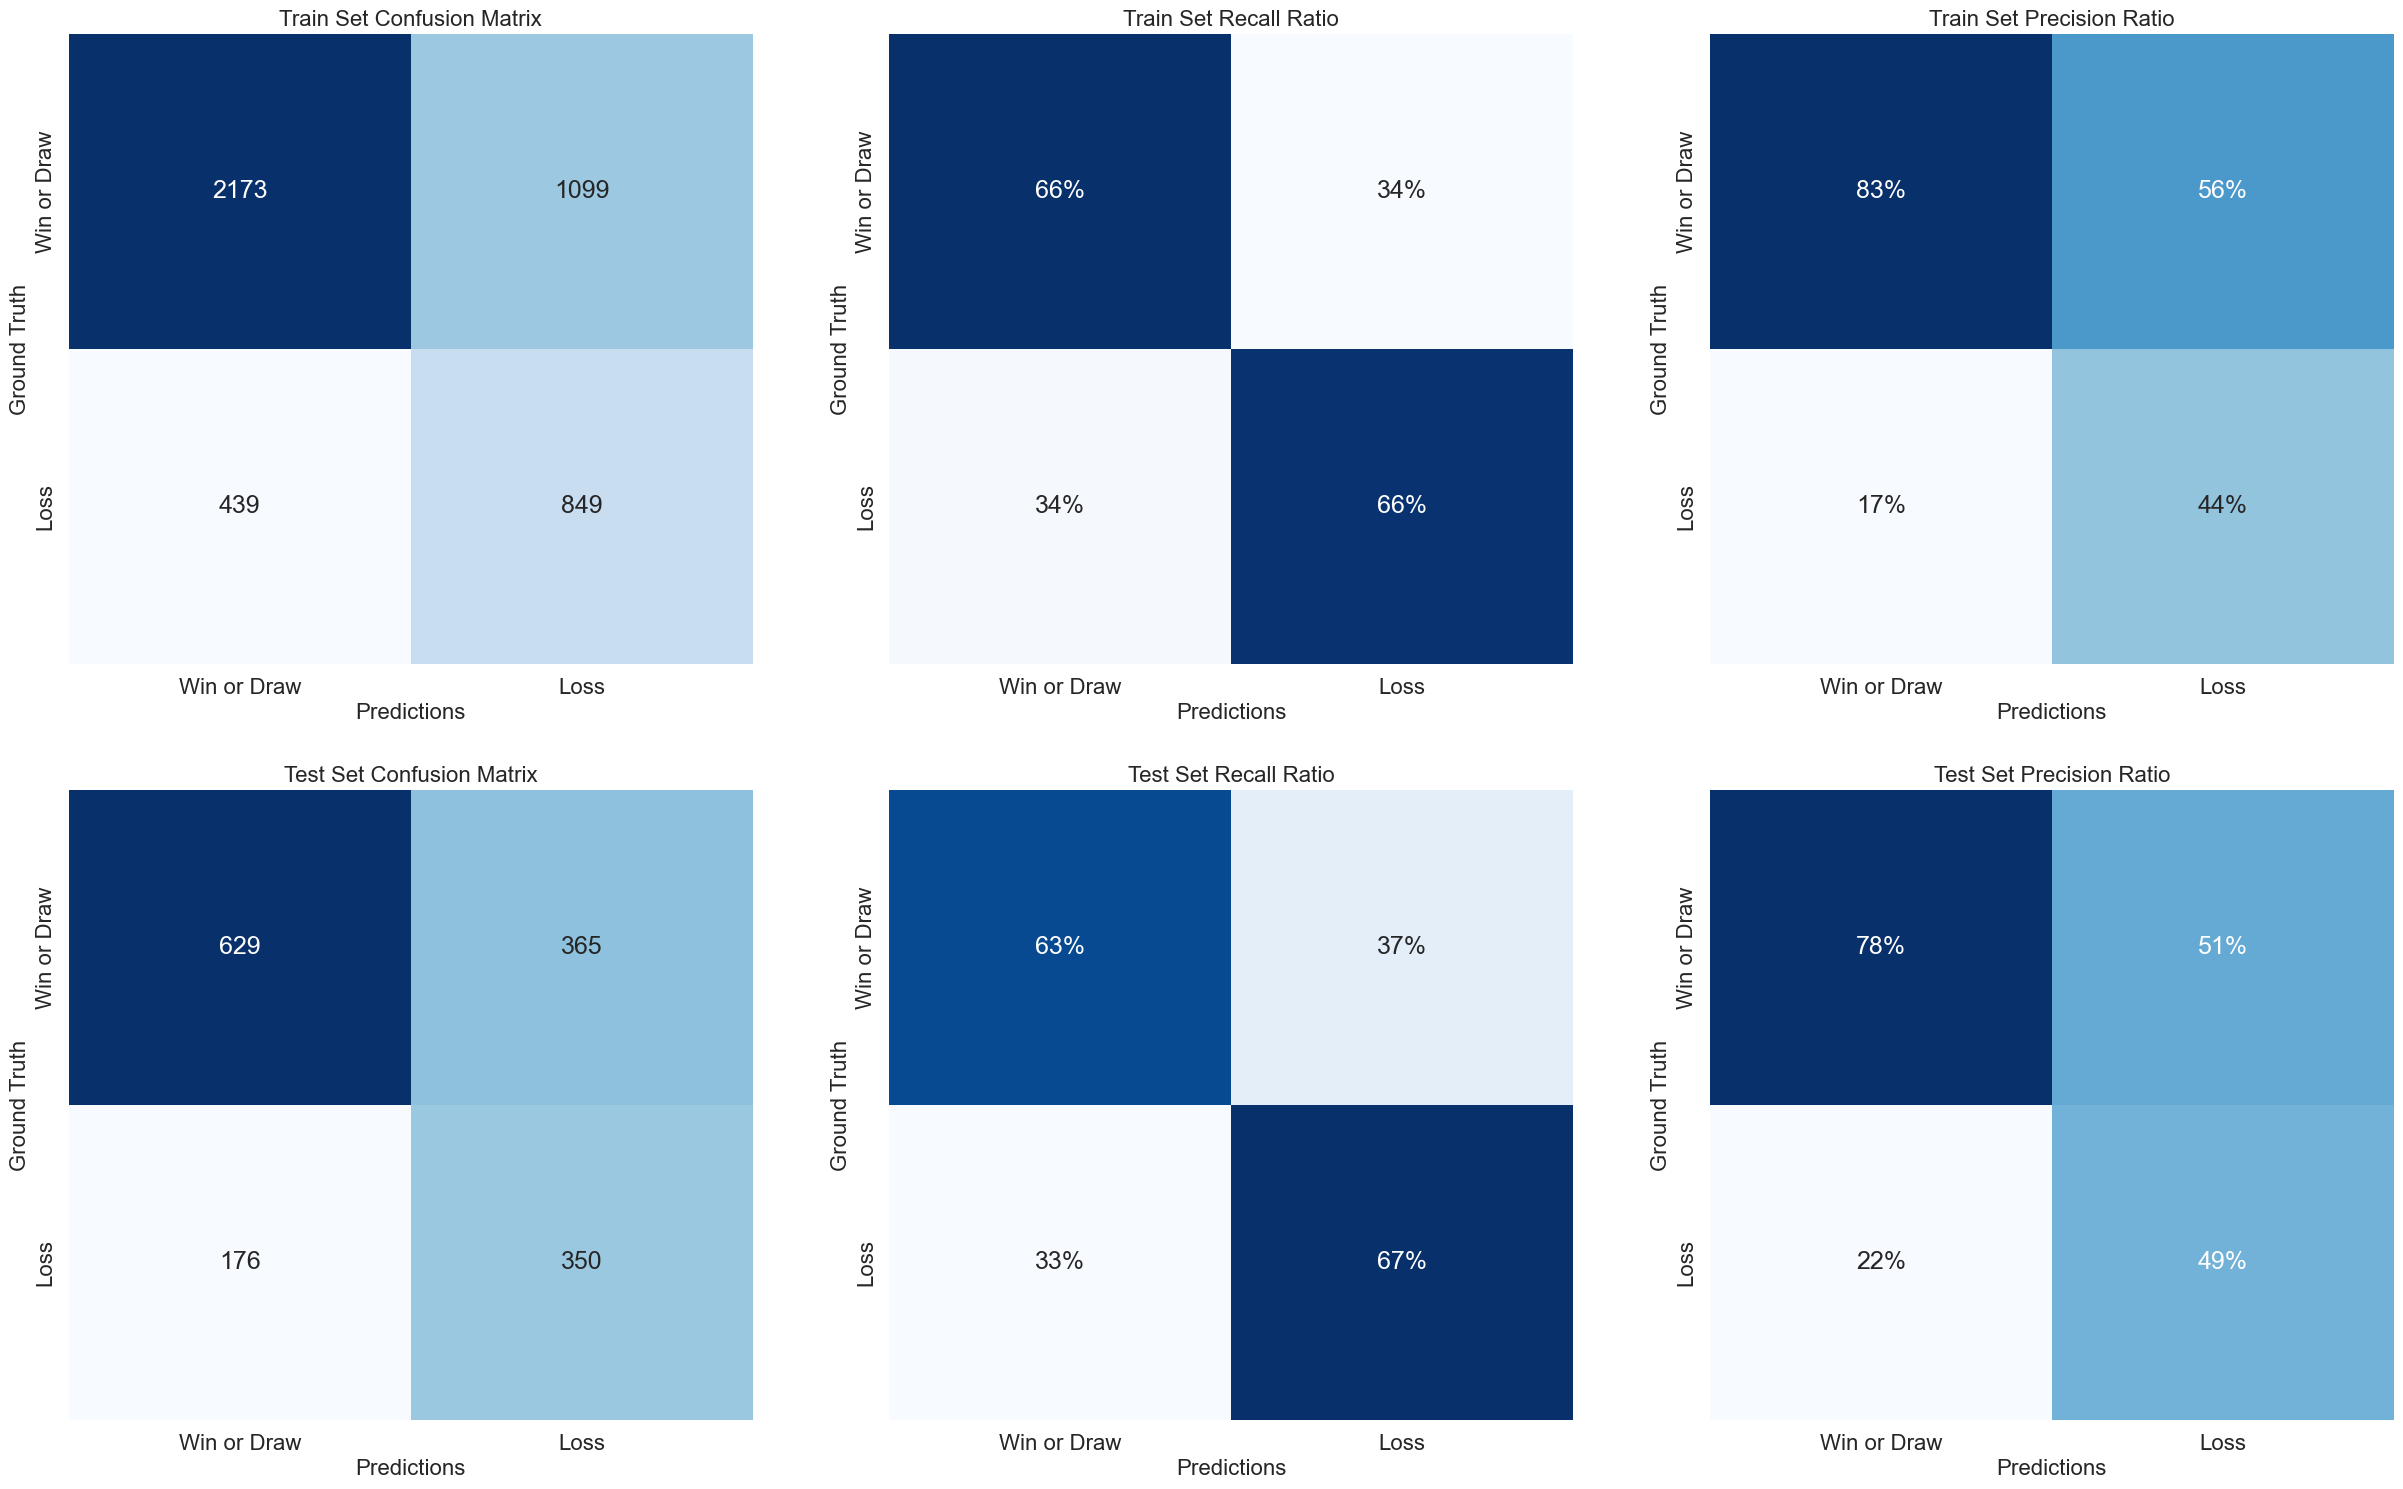

In [16]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = gnb_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

Let"s call the function to evaluate the performance of a classifier.

In [17]:
# Calling the function to evaluate the performance of the classifier
gnb_model_summary_df = evaluate_model_performance(model = gnb_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "Gaussian Naïve Bayes",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the model performance
gnb_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Gaussian Naïve Bayes       0.73      0.71                     0.66   

                      Test Balanced Accuracy  Accuracy  Precision  Recall  \
Gaussian Naïve Bayes                    0.65      0.64       0.49    0.67   

                        F1   MCC  Brier Loss  N Features  \
Gaussian Naïve Bayes  0.57  0.28        0.32          92   

                                                               Pipeline  
Gaussian Naïve Bayes  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Logistic Regression

In [18]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_transformer__numeric_pipeline__feature_scaler"] = feature_scalers
search_spaces["feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 91, 10)))
search_spaces["classifier__C"] = skopt.space.Real(low = 1e-6, high = 100, prior = "log-uniform")
search_spaces["classifier__tol"] = skopt.space.Real(low = 1e-6, high = 100, prior = "log-uniform")

# Building a classifier
lr_model = build_pipeline(classifier = LogisticRegression(solver = "liblinear", random_state = 42), 
                          apply_feature_scaling = True,
                          feature_scaler_type = "robust",
                          winsorize_outliers = True,
                          apply_feature_selection = True,
                          feature_selection_type = "mutual_info",
                          apply_bayesian_optimization = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          train_features = X_train, 
                          train_labels = y_train,
                          verbosity = 1)

# Logging information to the log file
logging.info(msg = "Logistic Regression model has been built")

# Displaying the architecture of the classifier
lr_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector', SelectPercentile(percentile=90)),
                ('classifier',
                 LogisticRegression(C=0.02131123768063028, random_state=42,
                                    solver='liblinear', tol=1e-06))])

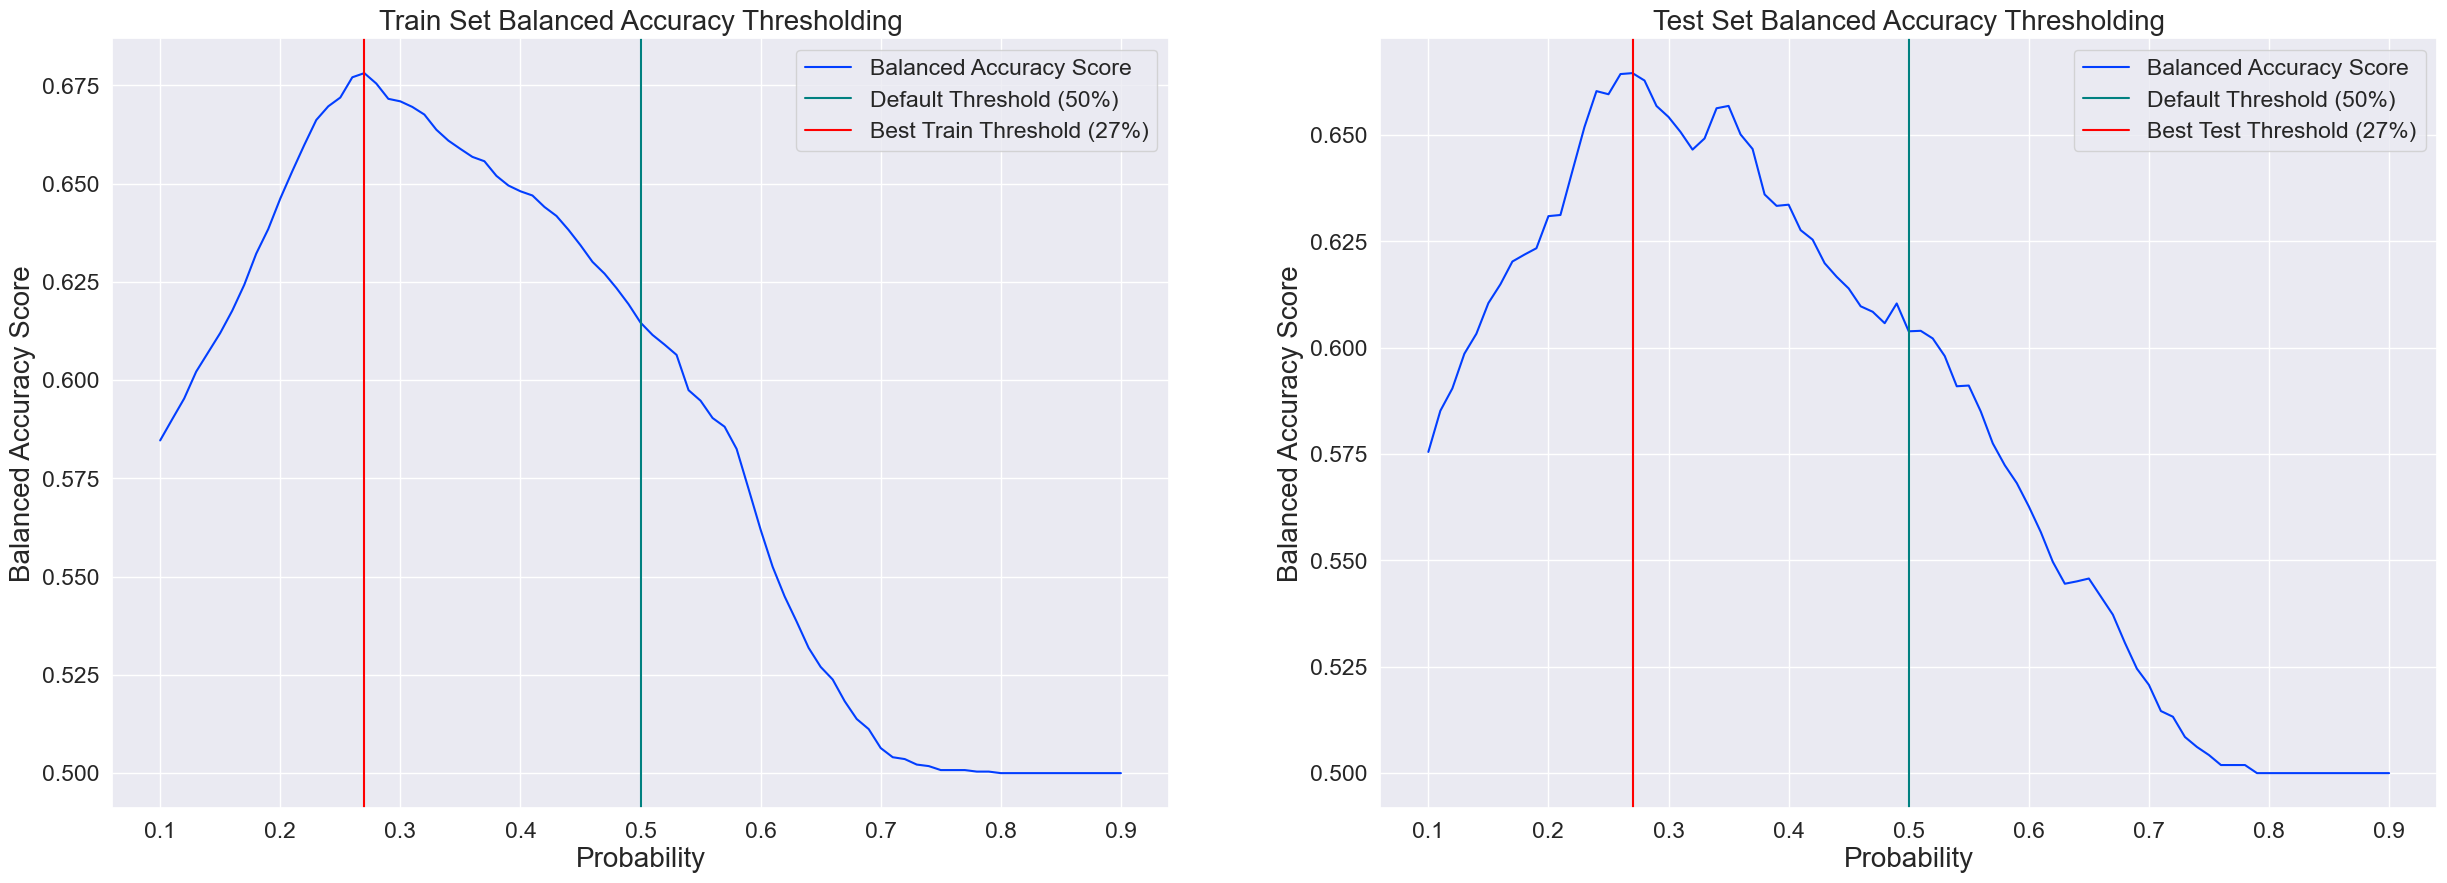

In [19]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = lr_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [20]:
# Calling the function to print out the classification report
print_classification_report(model = lr_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Logistic Regression")

Classification Report Summary for Logistic Regression Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.85      0.65      0.74      3272
        Loss       0.44      0.70      0.54      1288

    accuracy                           0.67      4560
   macro avg       0.65      0.68      0.64      4560
weighted avg       0.73      0.67      0.68      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.81      0.61      0.69       994
        Loss       0.49      0.72      0.59       526

    accuracy                           0.65      1520
   macro avg       0.65      0.66      0.64      1520
weighted avg       0.70      0.65      0.66      1520



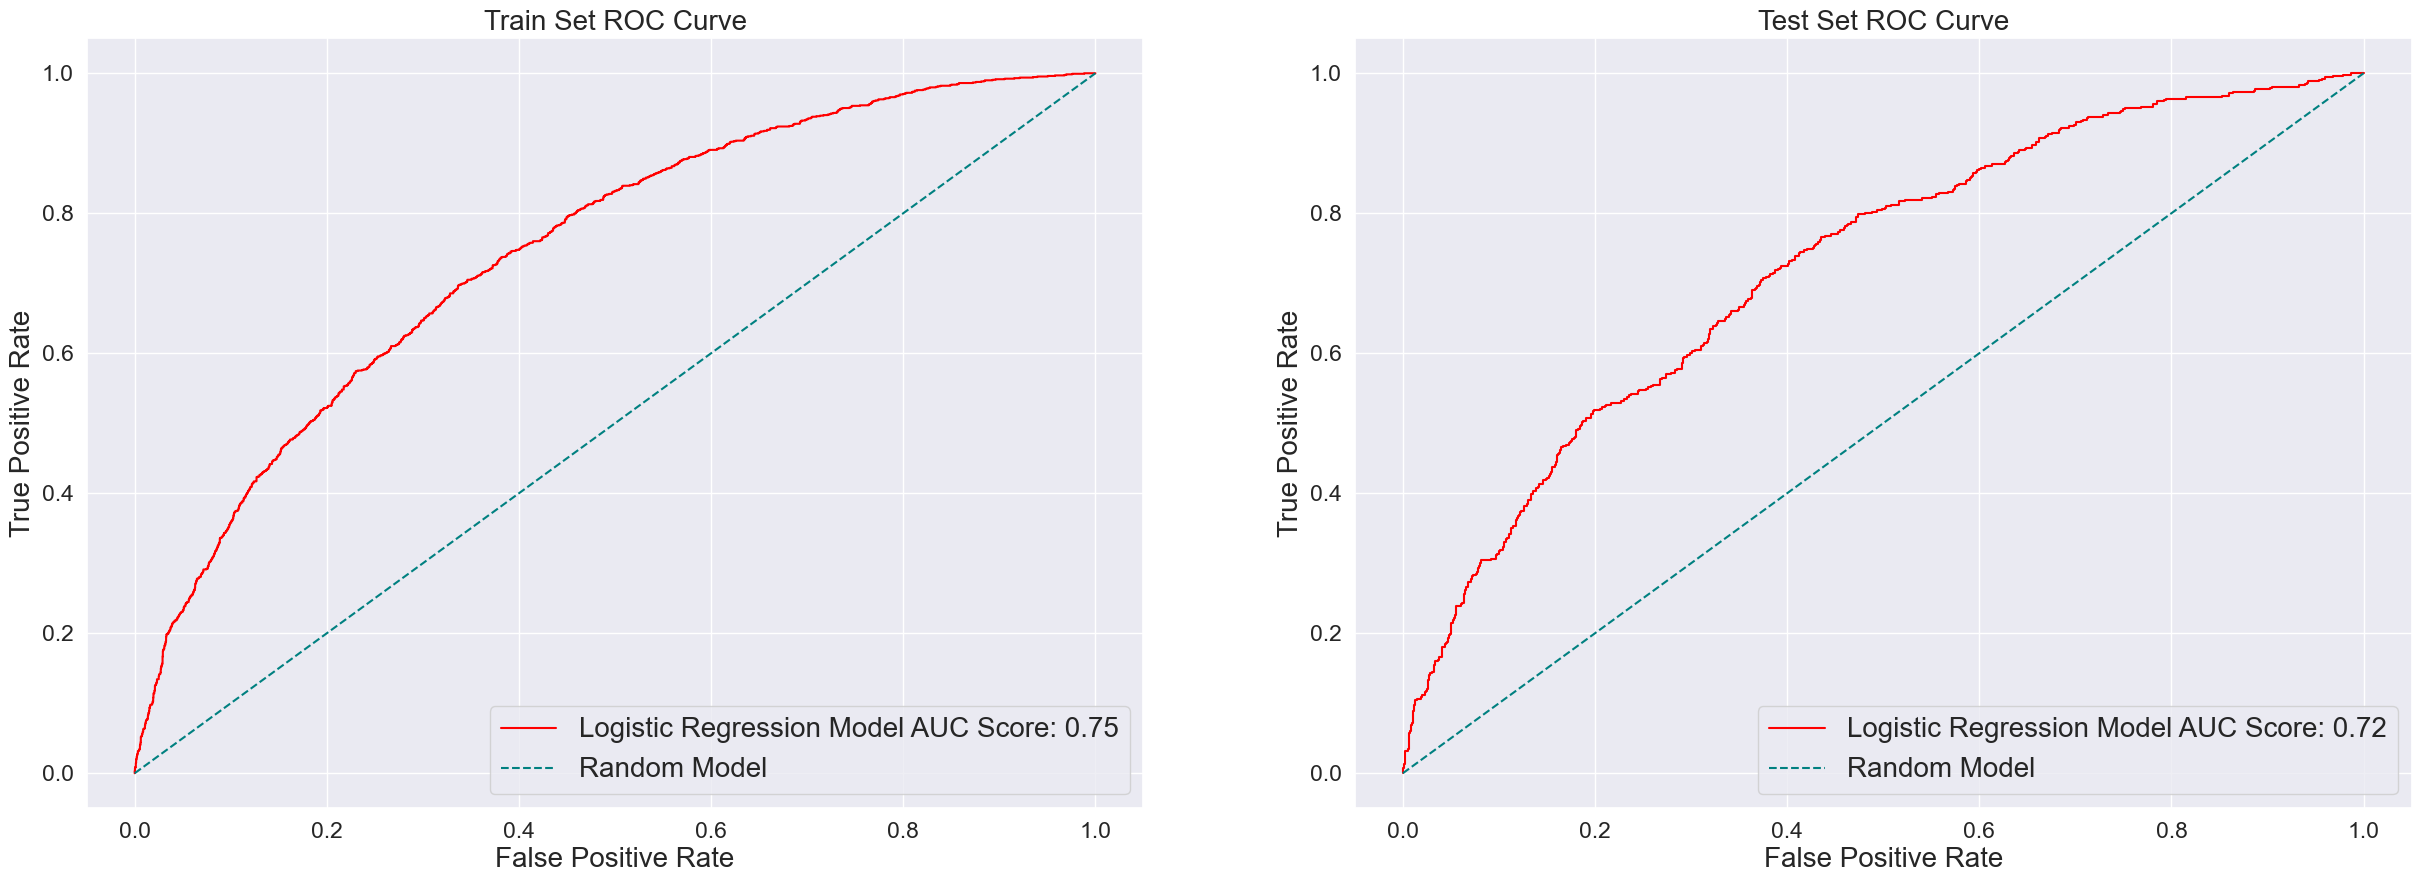

In [21]:
# Calling the function to plot ROC curve
plot_roc_curve(model = lr_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Logistic Regression")

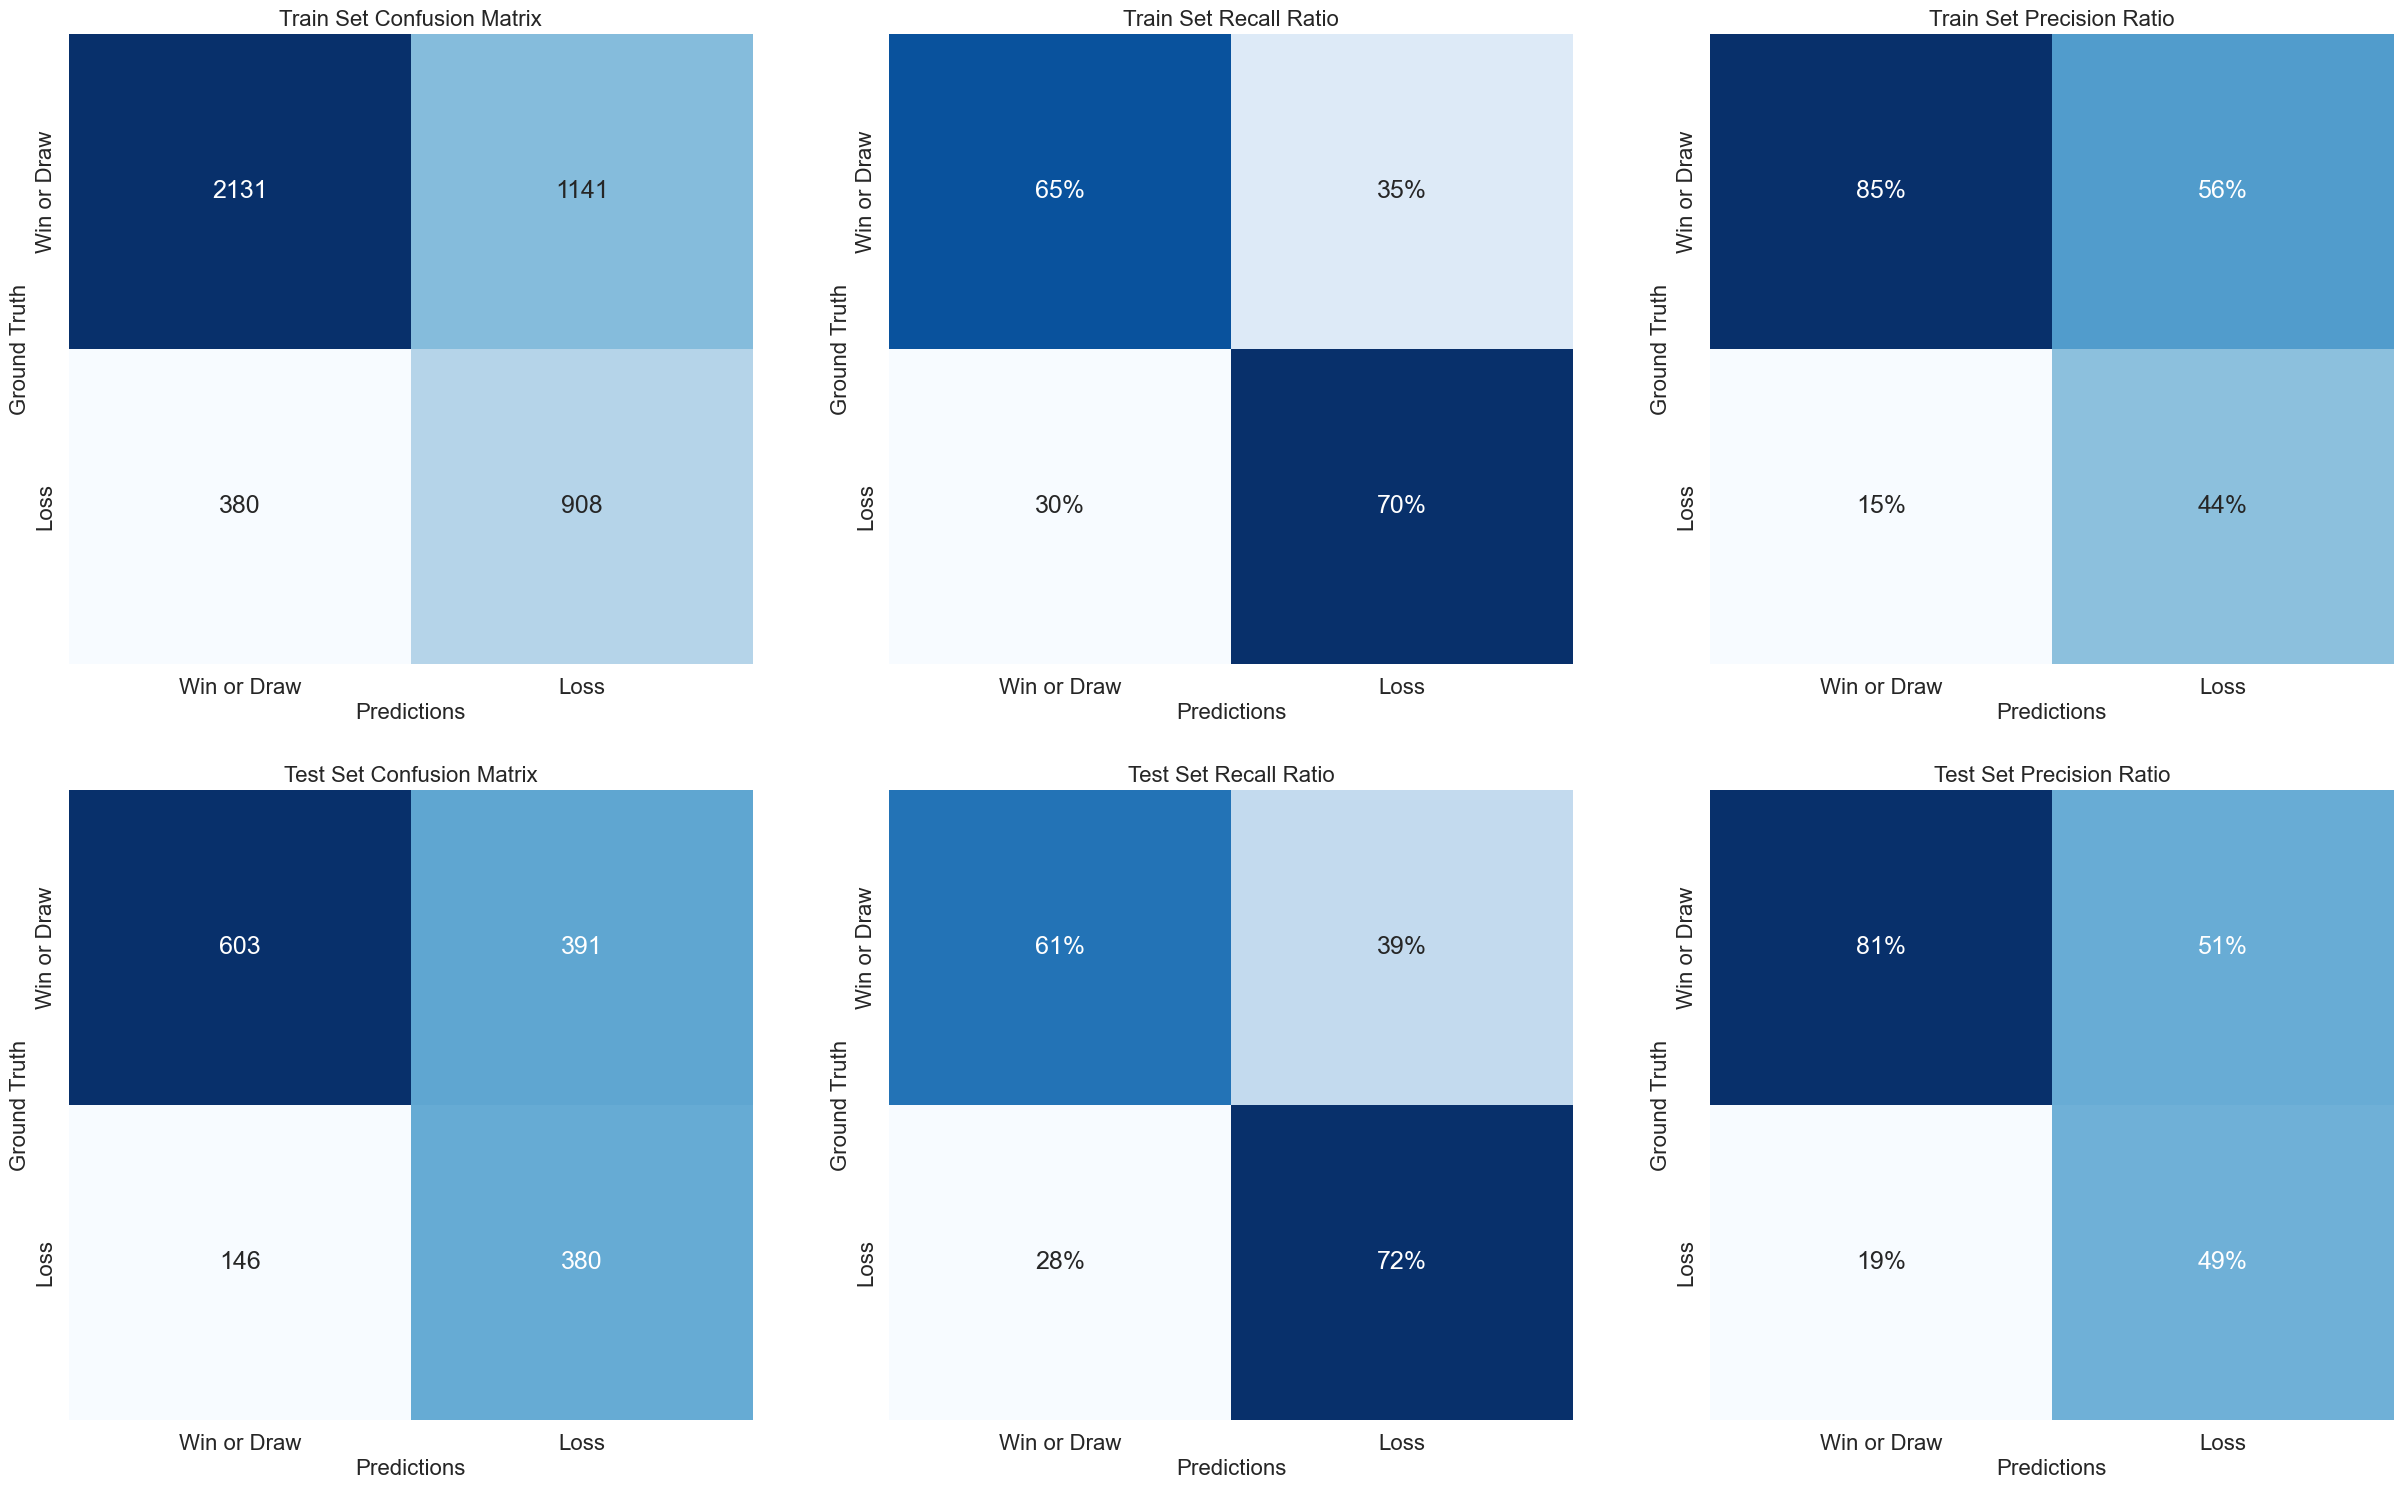

In [22]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = lr_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [23]:
# Calling the function to evaluate the performance of the classifier
lr_model_summary_df = evaluate_model_performance(model = lr_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = "Logistic Regression",
                                                 train_threshold = train_threshold,
                                                 test_threshold = test_threshold)
# Displaying the model performance
lr_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Logistic Regression       0.75      0.72                     0.68   

                     Test Balanced Accuracy  Accuracy  Precision  Recall  \
Logistic Regression                    0.66      0.65       0.49    0.72   

                       F1   MCC  Brier Loss  N Features  \
Logistic Regression  0.58  0.31         0.2         274   

                                                              Pipeline  
Logistic Regression  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Support Vector Machine

In [24]:
# Building a classifier
svm_model = build_pipeline(classifier = SVC(probability = True, random_state = 42),
                           apply_feature_scaling = True,
                           feature_scaler_type = "minmax",
                           apply_feature_selection = True,
                           feature_selection_type = "mutual_info",
                           train_features = X_train, 
                           train_labels = y_train, 
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "Support Vector Machine model has been built")

# Displaying the architecture of the classifier
svm_model

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_goals_scored_a',
                                                   'total_avg_goals_scored_h',
                                                   'total_avg_goals_scored_a',
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector', SelectPercentile()),
                ('classifier', SVC(probability=True, random_state=42))])

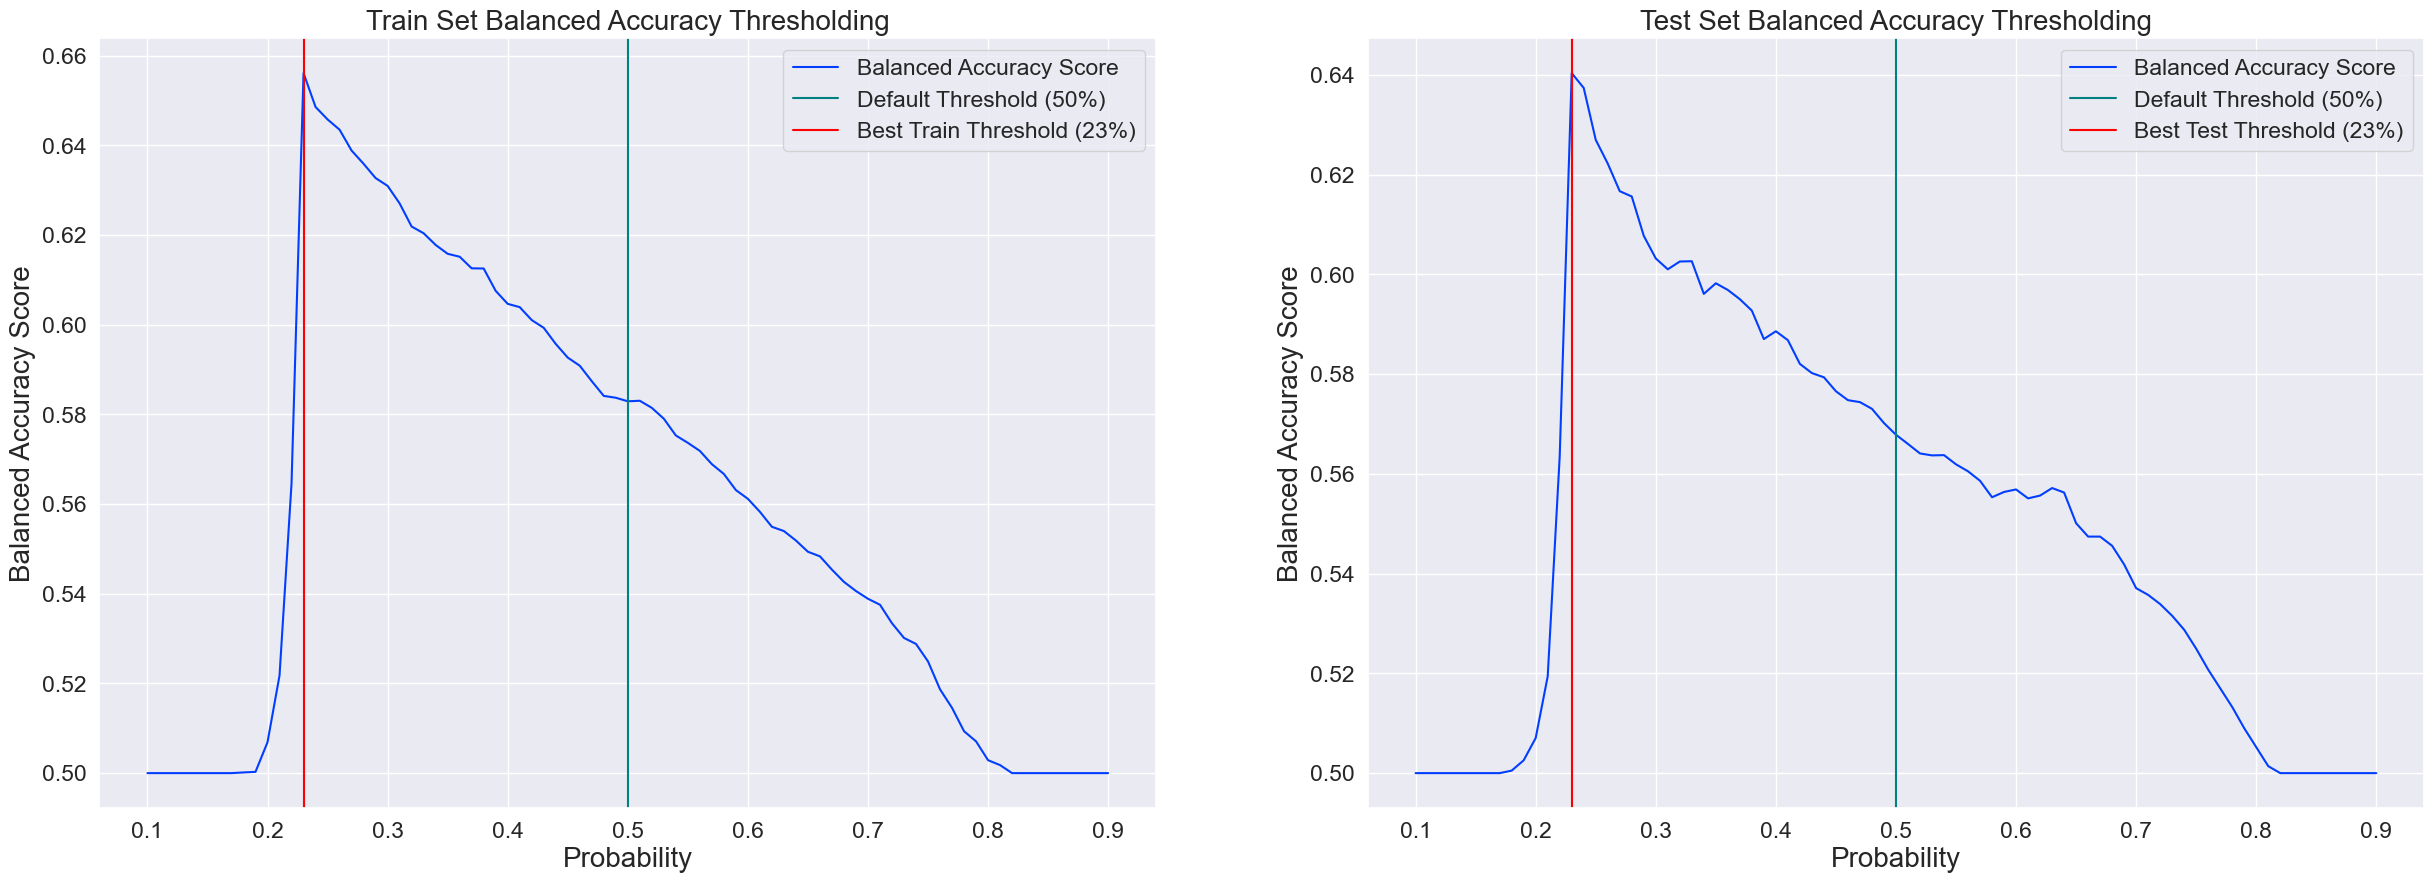

In [25]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = svm_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [26]:
# Calling the function to print out the classification report
print_classification_report(model = svm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Support Vector Machine")

Classification Report Summary for Support Vector Machine Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.81      0.79      0.80      3272
        Loss       0.49      0.53      0.51      1288

    accuracy                           0.71      4560
   macro avg       0.65      0.66      0.65      4560
weighted avg       0.72      0.71      0.72      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.75      0.78      0.76       994
        Loss       0.55      0.50      0.52       526

    accuracy                           0.68      1520
   macro avg       0.65      0.64      0.64      1520
weighted avg       0.68      0.68      0.68      1520



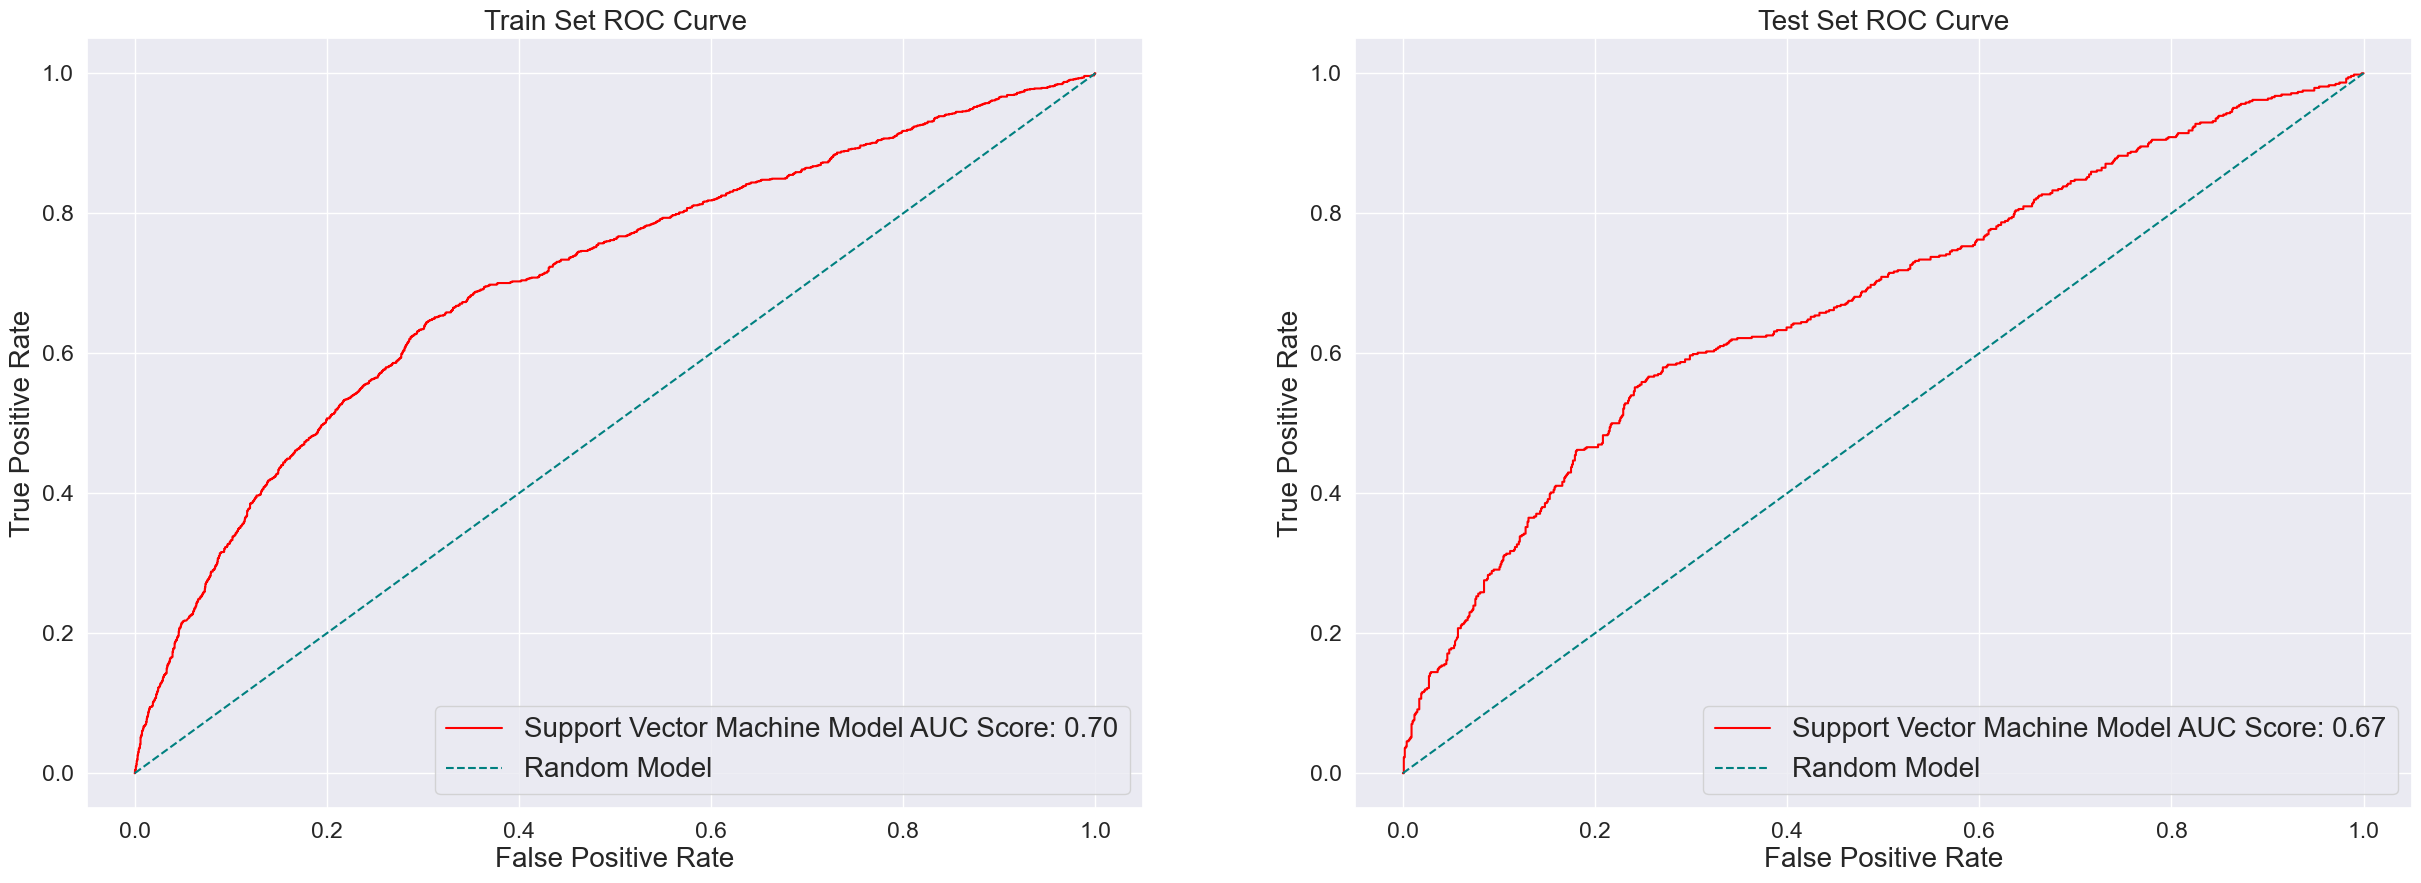

In [27]:
# Calling the function to plot ROC curve
plot_roc_curve(model = svm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Support Vector Machine")

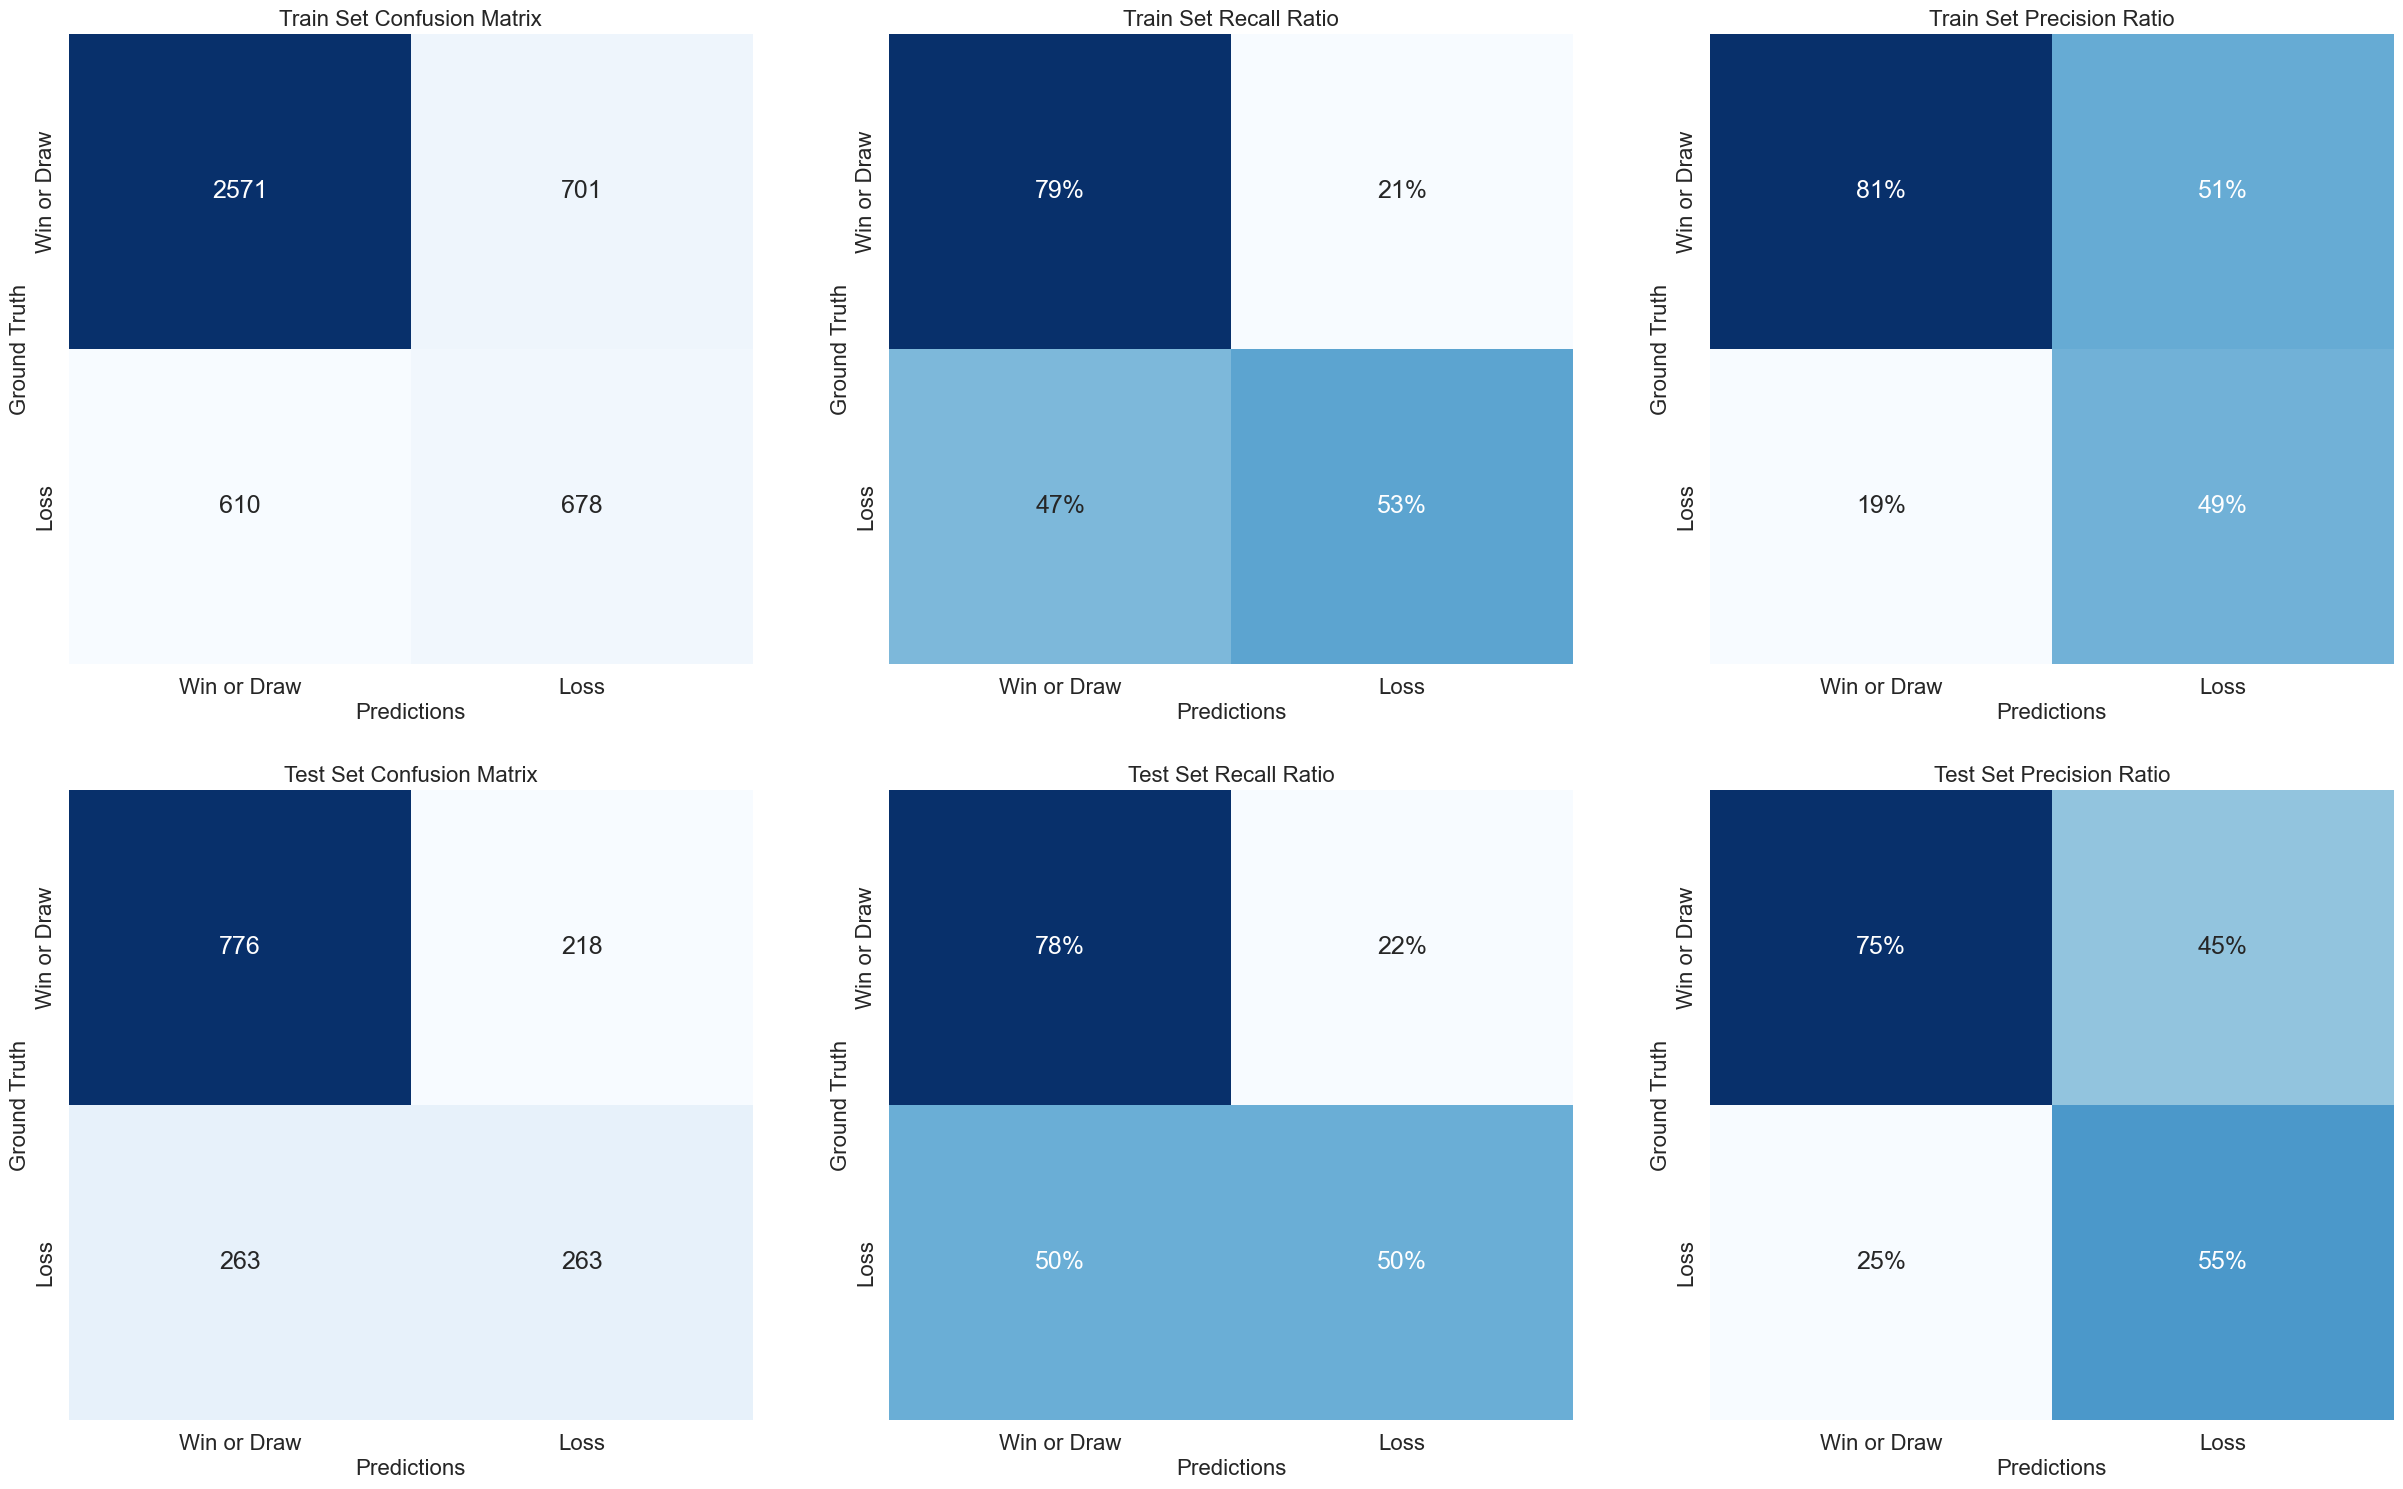

In [28]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = svm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [29]:
# Calling the function to evaluate the performance of the classifier
svm_model_summary_df = evaluate_model_performance(model = svm_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "Support Vector Machine",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the model performance
svm_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Support Vector Machine        0.7      0.67                     0.66   

                        Test Balanced Accuracy  Accuracy  Precision  Recall  \
Support Vector Machine                    0.64      0.68       0.55     0.5   

                          F1   MCC  Brier Loss  N Features  \
Support Vector Machine  0.52  0.29        0.21          31   

                                                                 Pipeline  
Support Vector Machine  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### K Nearest Neighbors

In [30]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_transformer__numeric_pipeline__feature_scaler"] = feature_scalers
search_spaces["feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 91, 10)))
search_spaces["classifier__n_neighbors"] = skopt.space.Integer(low = 2, high = 8, prior = "log-uniform")
search_spaces["classifier__weights"] = skopt.space.Categorical(categories = ["uniform", "distance"])

# Building a classifier
knn_model = build_pipeline(classifier = KNeighborsClassifier(),
                           apply_feature_scaling = True,
                           feature_scaler_type = "maxabs",
                           apply_feature_selection = True,
                           feature_selection_type = "mutual_info",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           train_features = X_train, 
                           train_labels = y_train, 
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "K Nearest Neighbors model has been built")

# Displaying the architecture of the classifier
knn_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_h',
                                                   'total_avg_goals_scored_a',
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector', SelectPercentile(percentile=40)),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=8, weights='distance'))])

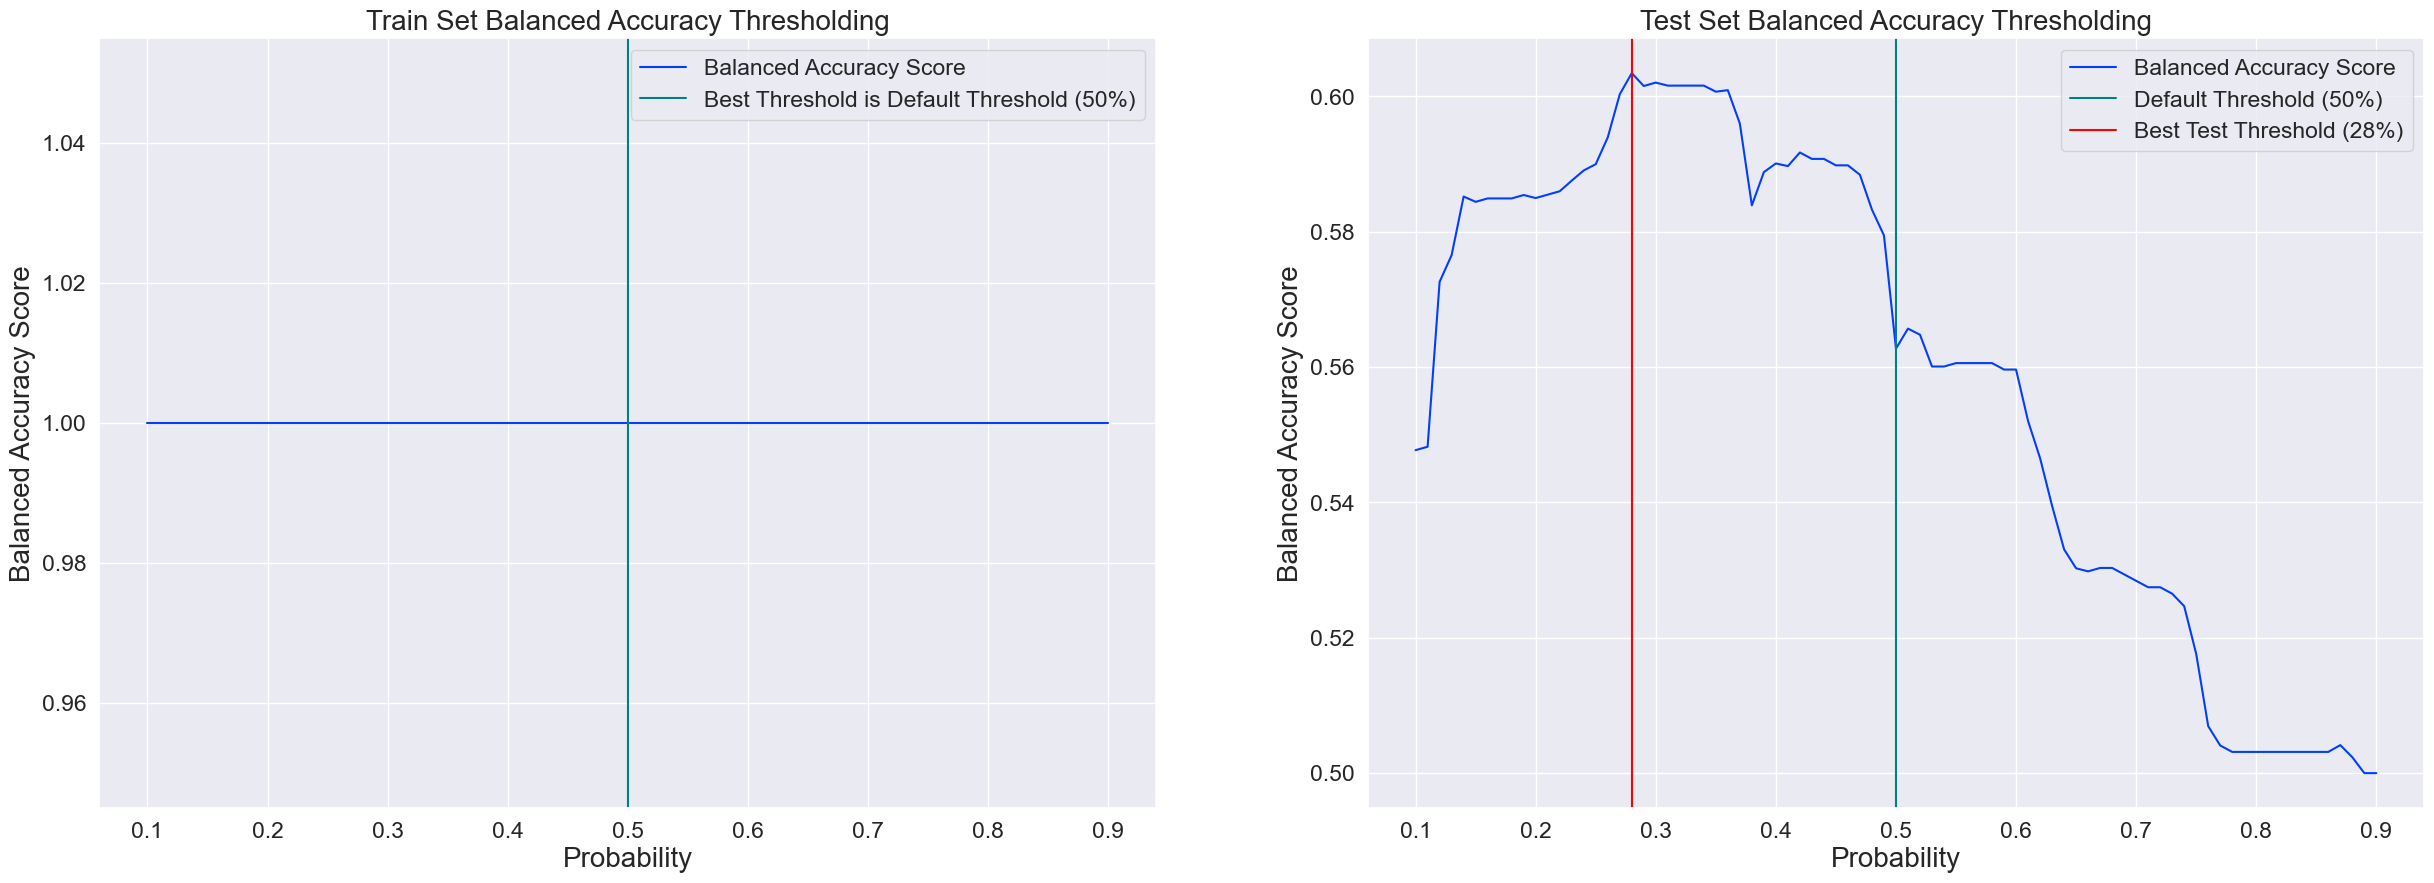

In [31]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = knn_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [32]:
# Calling the function to print out the classification report
print_classification_report(model = knn_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "K Nearest Neighbors")

Classification Report Summary for K Nearest Neighbors Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       1.00      1.00      1.00      3272
        Loss       1.00      1.00      1.00      1288

    accuracy                           1.00      4560
   macro avg       1.00      1.00      1.00      4560
weighted avg       1.00      1.00      1.00      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.73      0.66      0.70       994
        Loss       0.46      0.54      0.50       526

    accuracy                           0.62      1520
   macro avg       0.60      0.60      0.60      1520
weighted avg       0.64      0.62      0.63      1520



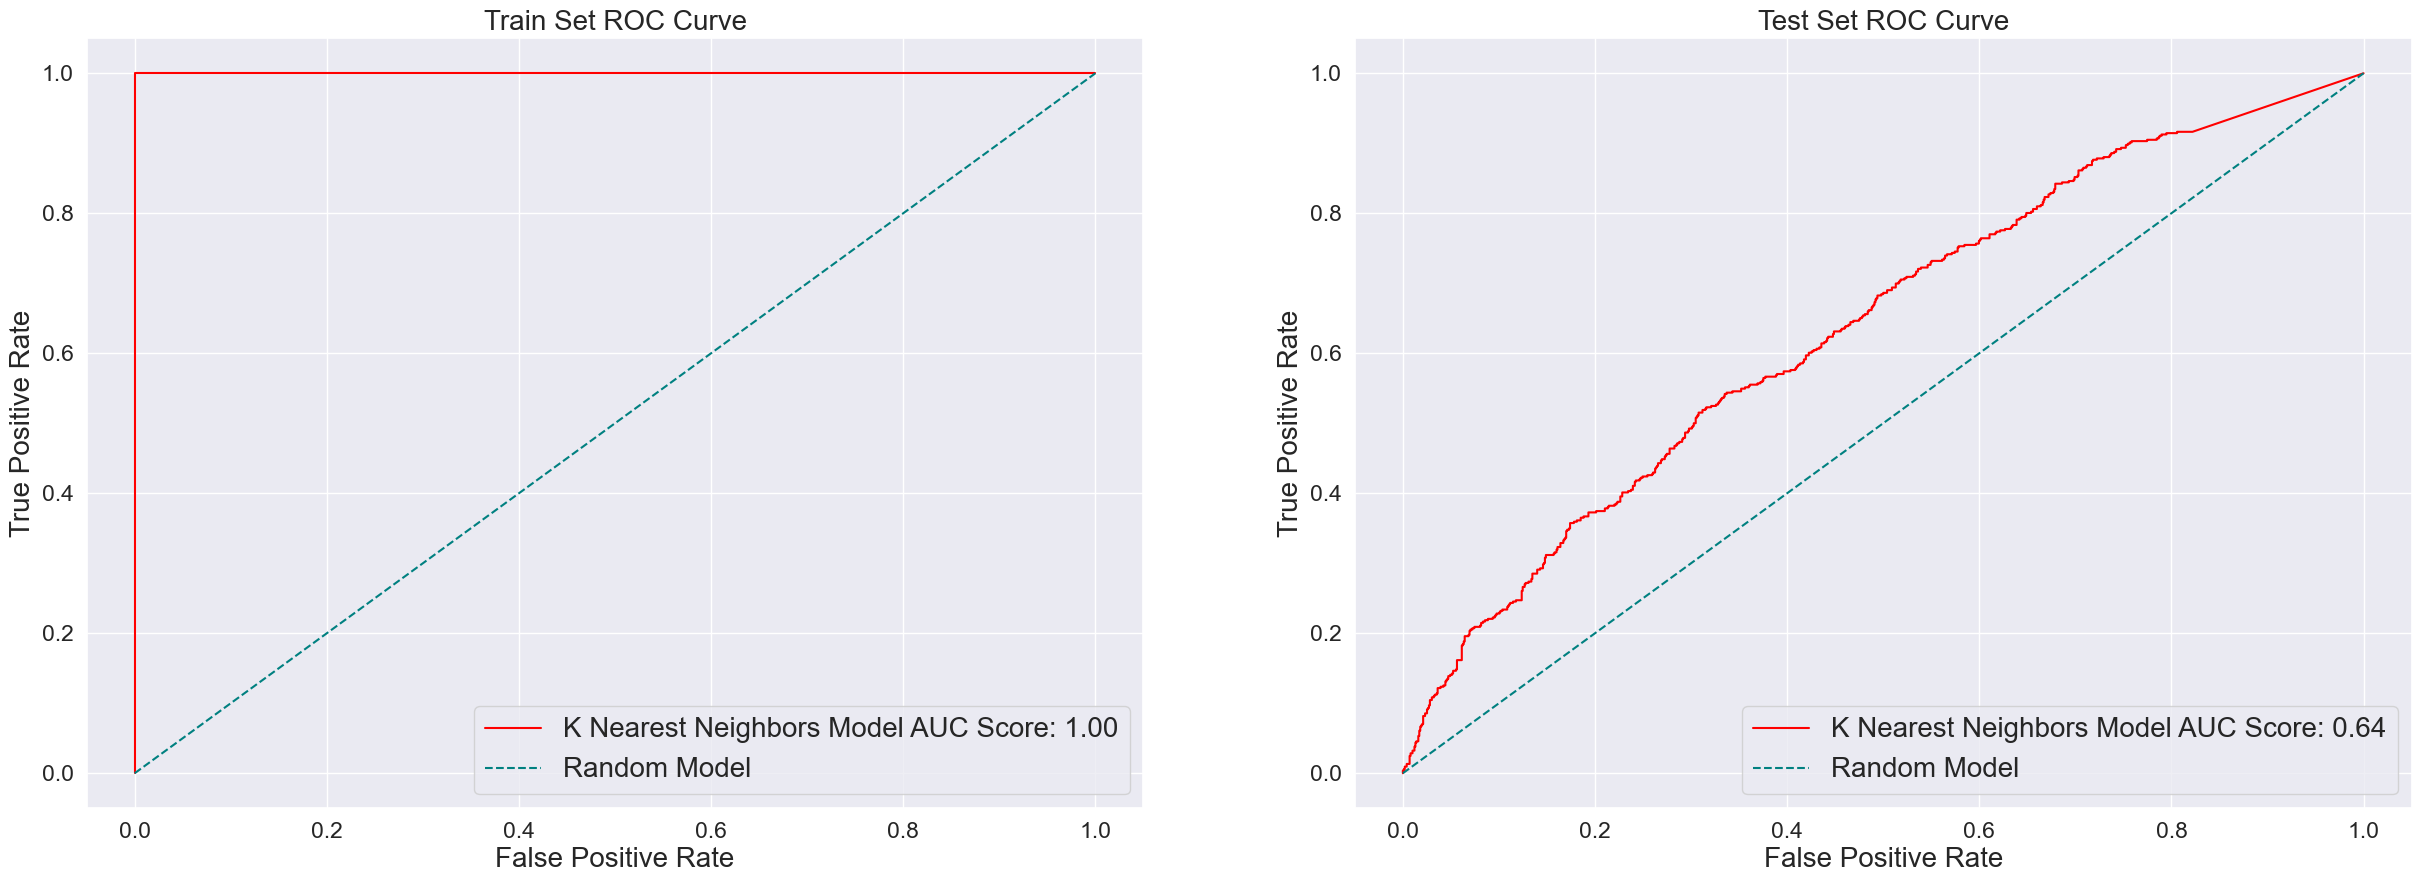

In [33]:
# Calling the function to plot ROC curve
plot_roc_curve(model = knn_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "K Nearest Neighbors")

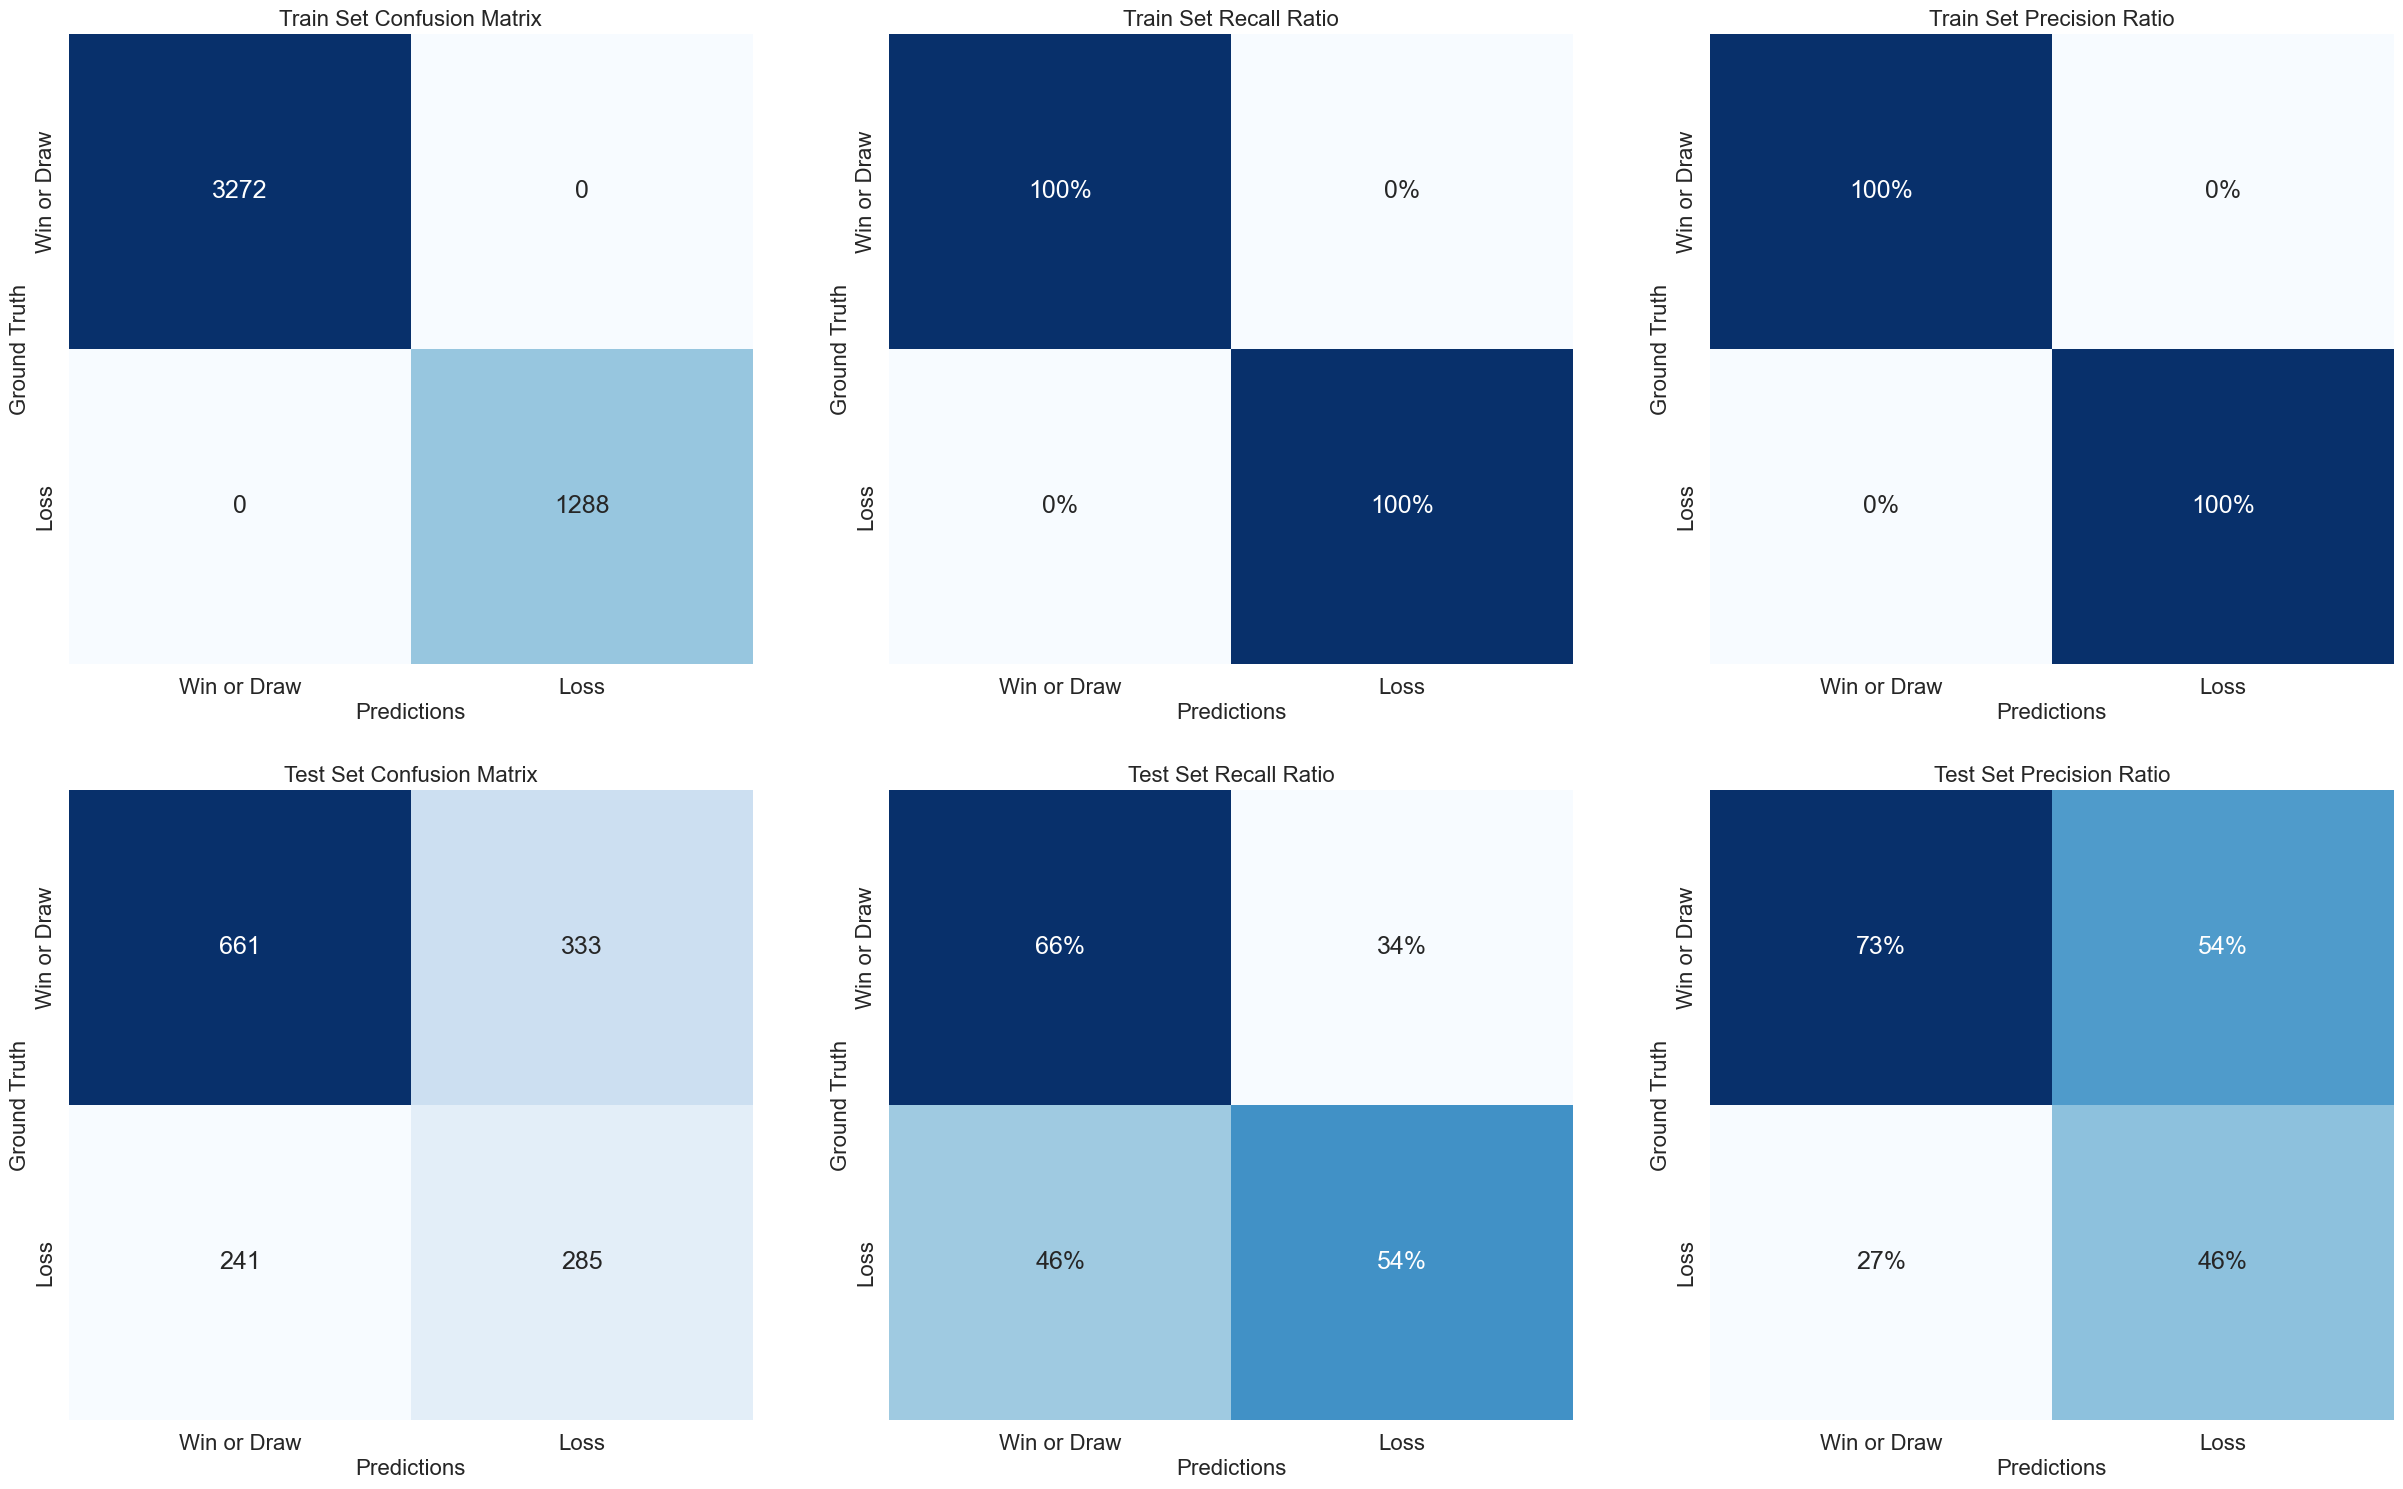

In [34]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = knn_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [35]:
# Calling the function to evaluate the performance of the classifier
knn_model_summary_df = evaluate_model_performance(model = knn_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "K Nearest Neighbors",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the model performance
knn_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
K Nearest Neighbors        1.0      0.64                      1.0   

                     Test Balanced Accuracy  Accuracy  Precision  Recall   F1  \
K Nearest Neighbors                     0.6      0.62       0.46    0.54  0.5   

                     MCC  Brier Loss  N Features  \
K Nearest Neighbors  0.2        0.23         122   

                                                              Pipeline  
K Nearest Neighbors  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Multi Layer Perceptron

In [36]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_transformer__numeric_pipeline__feature_scaler"] = feature_scalers
search_spaces["feature_selector__percentile"] = skopt.space.Categorical(categories = list(range(10, 91, 10)))
search_spaces["classifier__alpha"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__learning_rate"] = skopt.space.Categorical(categories = ["constant", "invscaling", "adaptive"])
search_spaces["classifier__learning_rate_init"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__tol"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")

# Building a classifier
mlp_model = build_pipeline(classifier = MLPClassifier(learning_rate = "adaptive", 
                                                      max_iter = 1000, 
                                                      shuffle = False, 
                                                      early_stopping = True,
                                                      n_iter_no_change = 3),  
                           apply_feature_scaling = True,
                           feature_scaler_type = "standard",
                           apply_feature_selection = True,
                           feature_selection_type = "mutual_info",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           train_features = X_train, 
                           train_labels = y_train, 
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "Multi Layer Perceptron model has been built")

# Displaying the architecture of the classifier
mlp_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector', SelectPercentile(percentile=90)),
                ('classifier',
                 MLPClassifier(alpha=0.1, early_stopping=True,
                               learning_rate='adaptive',
                               learning_rate_init=0.03552197786623699,
                               max_iter=1000, n_iter_no_change=3, shuffle=False,
                               tol=1e-08))])

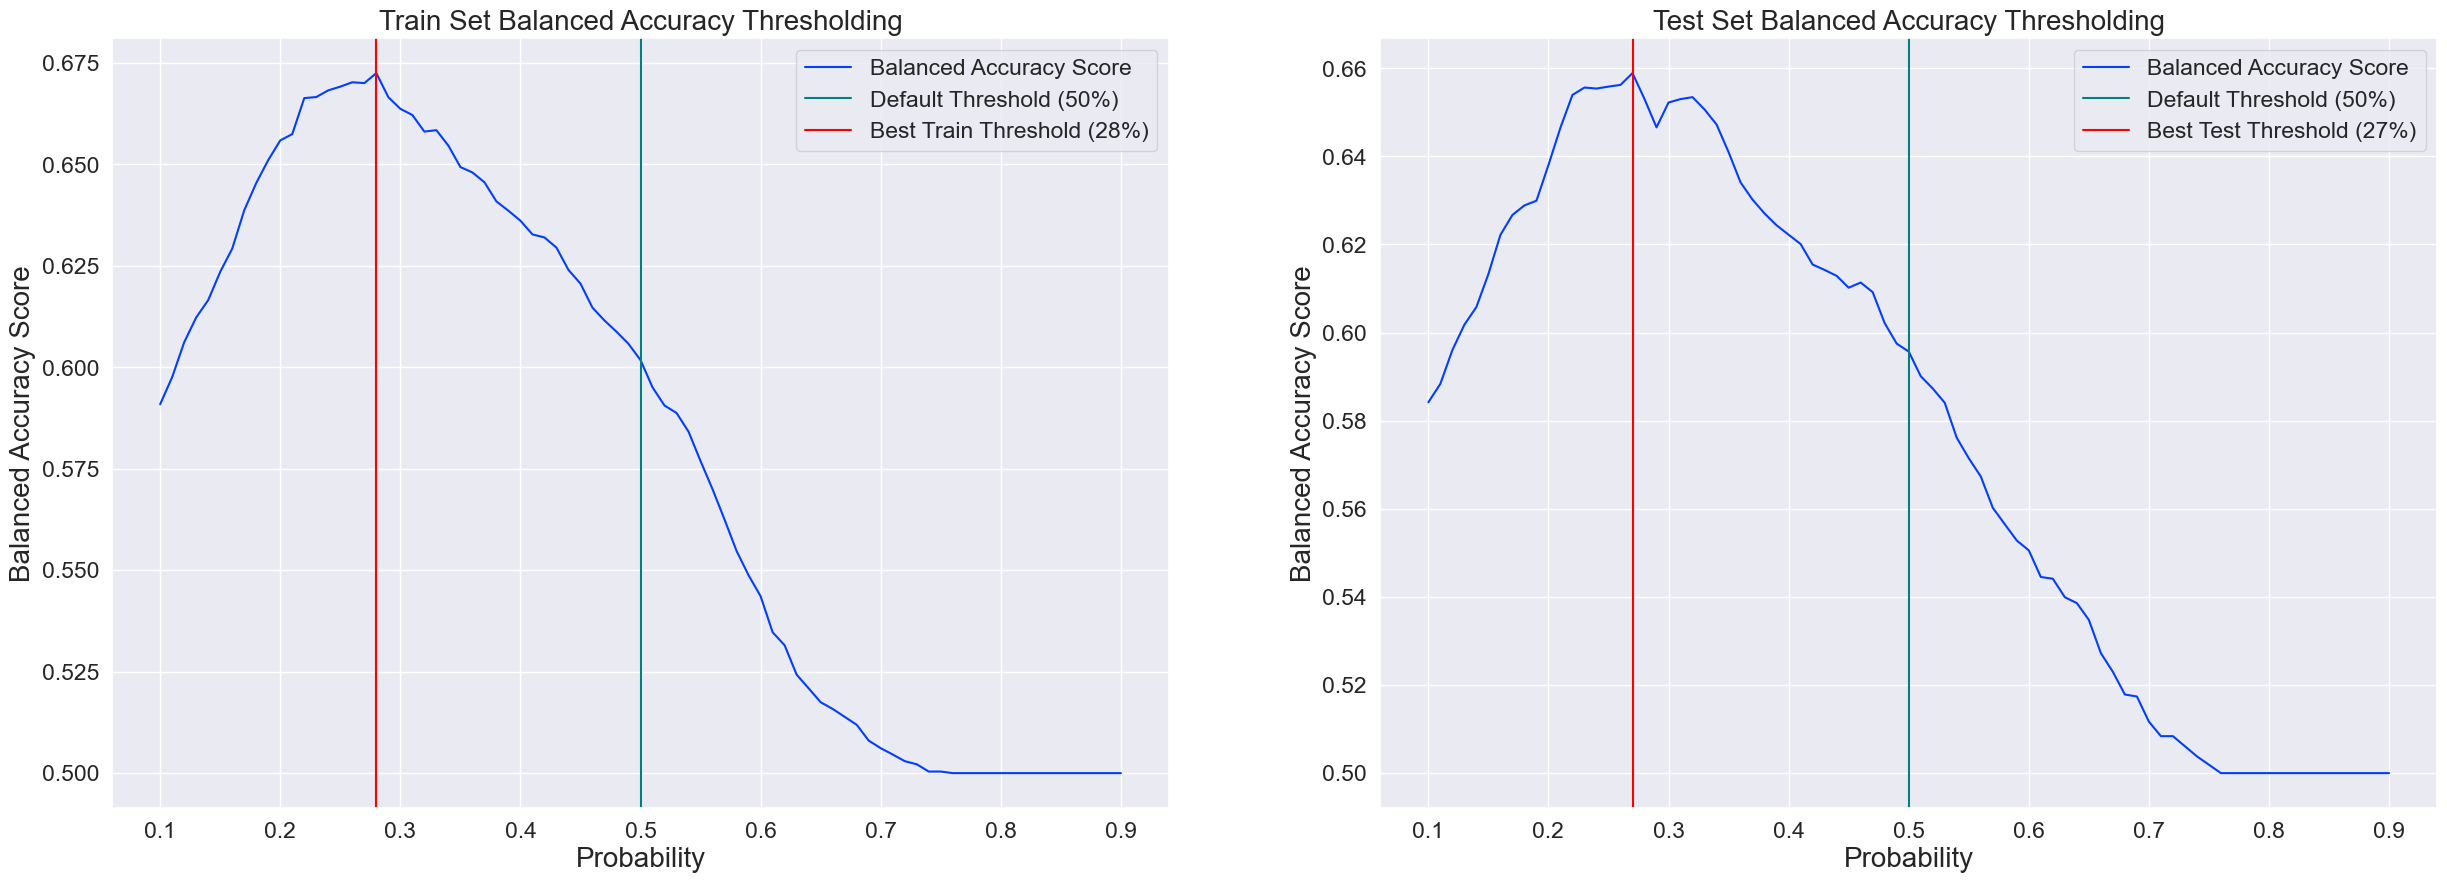

In [37]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = mlp_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [38]:
# Calling the function to print out the classification report
print_classification_report(model = mlp_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test,
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Multi Layer Perceptron")

Classification Report Summary for Multi Layer Perceptron Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.83      0.74      0.78      3272
        Loss       0.48      0.61      0.53      1288

    accuracy                           0.70      4560
   macro avg       0.65      0.67      0.66      4560
weighted avg       0.73      0.70      0.71      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.78      0.66      0.72       994
        Loss       0.51      0.66      0.57       526

    accuracy                           0.66      1520
   macro avg       0.65      0.66      0.64      1520
weighted avg       0.69      0.66      0.67      1520



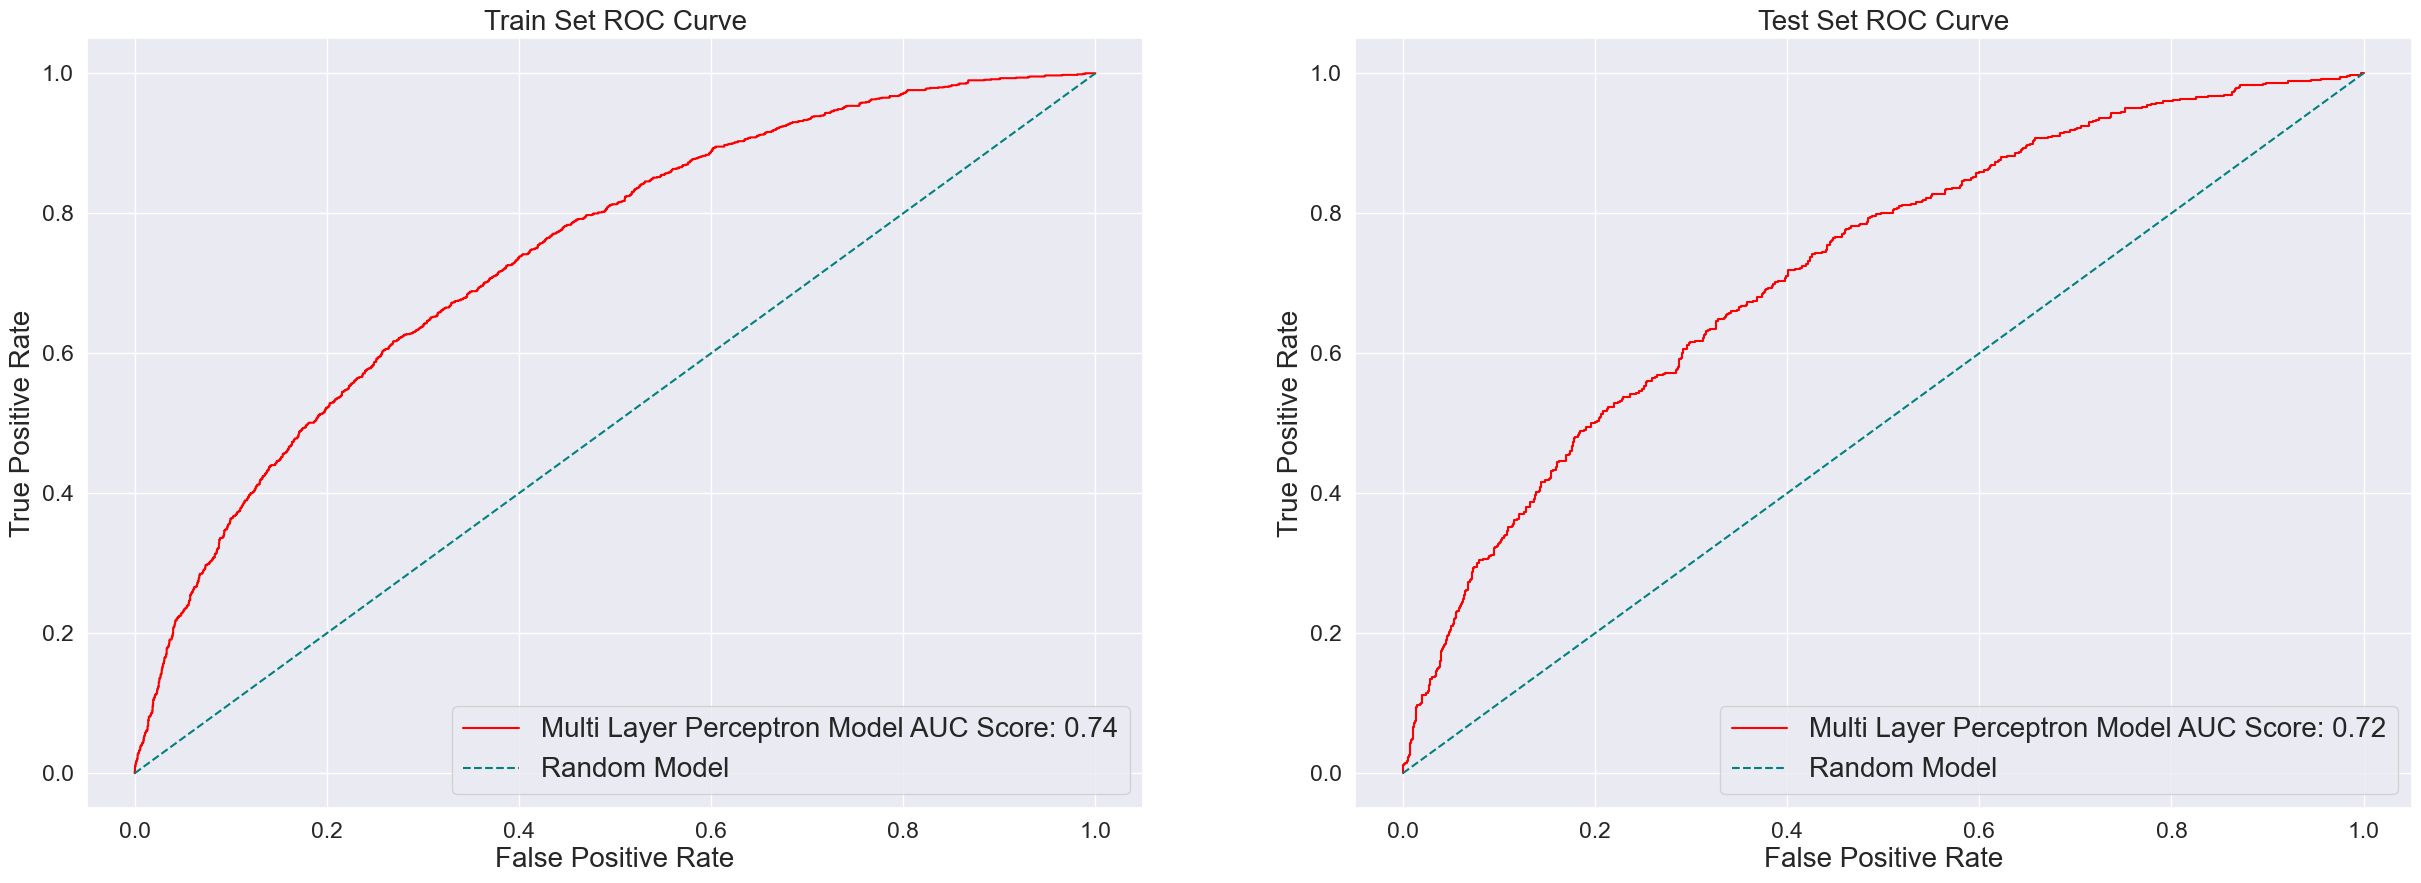

In [39]:
# Calling the function to plot ROC curve
plot_roc_curve(model = mlp_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Multi Layer Perceptron")

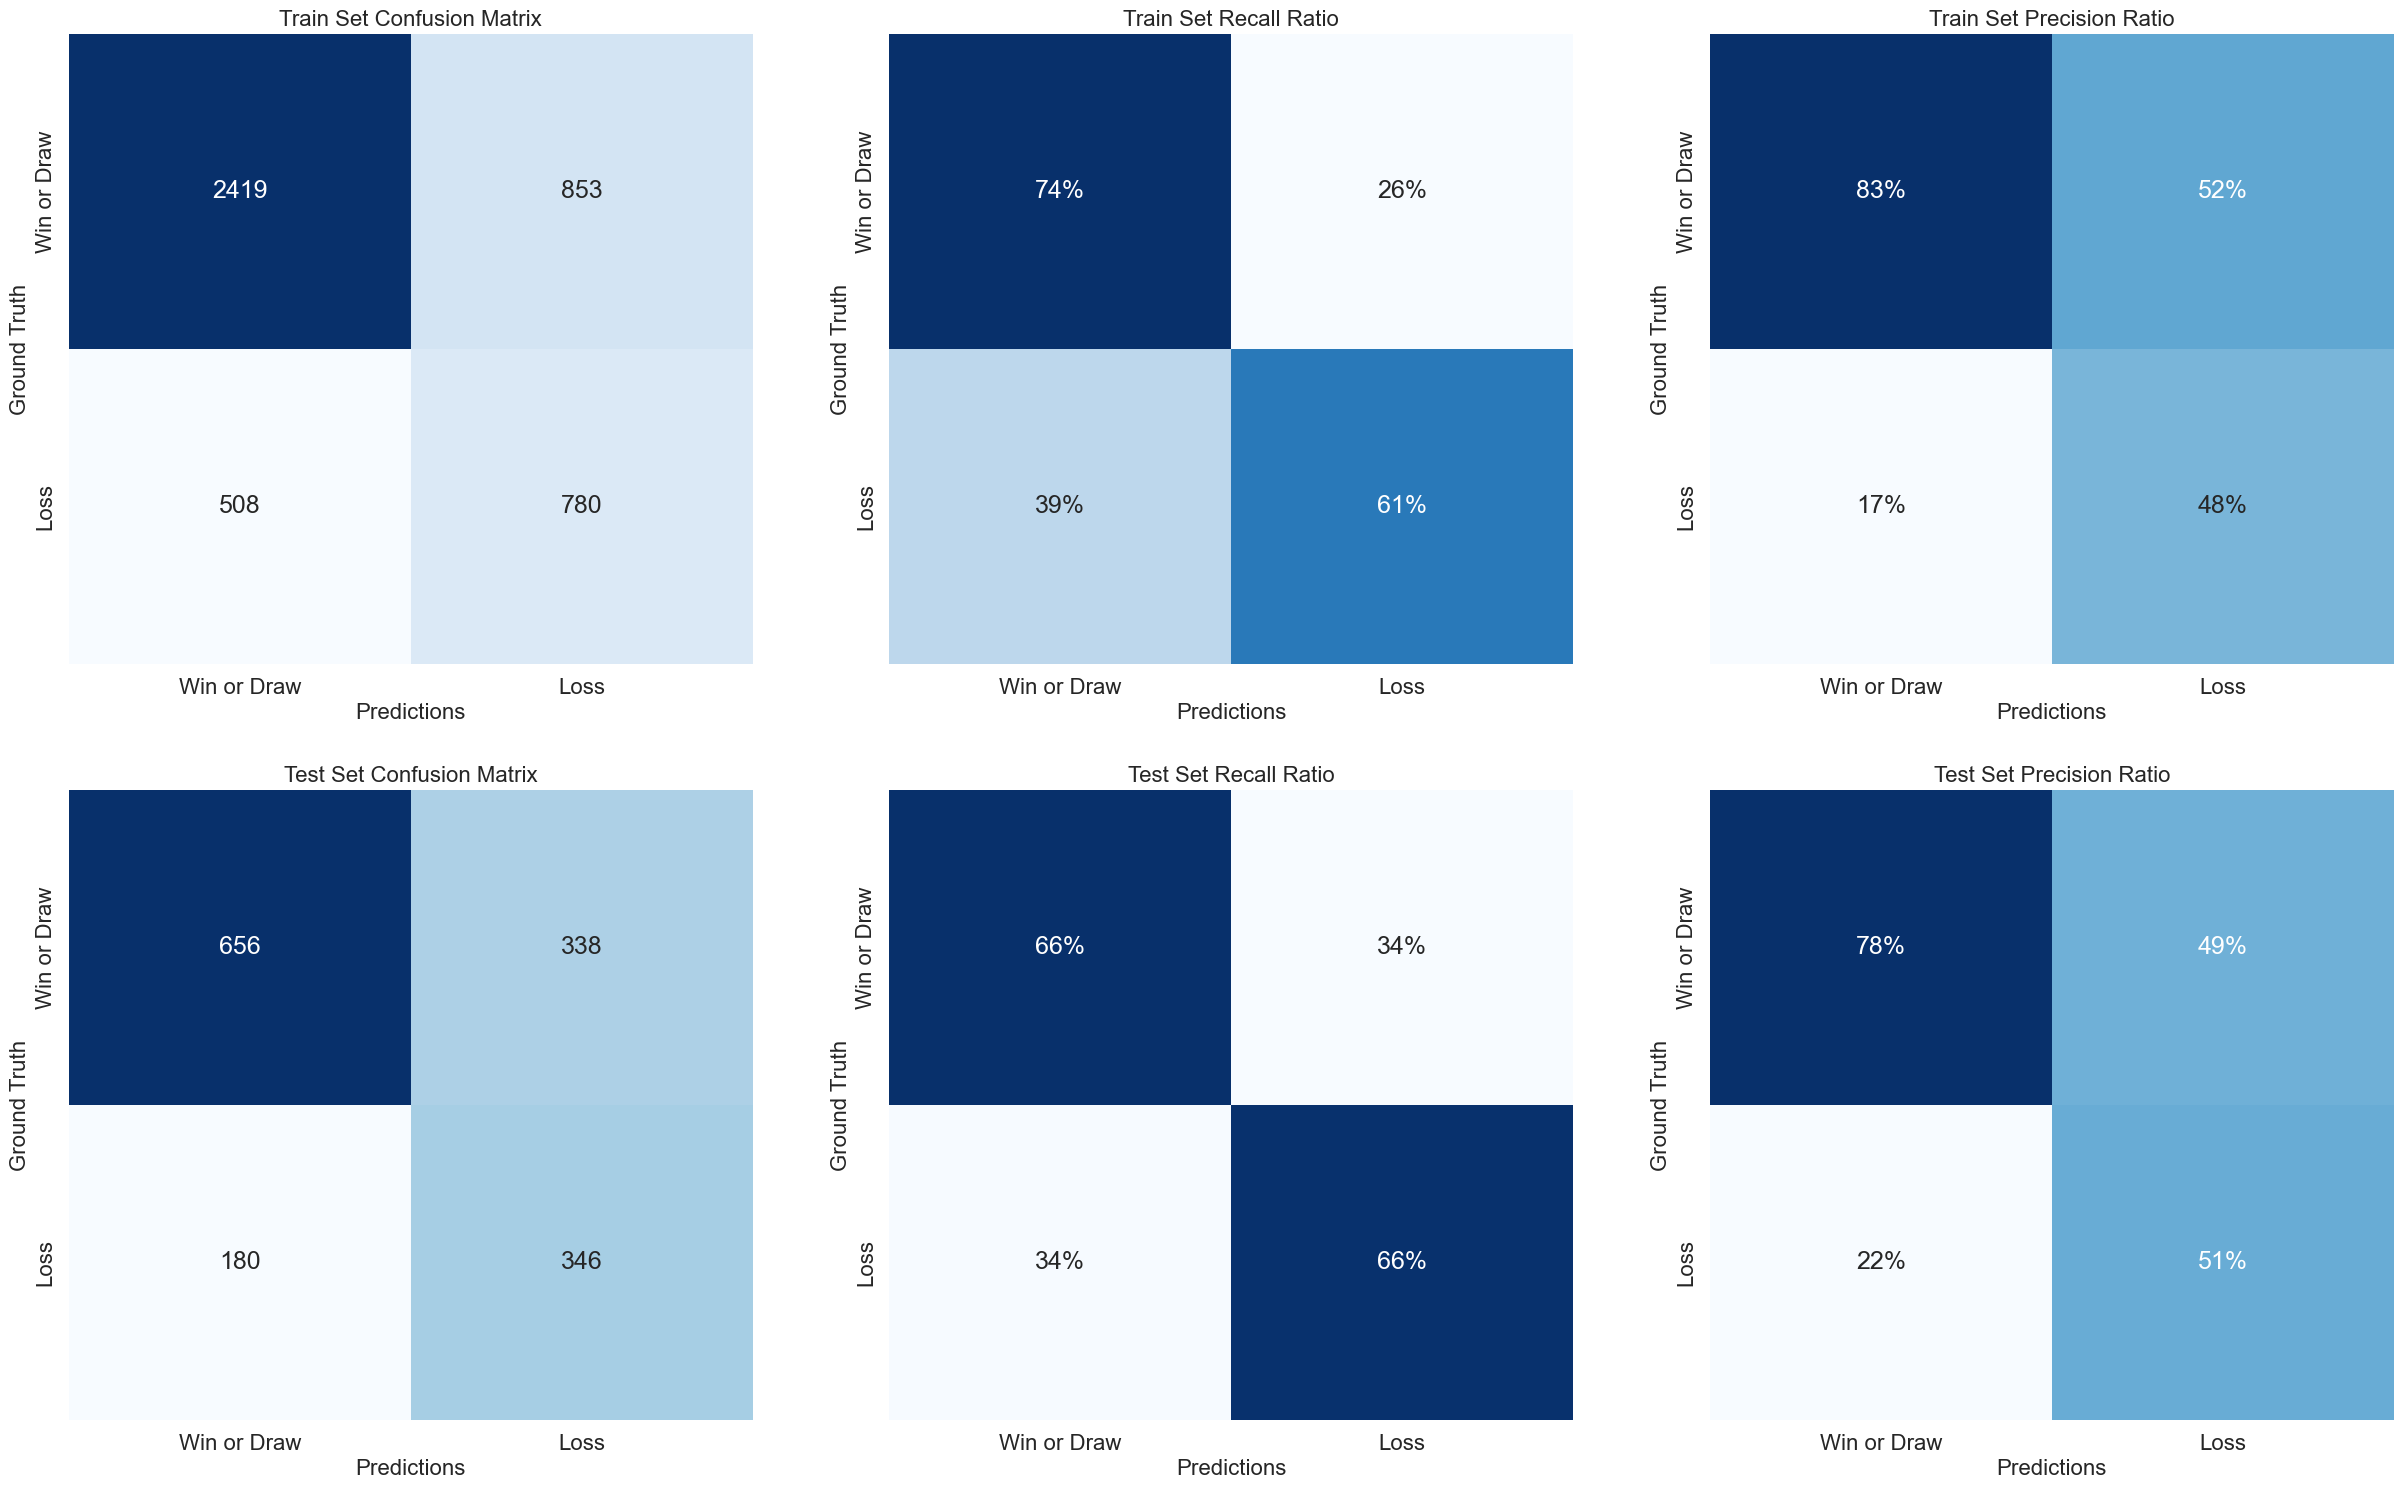

In [40]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = mlp_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [41]:
# Calling the function to evaluate the performance of the classifier
mlp_model_summary_df = evaluate_model_performance(model = mlp_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "Multi Layer Perceptron",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the model performance
mlp_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Multi Layer Perceptron       0.74      0.72                     0.67   

                        Test Balanced Accuracy  Accuracy  Precision  Recall  \
Multi Layer Perceptron                    0.66      0.66       0.51    0.66   

                          F1  MCC  Brier Loss  N Features  \
Multi Layer Perceptron  0.58  0.3         0.2         274   

                                                                 Pipeline  
Multi Layer Perceptron  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Decision Tree

In [42]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__criterion"] = skopt.space.Categorical(categories = ["gini", "entropy"])
search_spaces["classifier__max_depth"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["classifier__max_features"] = skopt.space.Categorical(categories = [None, "auto", "sqrt", "log2"])

# Building a classifier
dt_model = build_pipeline(classifier = DecisionTreeClassifier(random_state = 42),
                          apply_feature_selection = True,
                          feature_selection_type = "meta",
                          apply_bayesian_optimization = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          train_features = X_train, 
                          train_labels = y_train, 
                          verbosity = 1)

# Logging information to the log file
logging.info(msg = "Decision Tree model has been built")

# Displaying the architecture of the classifier
dt_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=42))),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=42))])

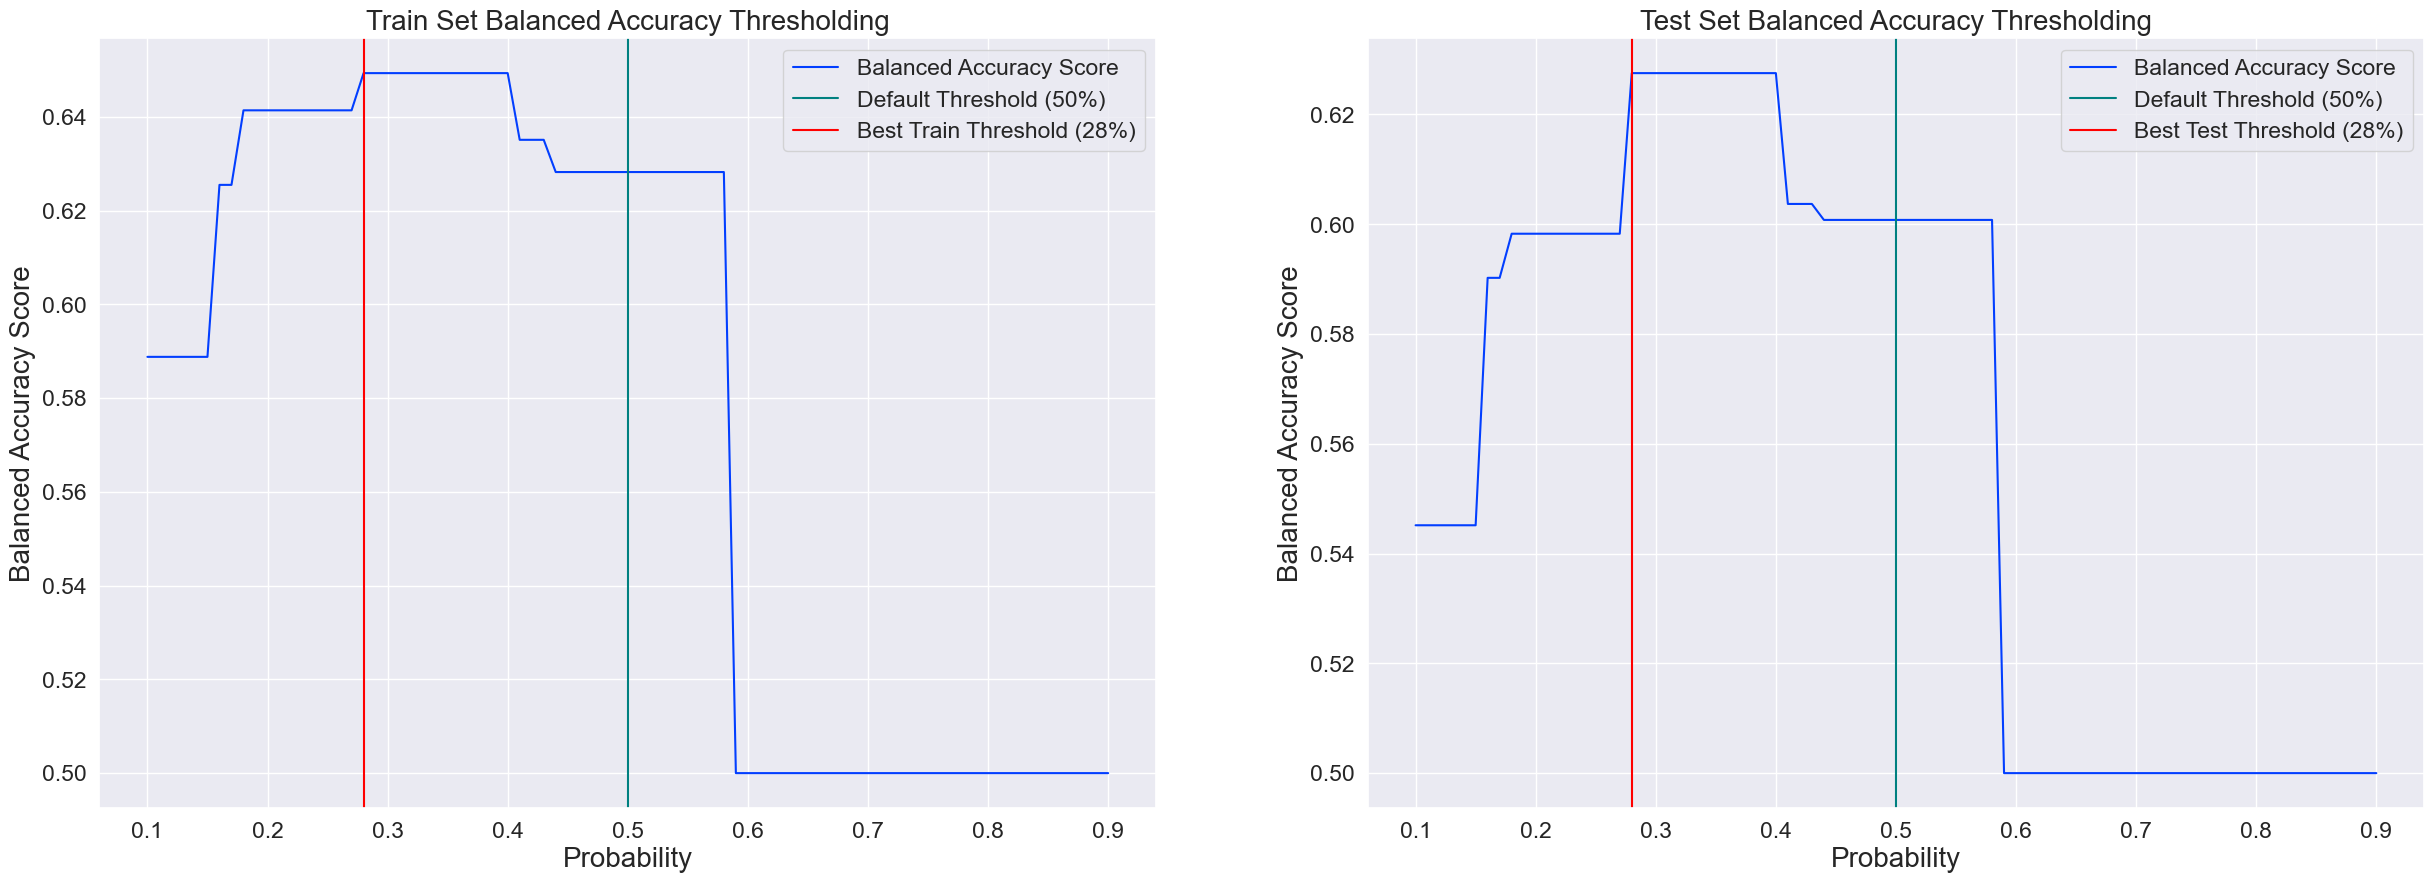

In [43]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = dt_model,
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [44]:
# Calling the function to print out the classification report
print_classification_report(model = dt_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Decision Tree")

Classification Report Summary for Decision Tree Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.80      0.84      0.82      3272
        Loss       0.53      0.45      0.49      1288

    accuracy                           0.73      4560
   macro avg       0.67      0.65      0.66      4560
weighted avg       0.72      0.73      0.73      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.73      0.85      0.79       994
        Loss       0.59      0.40      0.48       526

    accuracy                           0.70      1520
   macro avg       0.66      0.63      0.63      1520
weighted avg       0.68      0.70      0.68      1520



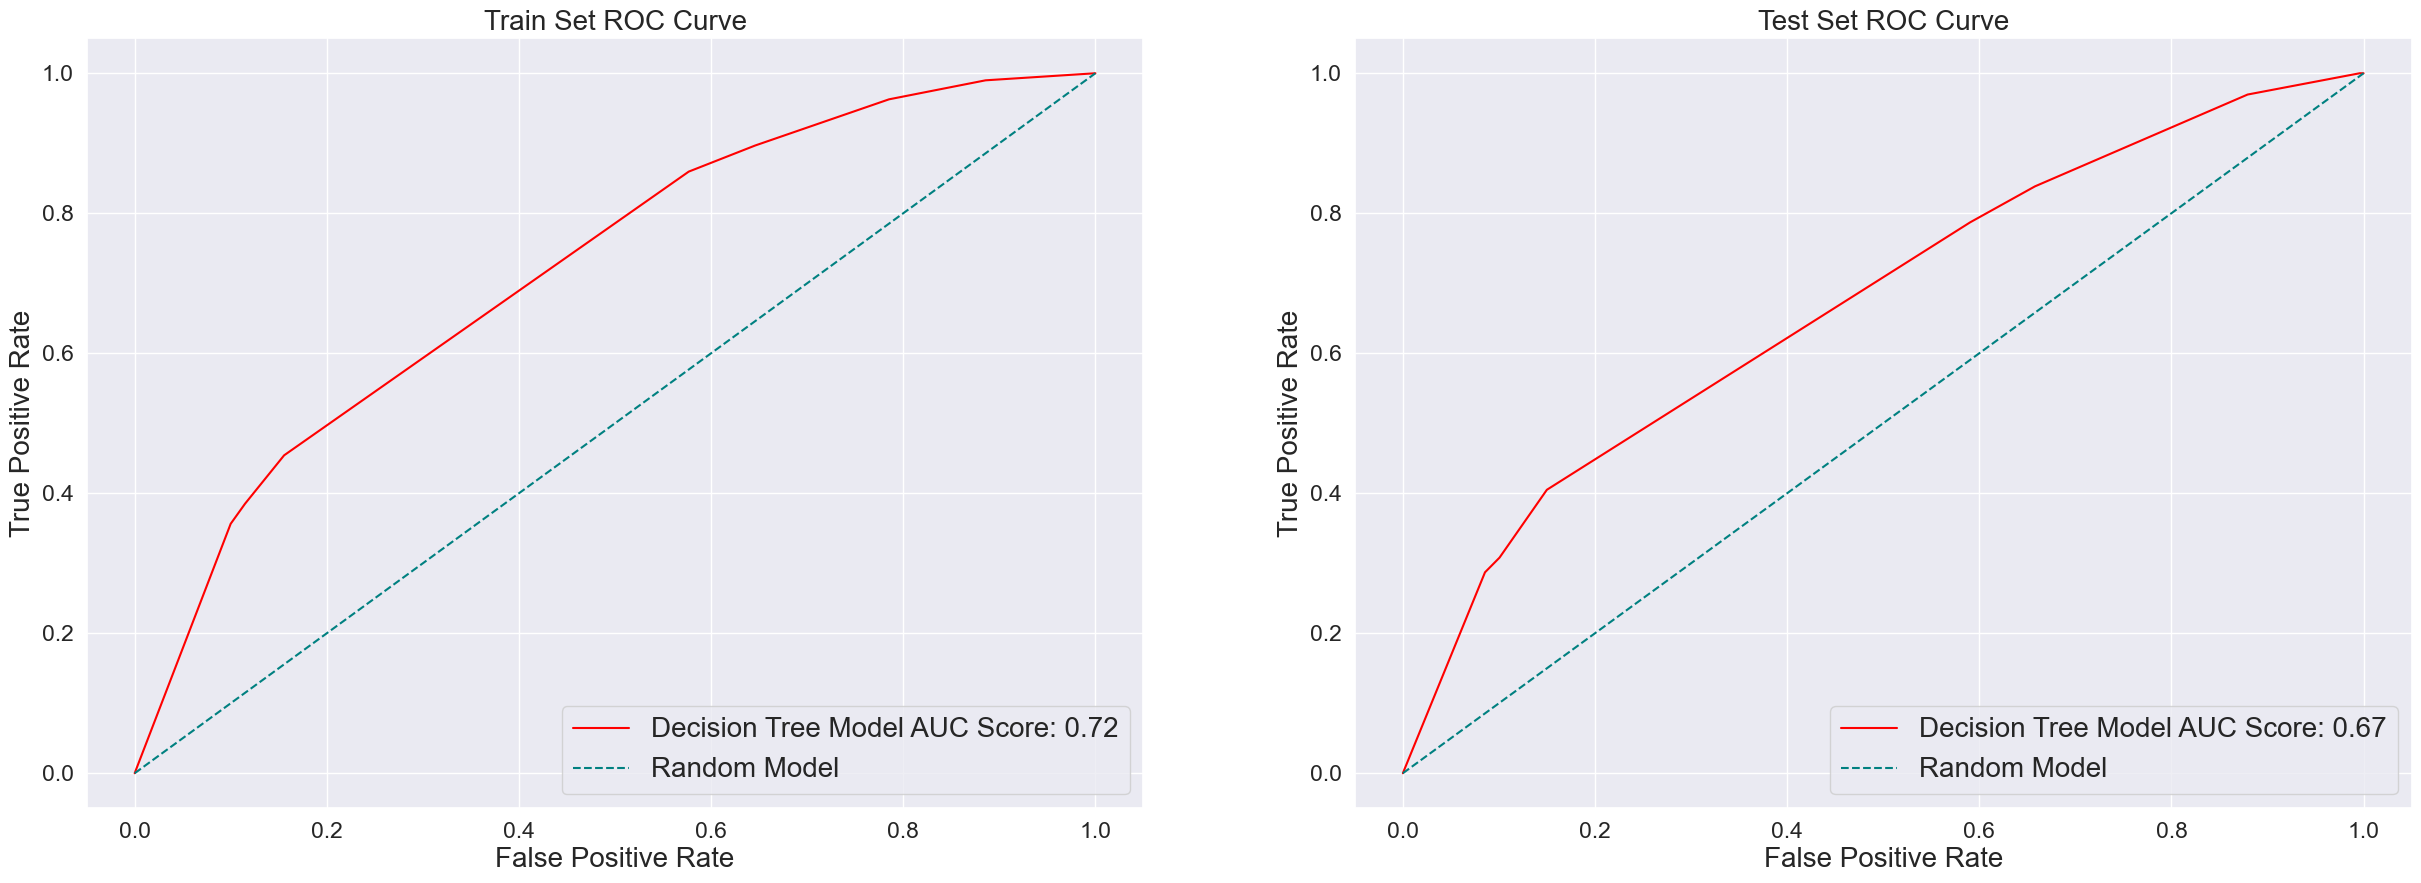

In [45]:
# Calling the function to plot ROC curve
plot_roc_curve(model = dt_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Decision Tree")

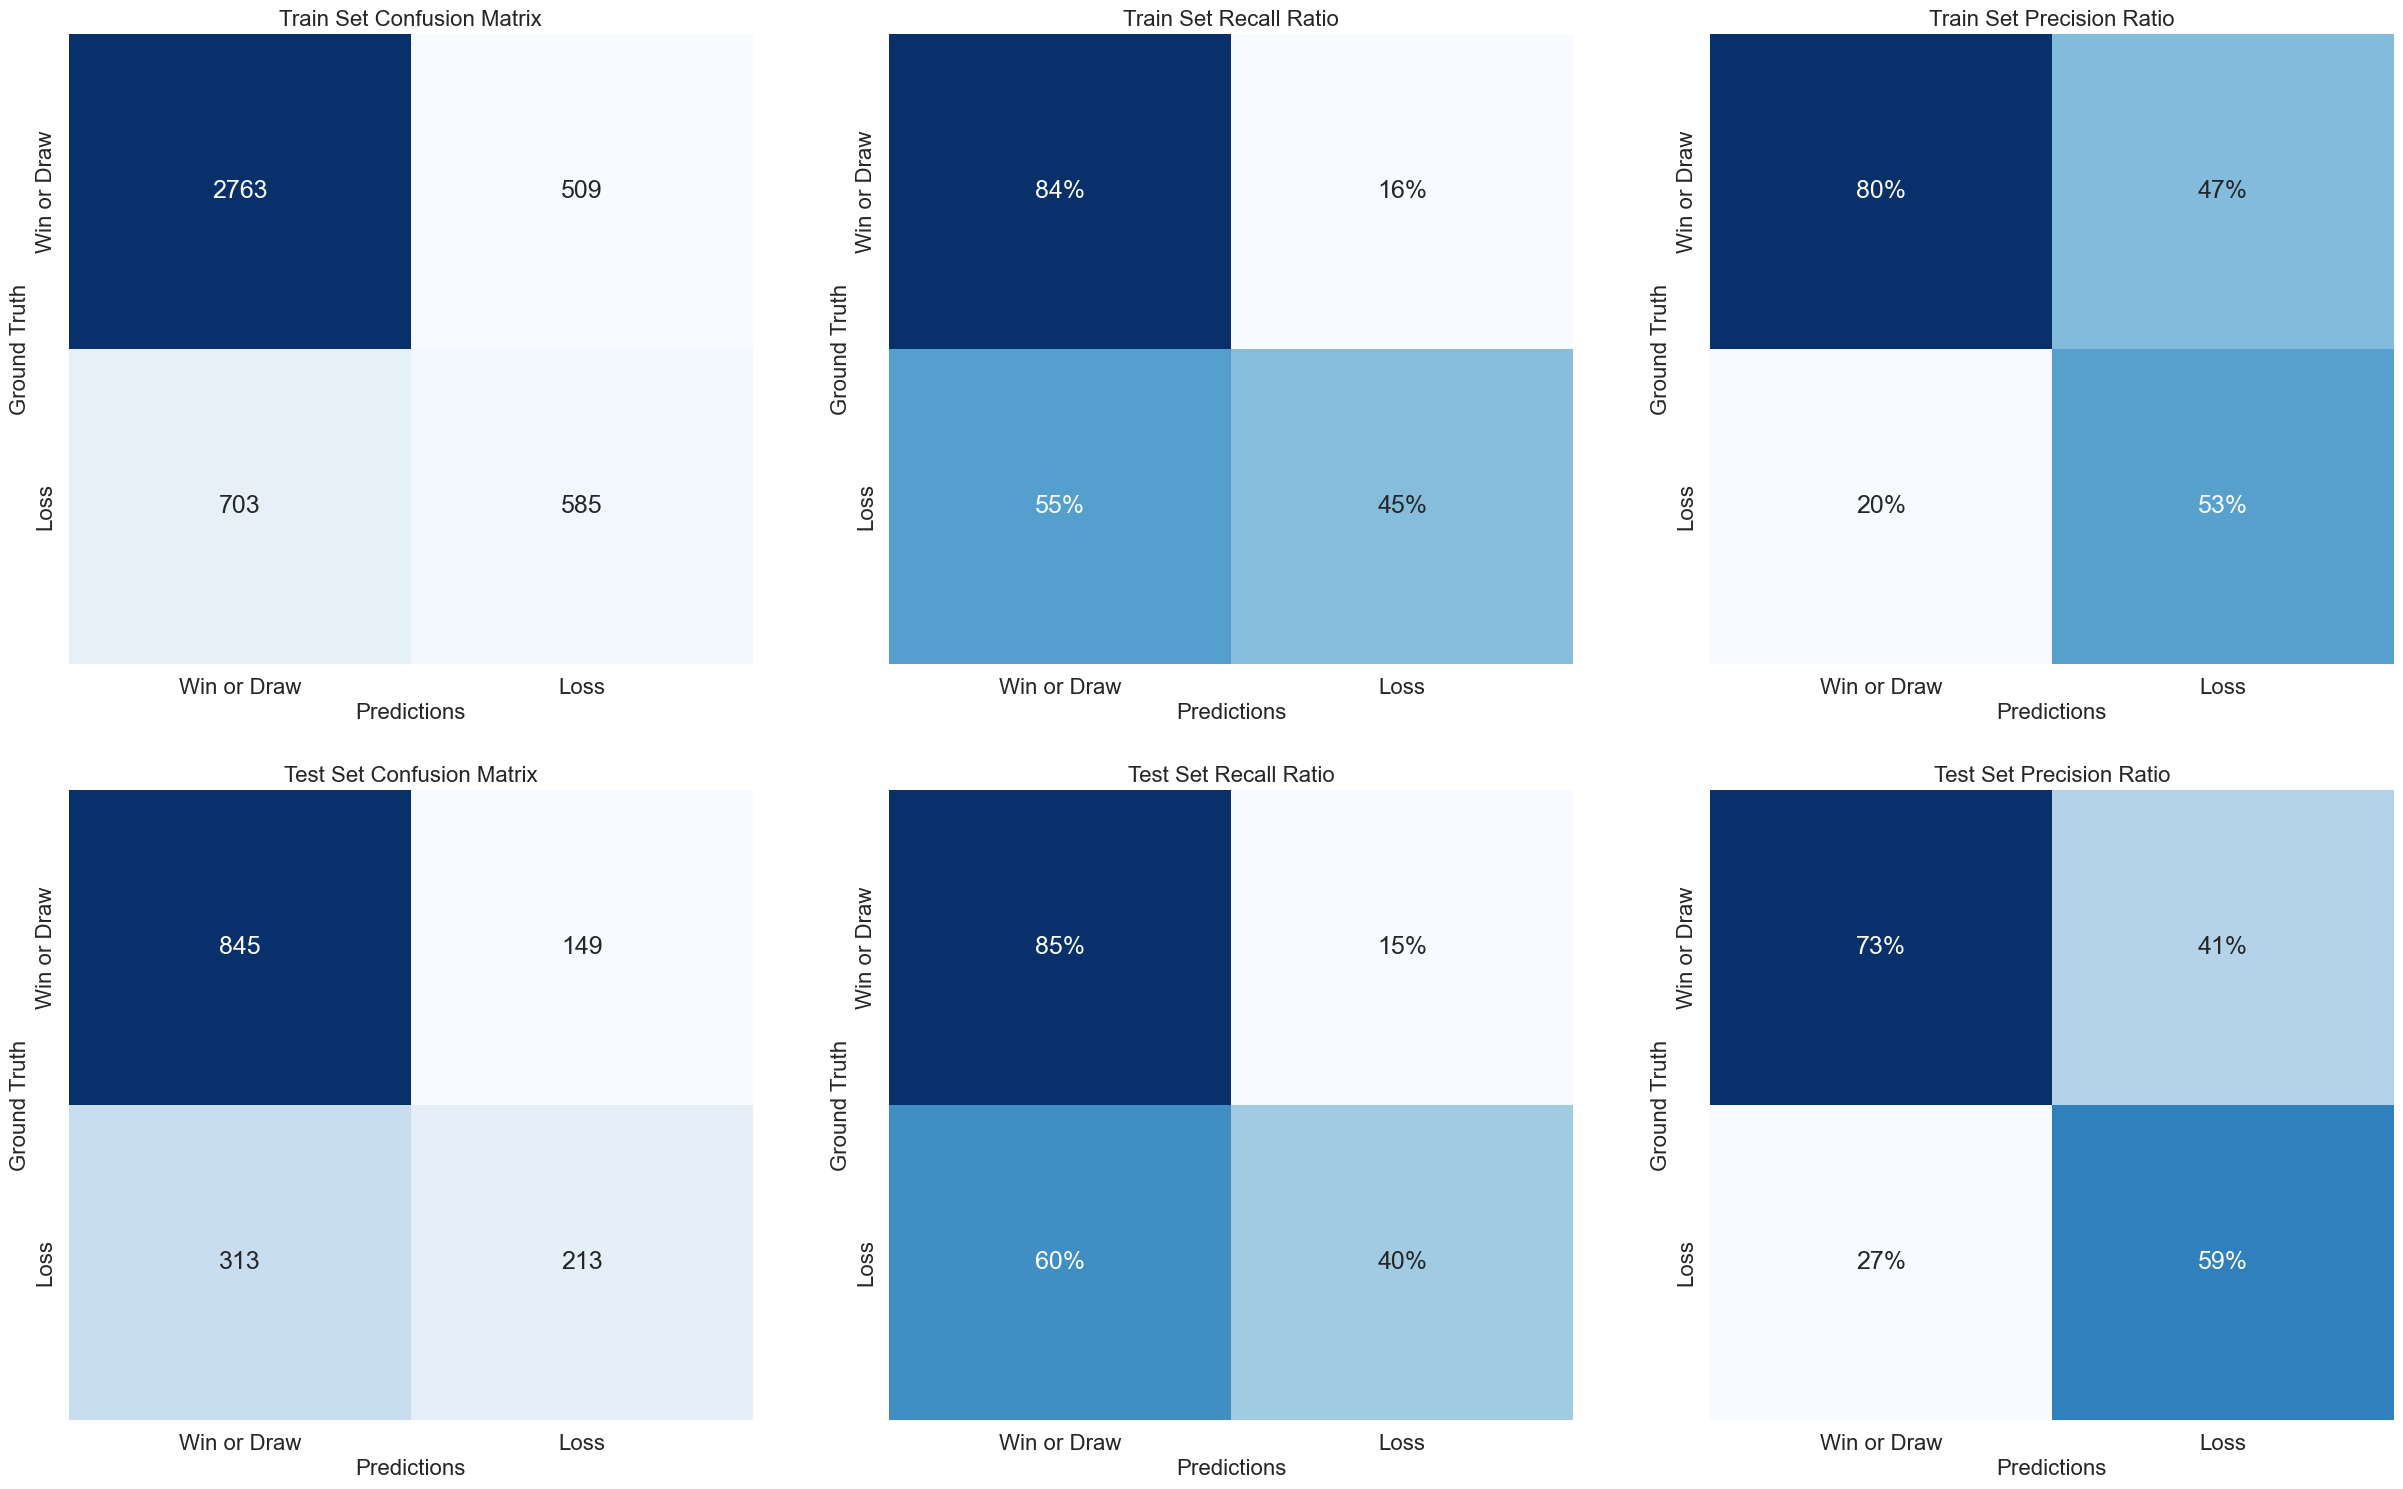

In [46]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = dt_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [47]:
# Calling the function to evaluate the performance of the classifier
dt_model_summary_df = evaluate_model_performance(model = dt_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = "Decision Tree",
                                                 train_threshold = train_threshold,
                                                 test_threshold = test_threshold)
# Displaying the model performance
dt_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Decision Tree       0.72      0.67                     0.65   

               Test Balanced Accuracy  Accuracy  Precision  Recall    F1  \
Decision Tree                    0.63       0.7       0.59     0.4  0.48   

                MCC  Brier Loss  N Features  \
Decision Tree  0.28        0.21         124   

                                                        Pipeline  
Decision Tree  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Random Forest

In [48]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["classifier__criterion"] = skopt.space.Categorical(categories = ["gini", "entropy"])
search_spaces["classifier__max_depth"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["classifier__min_samples_leaf"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__max_features"] = skopt.space.Categorical(categories = [None, "auto", "sqrt", "log2"])

# Building a classifier
rf_model = build_pipeline(classifier = RandomForestClassifier(n_jobs = -1, random_state = 42), 
                          apply_feature_selection = True,
                          feature_selection_type = "meta",
                          apply_bayesian_optimization = True,
                          hyperparameters = search_spaces,
                          n_iterations = 100,
                          train_features = X_train, 
                          train_labels = y_train, 
                          verbosity = 1)

# Logging information to the log file
logging.info(msg = "Random Forest model has been built")

# Displaying the architecture of the classifier
rf_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1,
                                                                  random_state=42))),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=6,
                                        max_features='sqrt', min_samples_leaf=6,
                                        min_samples_split=3, n_estimators=101,
                                        n_jobs=-1, random_state=42))])

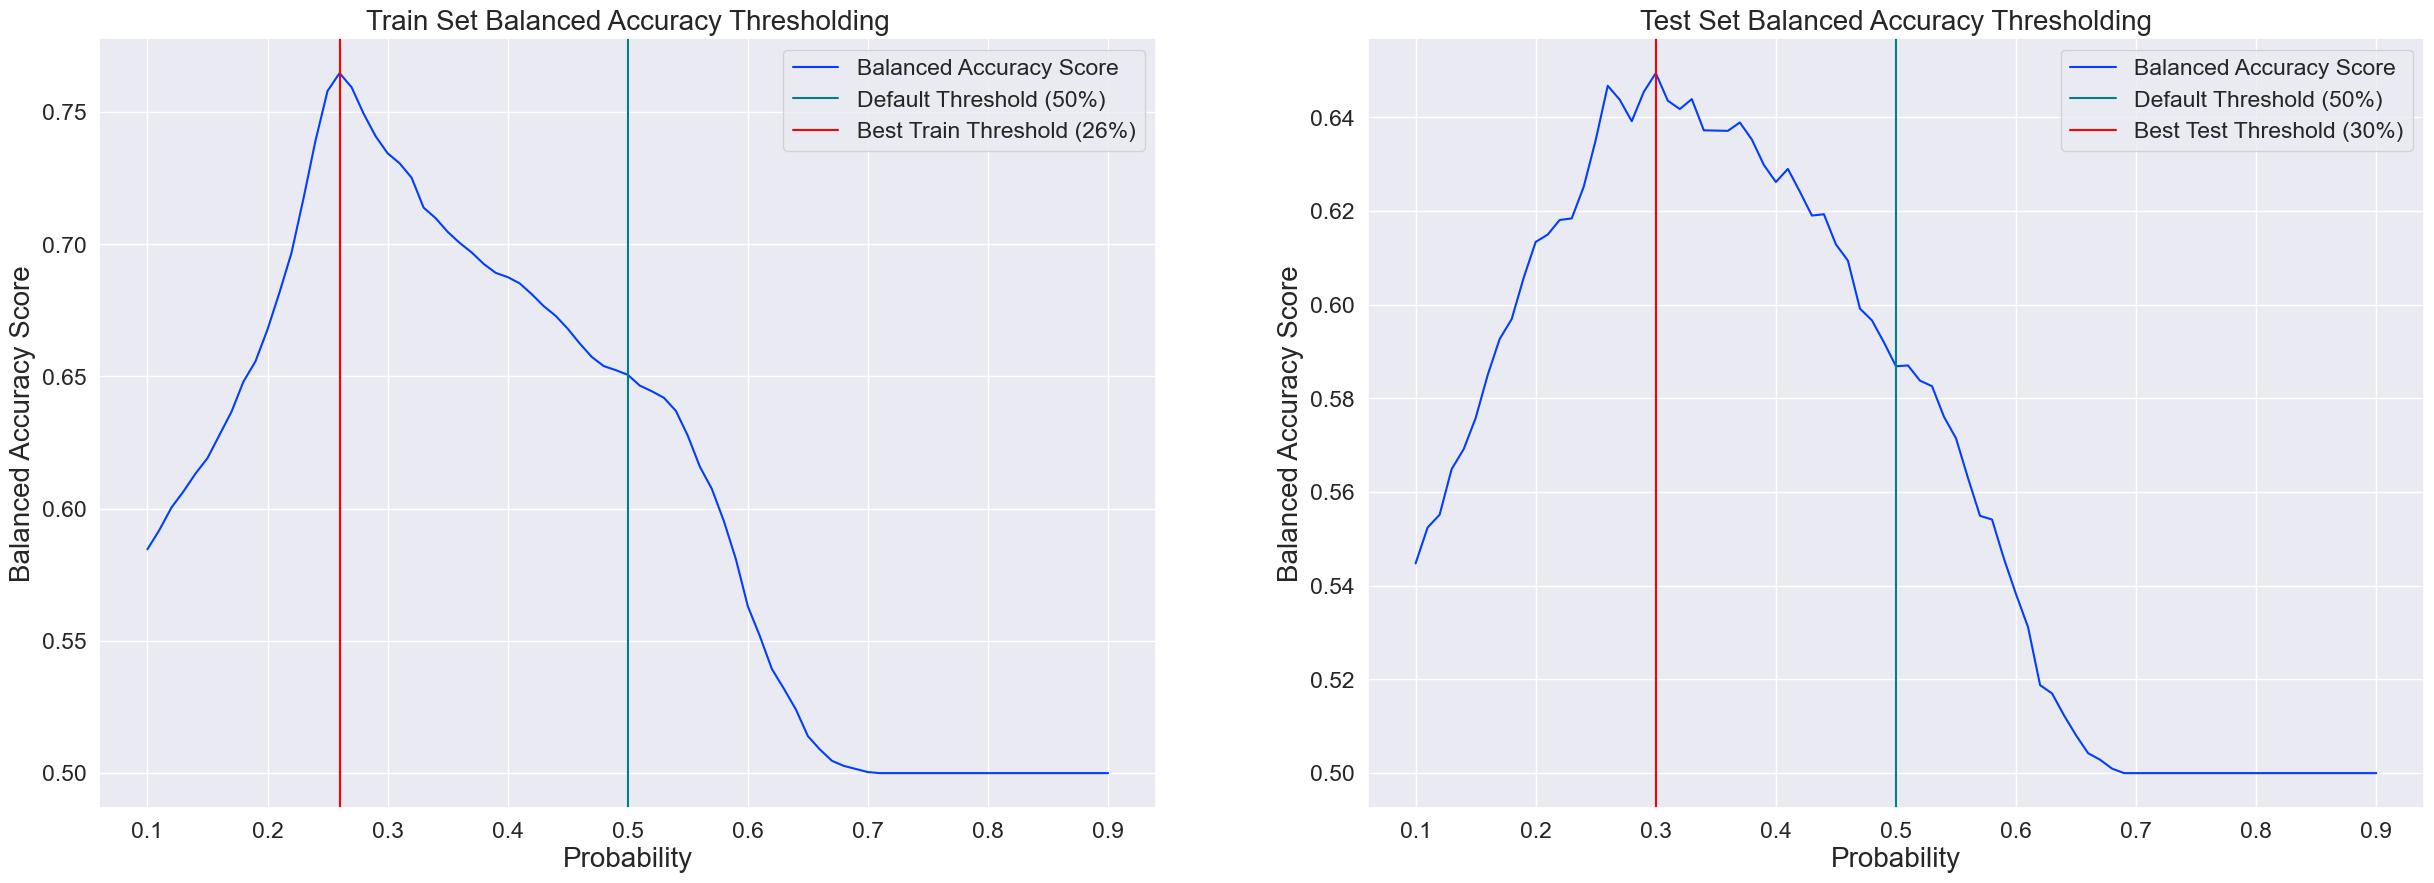

In [49]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = rf_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [50]:
# Calling the function to print out the classification report
print_classification_report(model = rf_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Random Forest")

Classification Report Summary for Random Forest Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.92      0.69      0.79      3272
        Loss       0.51      0.84      0.64      1288

    accuracy                           0.73      4560
   macro avg       0.72      0.76      0.71      4560
weighted avg       0.80      0.73      0.74      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.76      0.71      0.74       994
        Loss       0.52      0.59      0.55       526

    accuracy                           0.67      1520
   macro avg       0.64      0.65      0.64      1520
weighted avg       0.68      0.67      0.67      1520



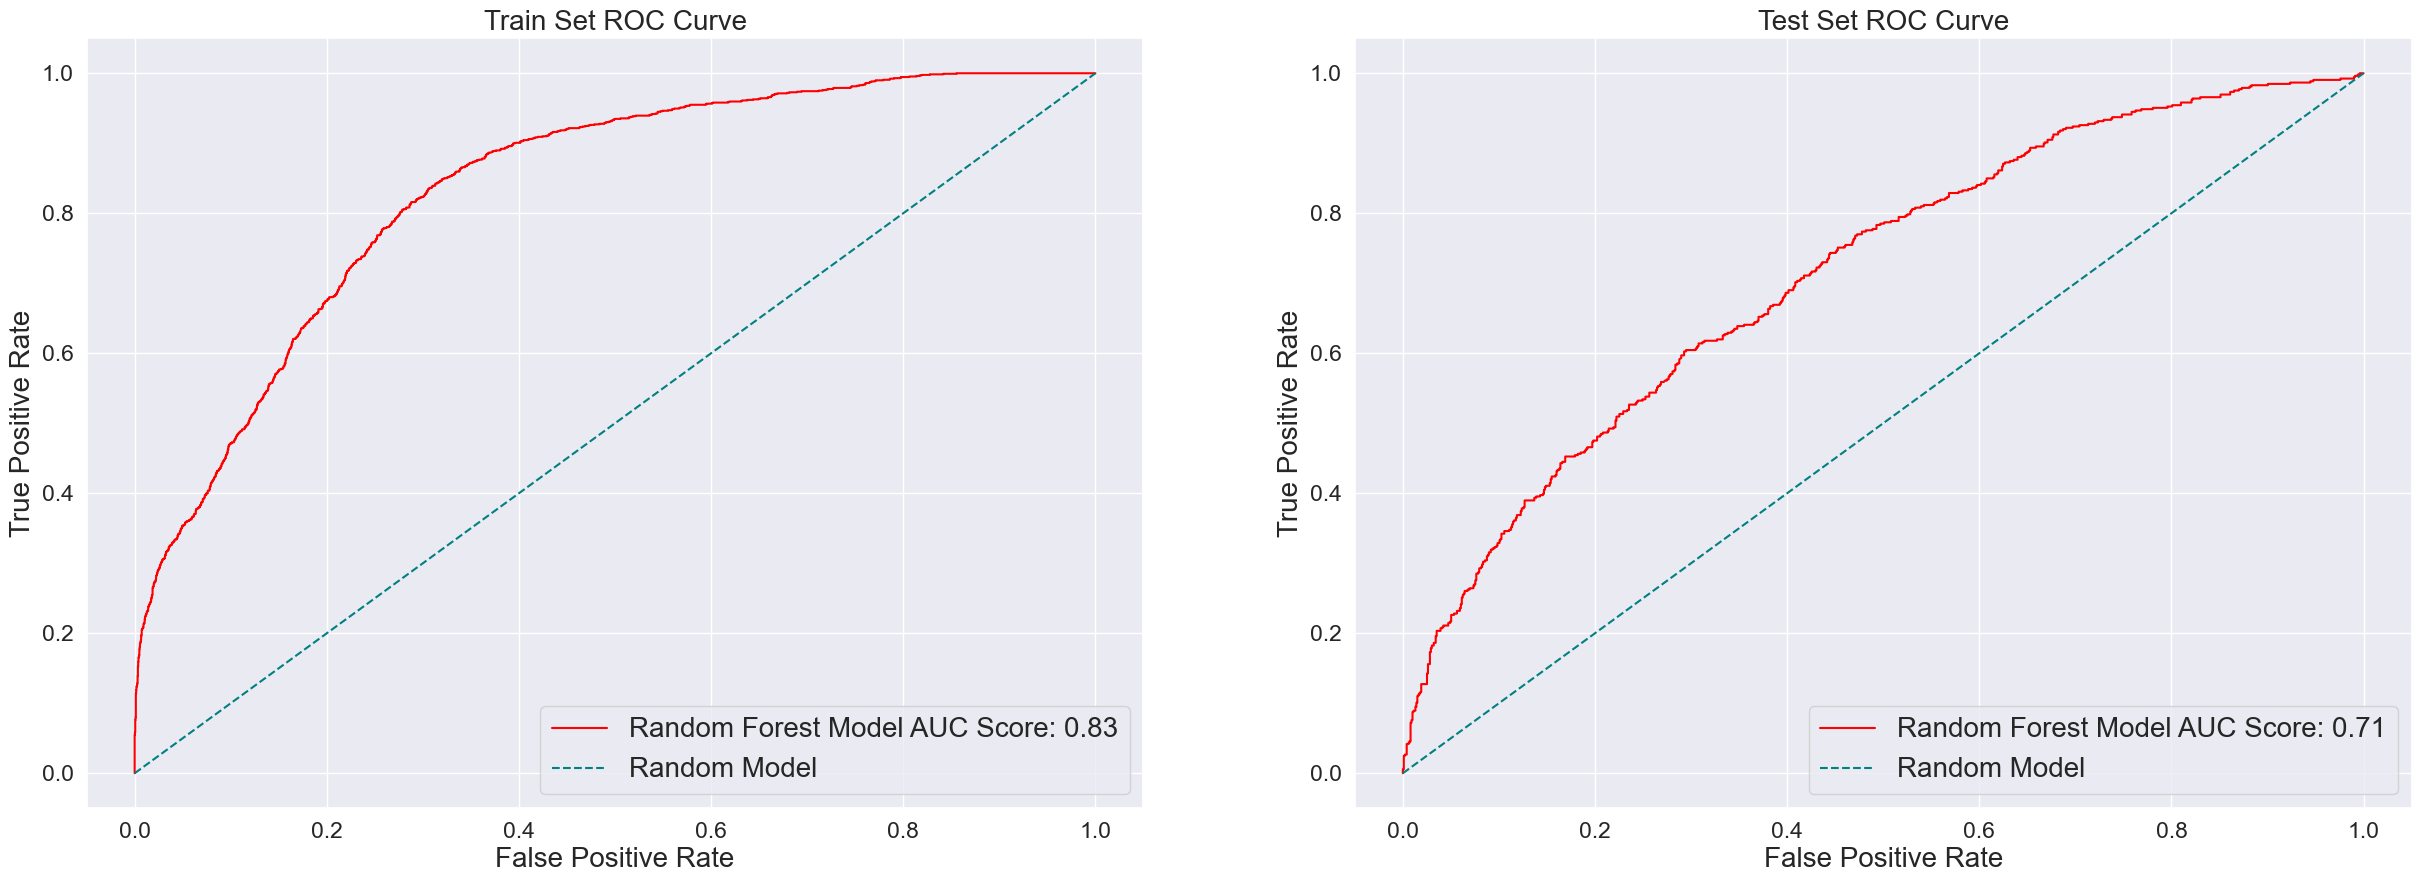

In [51]:
# Calling the function to plot ROC curve
plot_roc_curve(model = rf_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Random Forest")

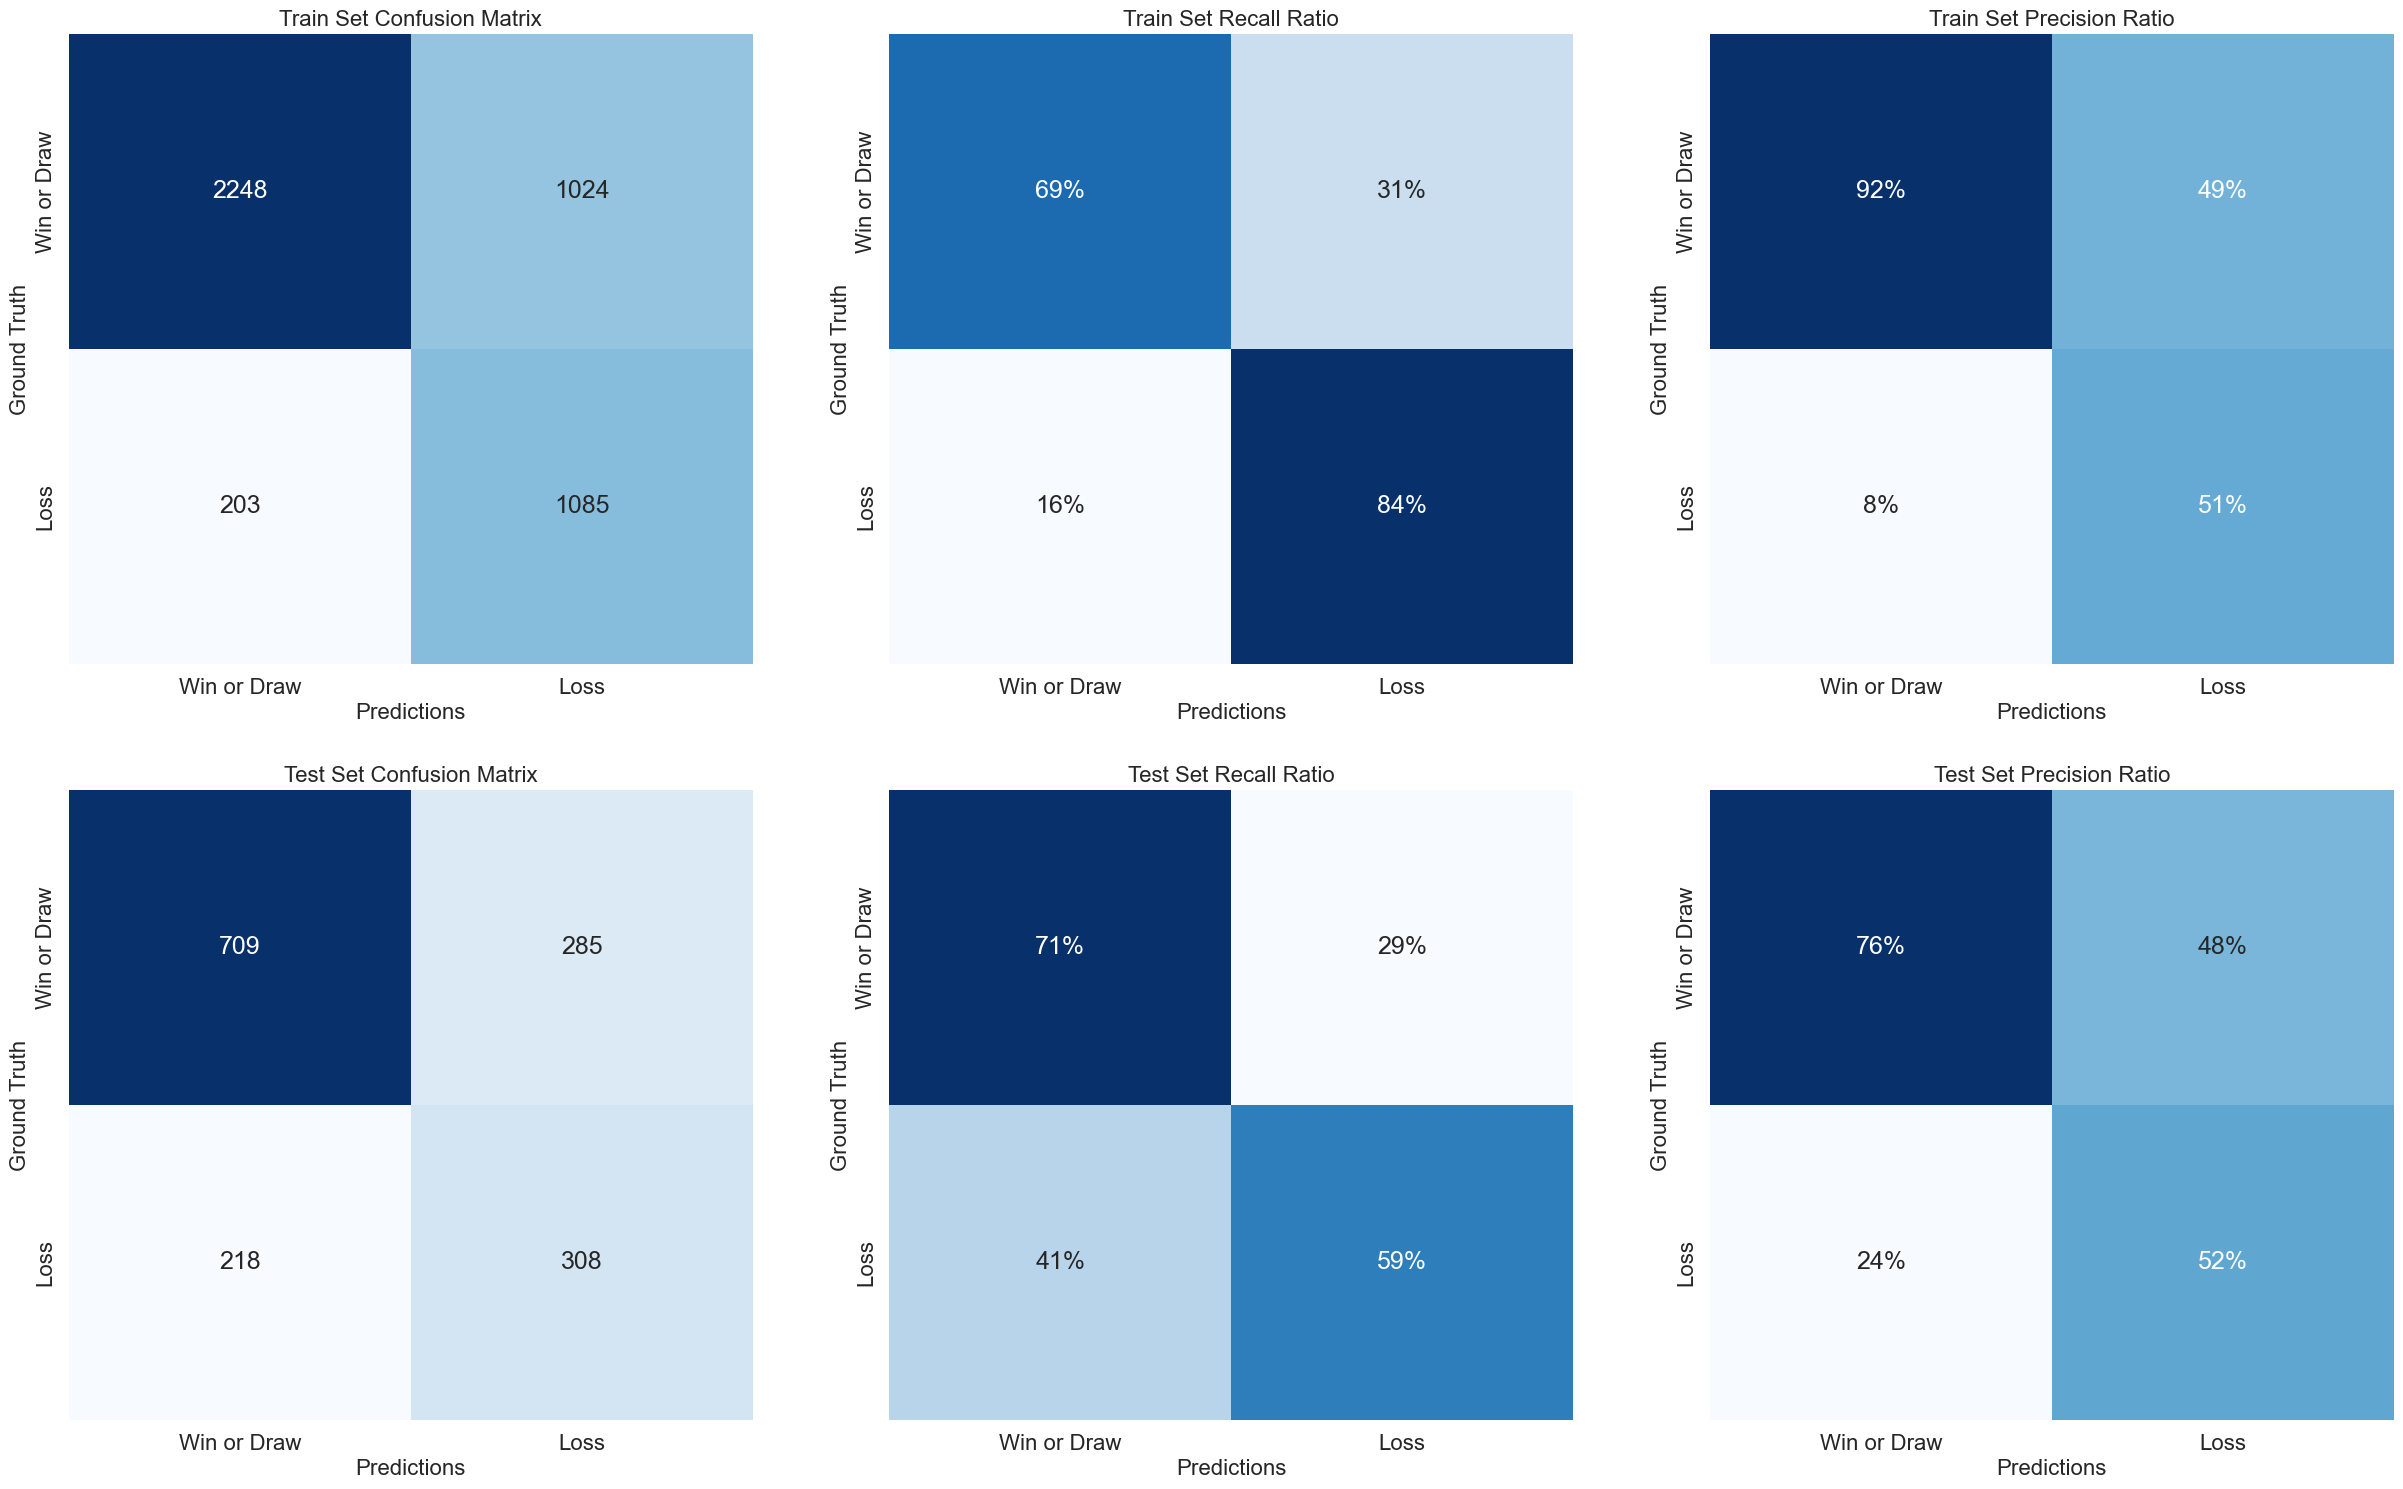

In [52]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = rf_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [53]:
# Calling the function to evaluate the performance of the classifier
rf_model_summary_df = evaluate_model_performance(model = rf_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = "Random Forest",
                                                 train_threshold = train_threshold,
                                                 test_threshold = test_threshold)
# Displaying the model performance
rf_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Random Forest       0.83      0.71                     0.76   

               Test Balanced Accuracy  Accuracy  Precision  Recall    F1  \
Random Forest                    0.65      0.67       0.52    0.59  0.55   

                MCC  Brier Loss  N Features  \
Random Forest  0.29         0.2         145   

                                                        Pipeline  
Random Forest  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Light Gradient Boosted Machine (LightGBM)

In [54]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__max_depth"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__learning_rate"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["classifier__reg_alpha"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__reg_lambda"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")

# Building a classifier
lgbm_model = build_pipeline(classifier = LGBMClassifier(objective = "binary", random_state = 42, n_jobs = -1),  
                            apply_feature_selection = True,
                            feature_selection_type = "meta",
                            apply_bayesian_optimization = True,
                            hyperparameters = search_spaces,
                            n_iterations = 100,
                            train_features = X_train, 
                            train_labels = y_train, 
                            verbosity = 1)

# Logging information to the log file
logging.info(msg = "Light Gradient Boosted Machine model has been built")
 
# Displaying the architecture of the classifier
lgbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=LGBMClassifier(objective='binary',
                                                          random_state=42),
                                 threshold='median')),
                ('classifier',
                 LGBMClassifier(learning_rate=0.0366759486034943, max_depth=2,
                                objective='binary', random_state=42,
                                reg_alpha=0.1,
                                reg_lambda=3.826892367345844e-07))])

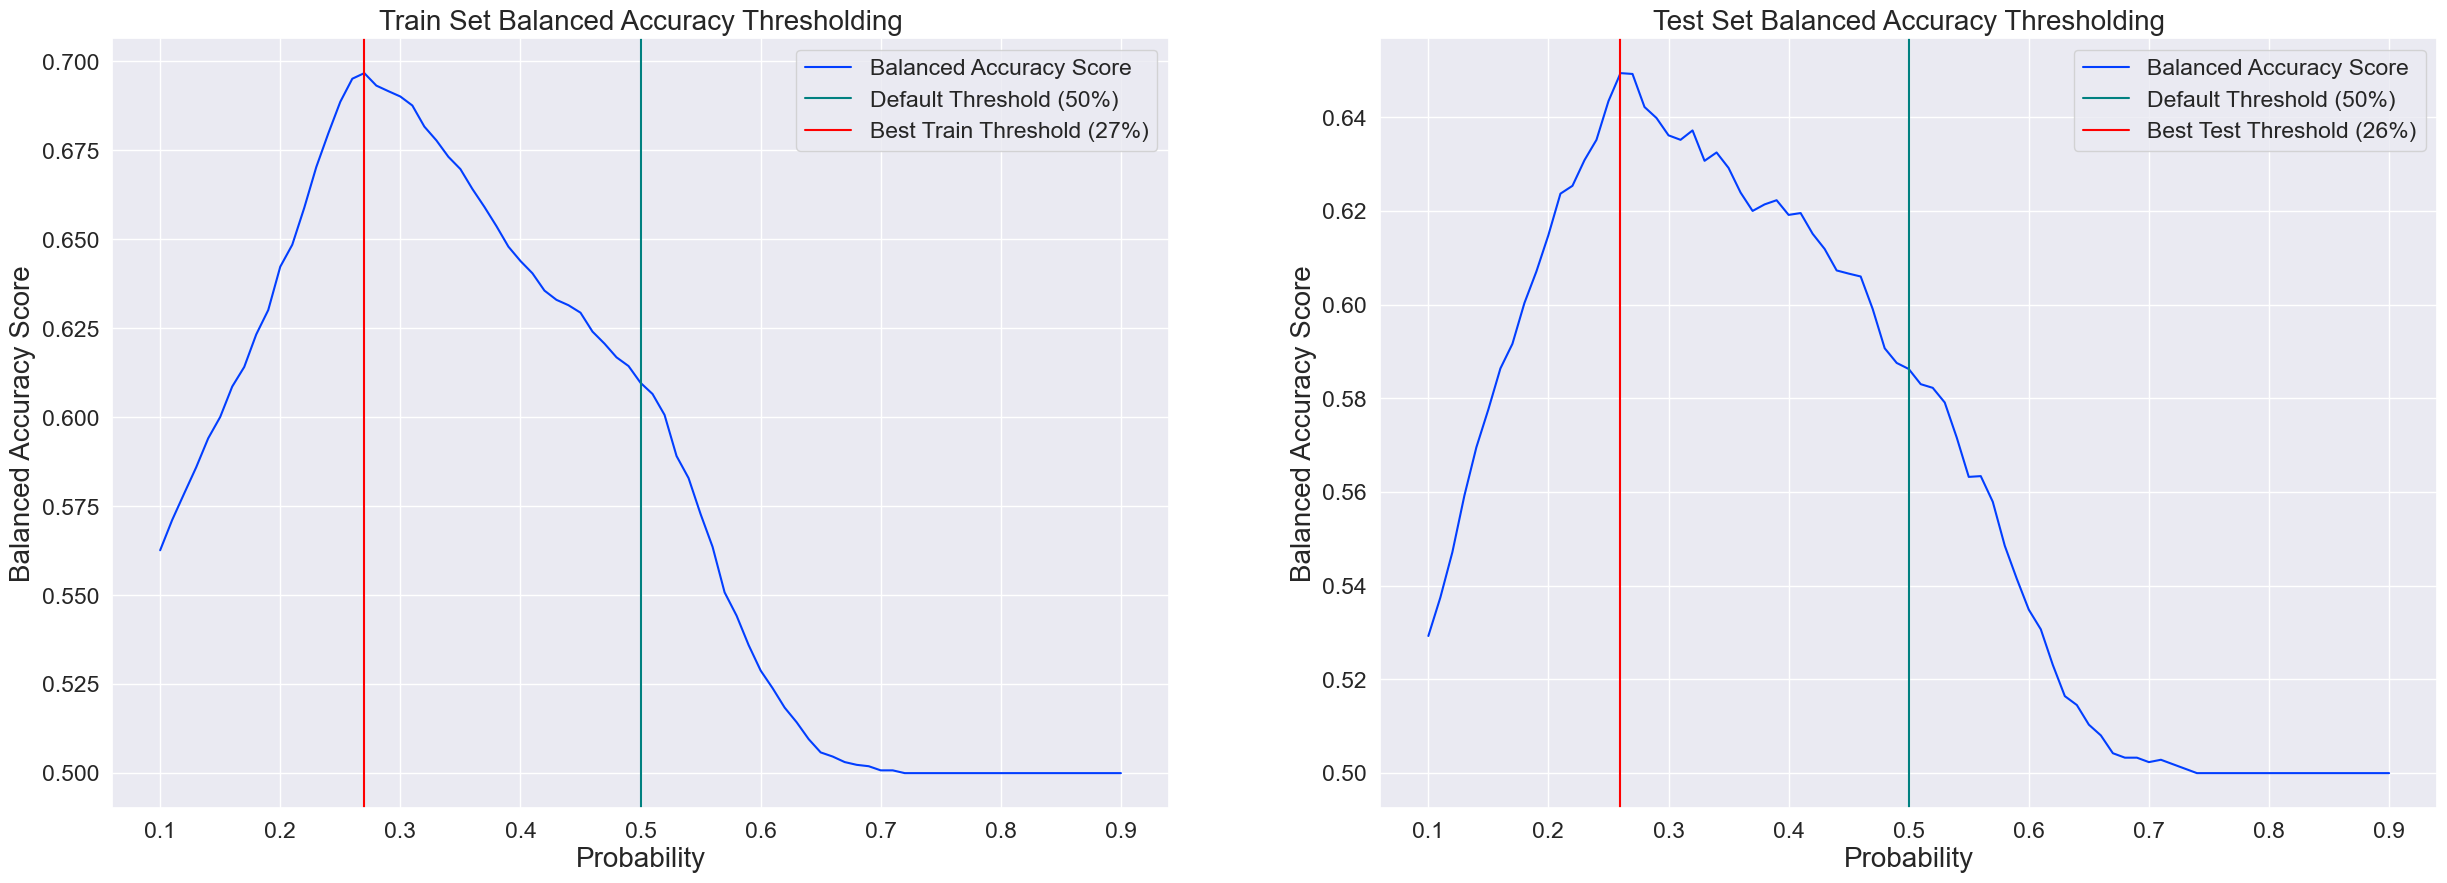

In [55]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = lgbm_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [56]:
# Calling the function to print out the classification report
print_classification_report(model = lgbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Light Gradient Boosted Machine")

Classification Report Summary for Light Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.86      0.68      0.76      3272
        Loss       0.47      0.72      0.56      1288

    accuracy                           0.69      4560
   macro avg       0.66      0.70      0.66      4560
weighted avg       0.75      0.69      0.70      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.81      0.53      0.64       994
        Loss       0.46      0.77      0.58       526

    accuracy                           0.61      1520
   macro avg       0.64      0.65      0.61      1520
weighted avg       0.69      0.61      0.62      1520



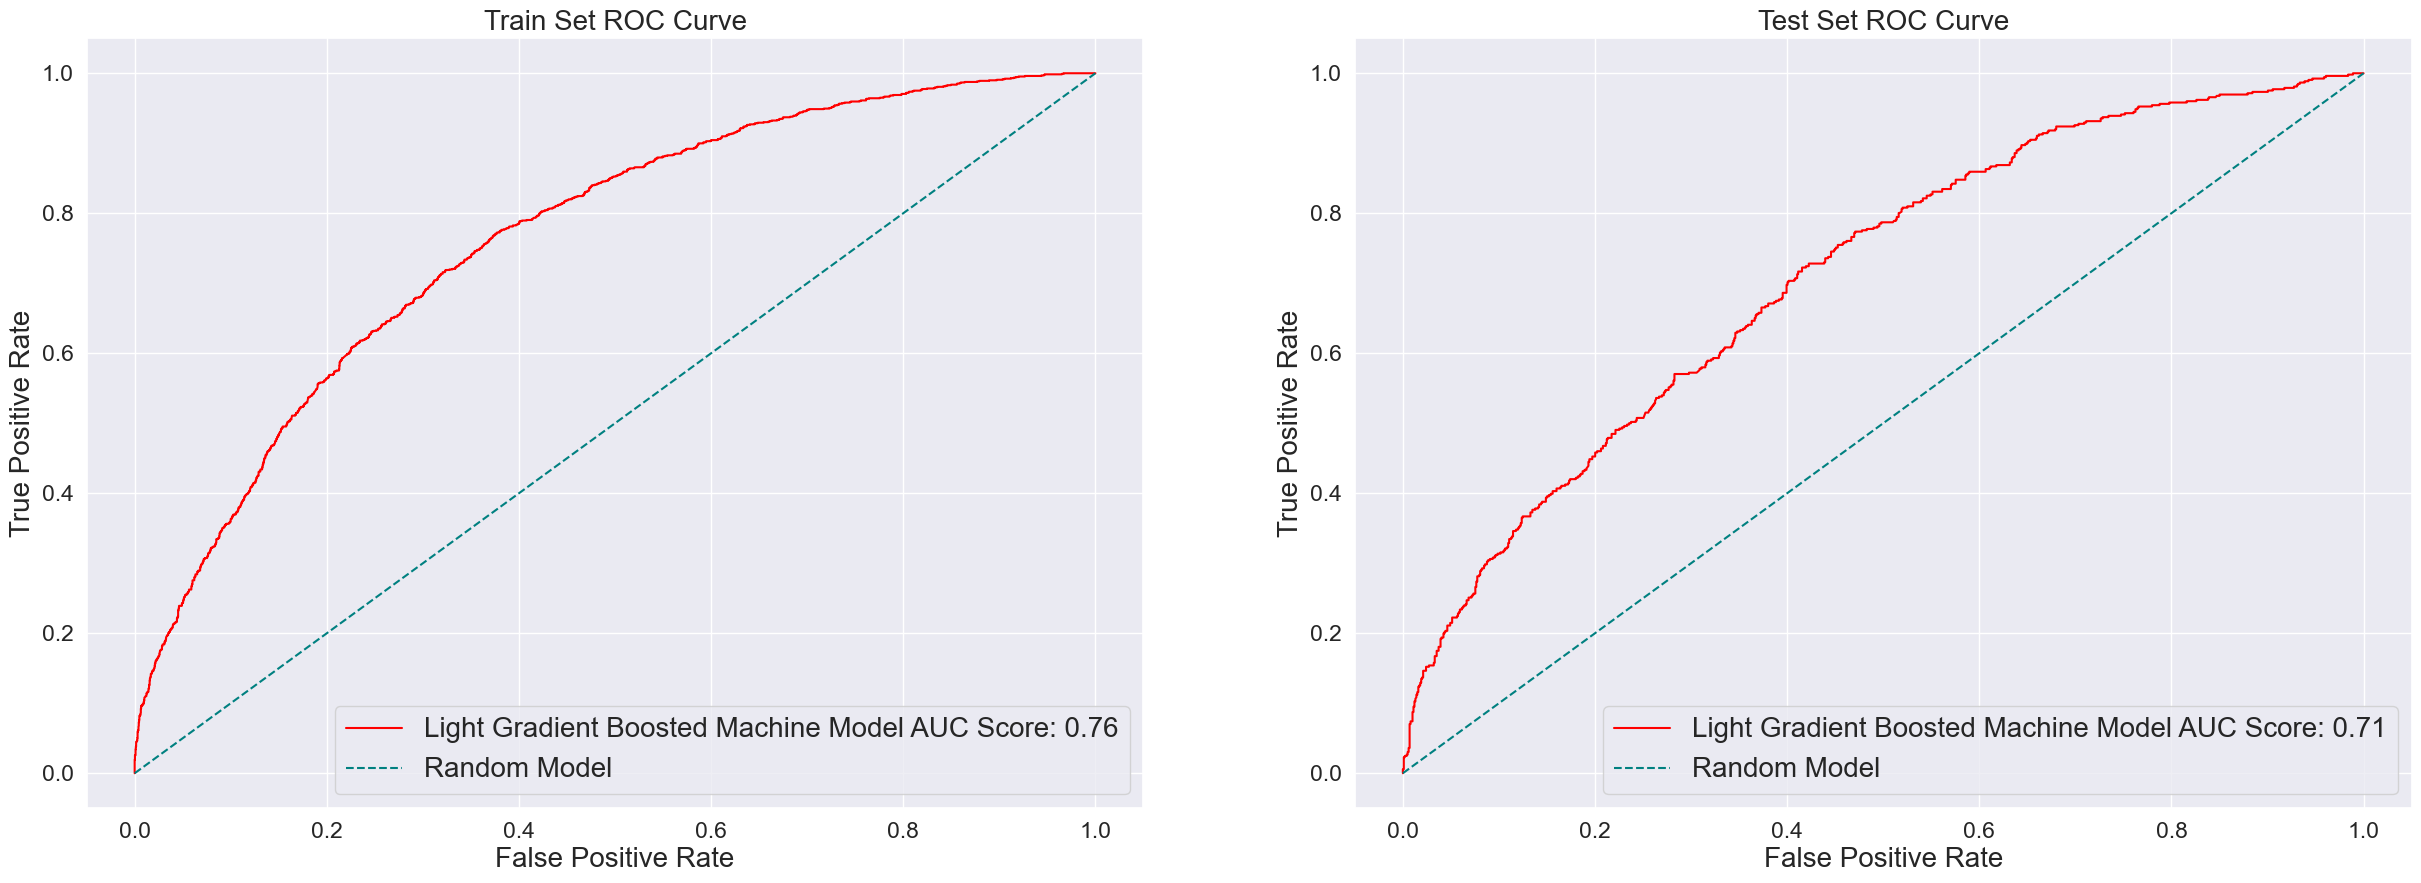

In [57]:
# Calling the function to plot ROC curve
plot_roc_curve(model = lgbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Light Gradient Boosted Machine")

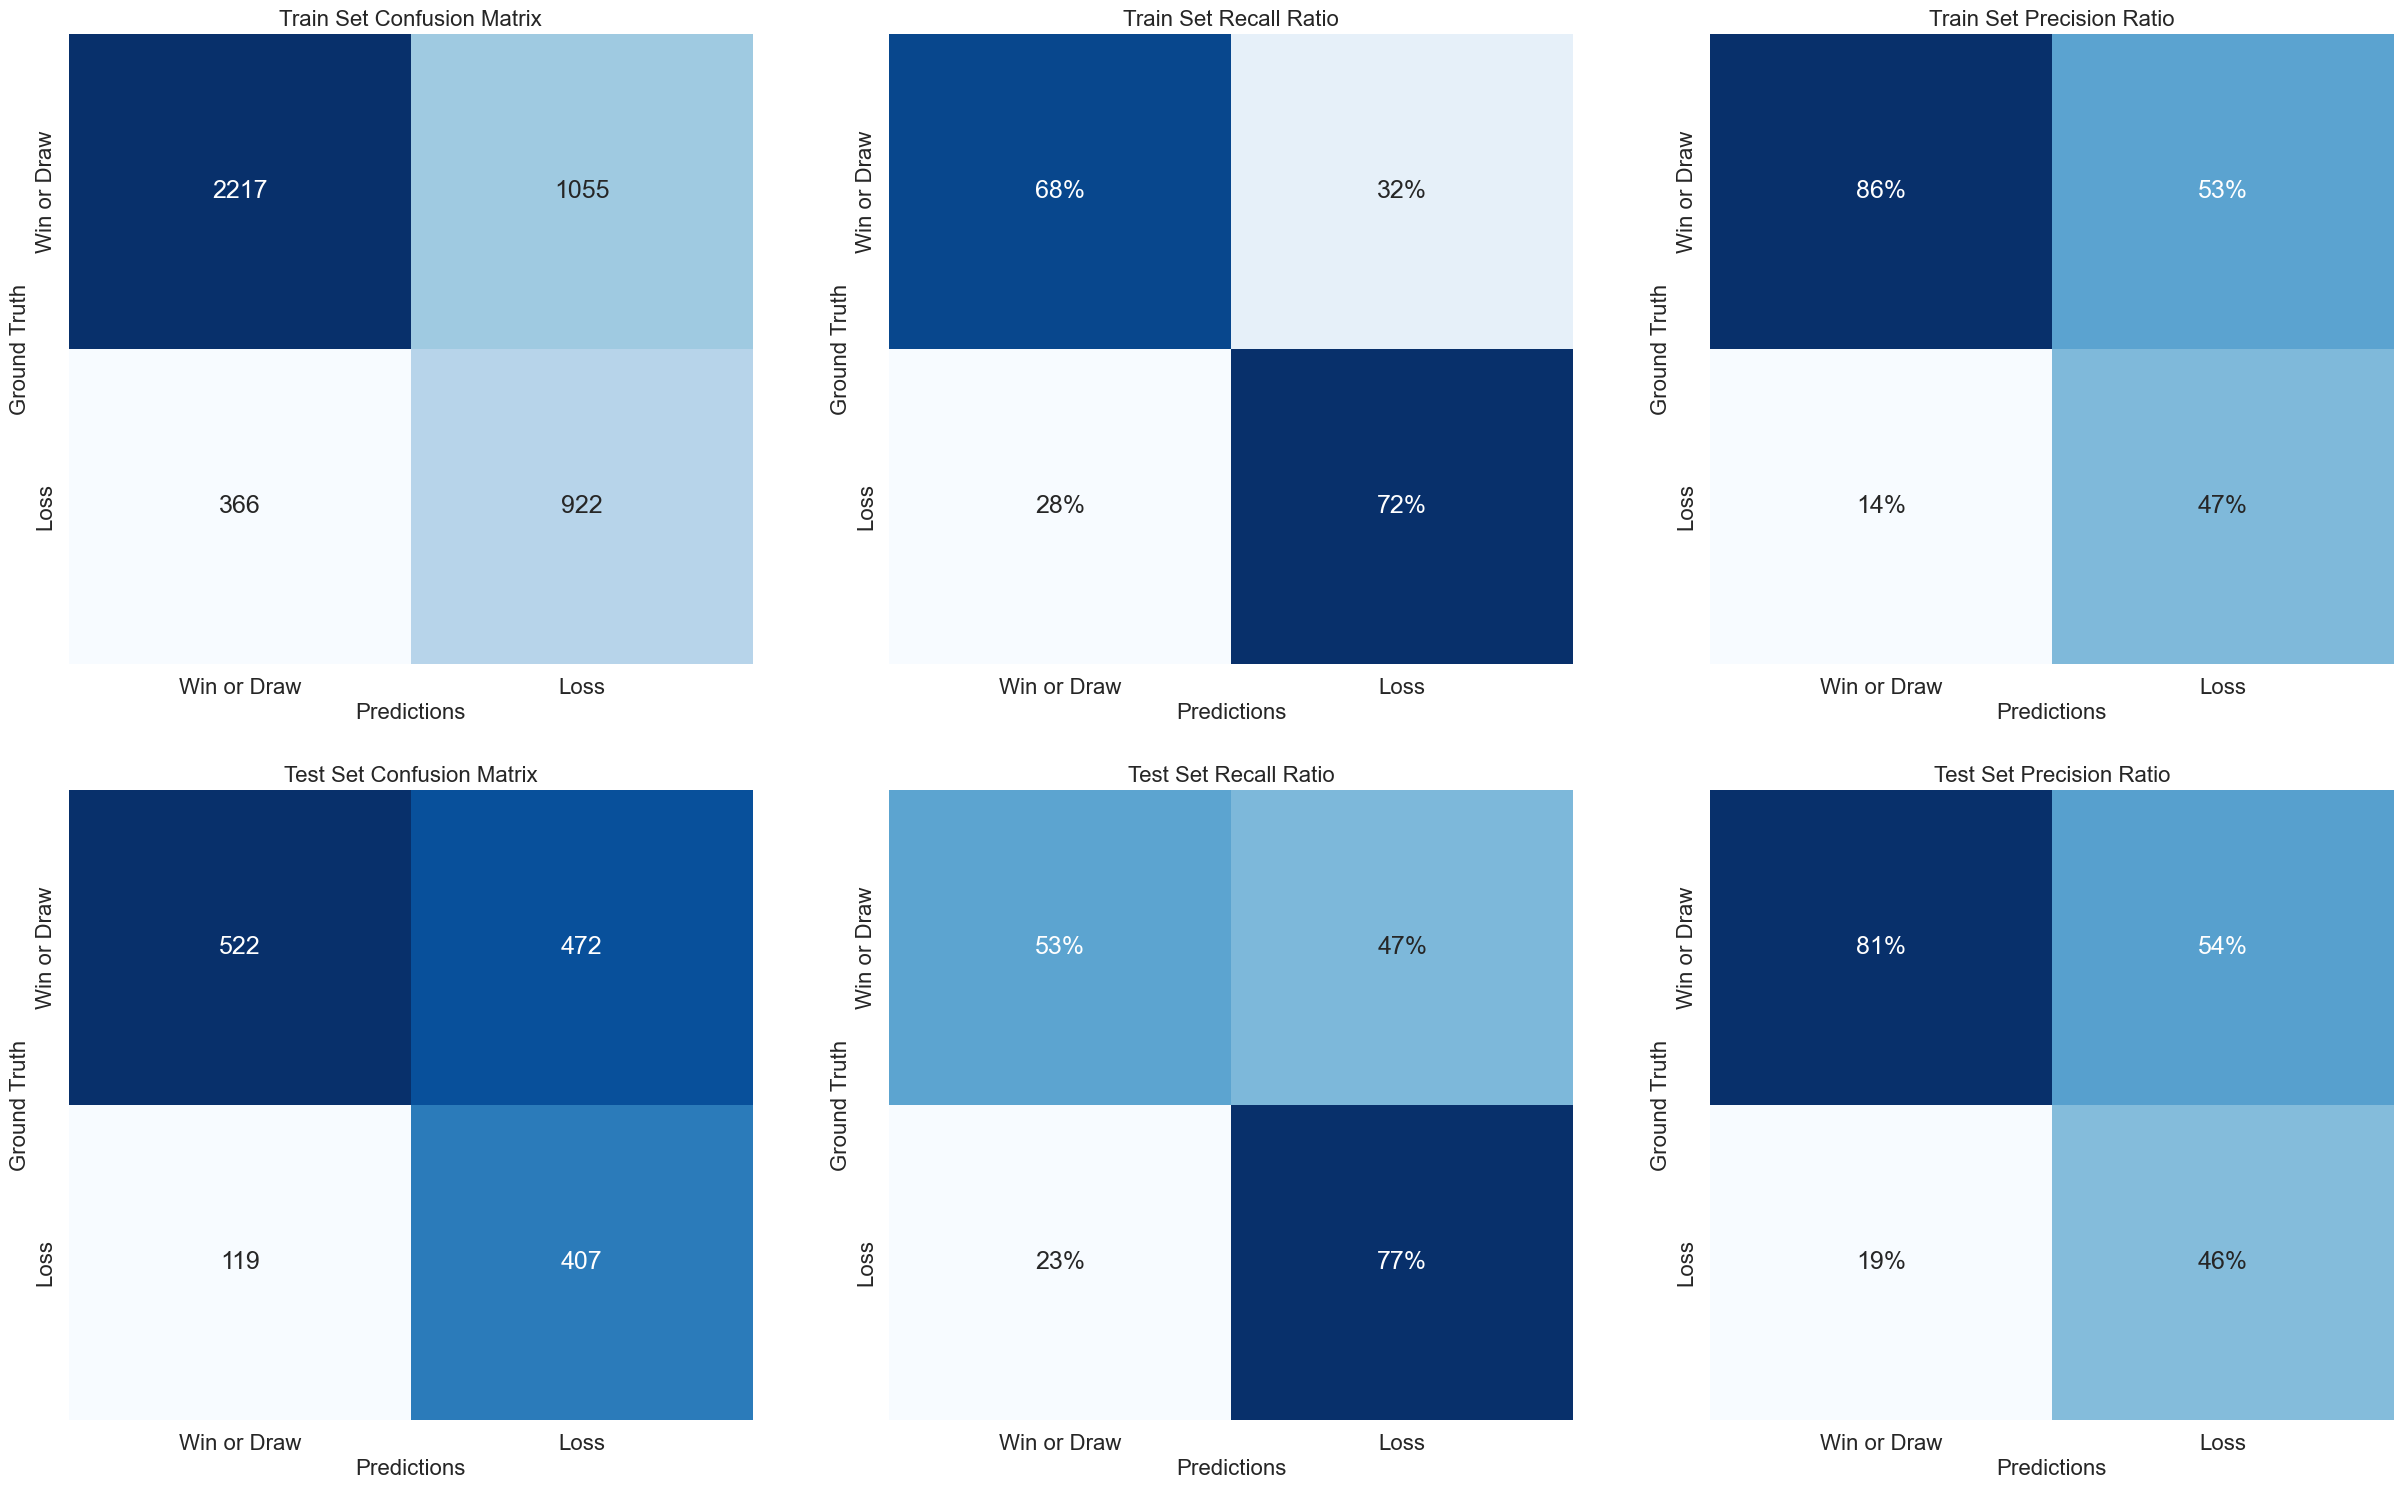

In [58]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = lgbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [59]:
# Calling the function to evaluate the performance of the classifier
lgbm_model_summary_df = evaluate_model_performance(model = lgbm_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = "Light Gradient Boosted Machine",
                                                   train_threshold = train_threshold,
                                                   test_threshold = test_threshold)
# Displaying the model performance
lgbm_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Light Gradient Boosted Machine       0.76      0.71                      0.7   

                                Test Balanced Accuracy  Accuracy  Precision  \
Light Gradient Boosted Machine                    0.65      0.61       0.46   

                                Recall    F1   MCC  Brier Loss  N Features  \
Light Gradient Boosted Machine    0.77  0.58  0.29         0.2         156   

                                                                         Pipeline  
Light Gradient Boosted Machine  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Adaptive Boosting (ADABoost)

In [60]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__n_estimators"] = skopt.space.Integer(low = 50, high = 300)
search_spaces["classifier__learning_rate"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")

# Building a classifier
ada_model = build_pipeline(classifier = AdaBoostClassifier(random_state = 42), 
                           apply_feature_selection = True,
                           feature_selection_type = "meta",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           train_features = X_train, 
                           train_labels = y_train, 
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "Adaptive Boosting model has been built")
 
# Displaying the architecture of the classifier
ada_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=42),
                                 threshold='median')),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.07950782630013725,
                                    n_estimators=80, random_state=42))])

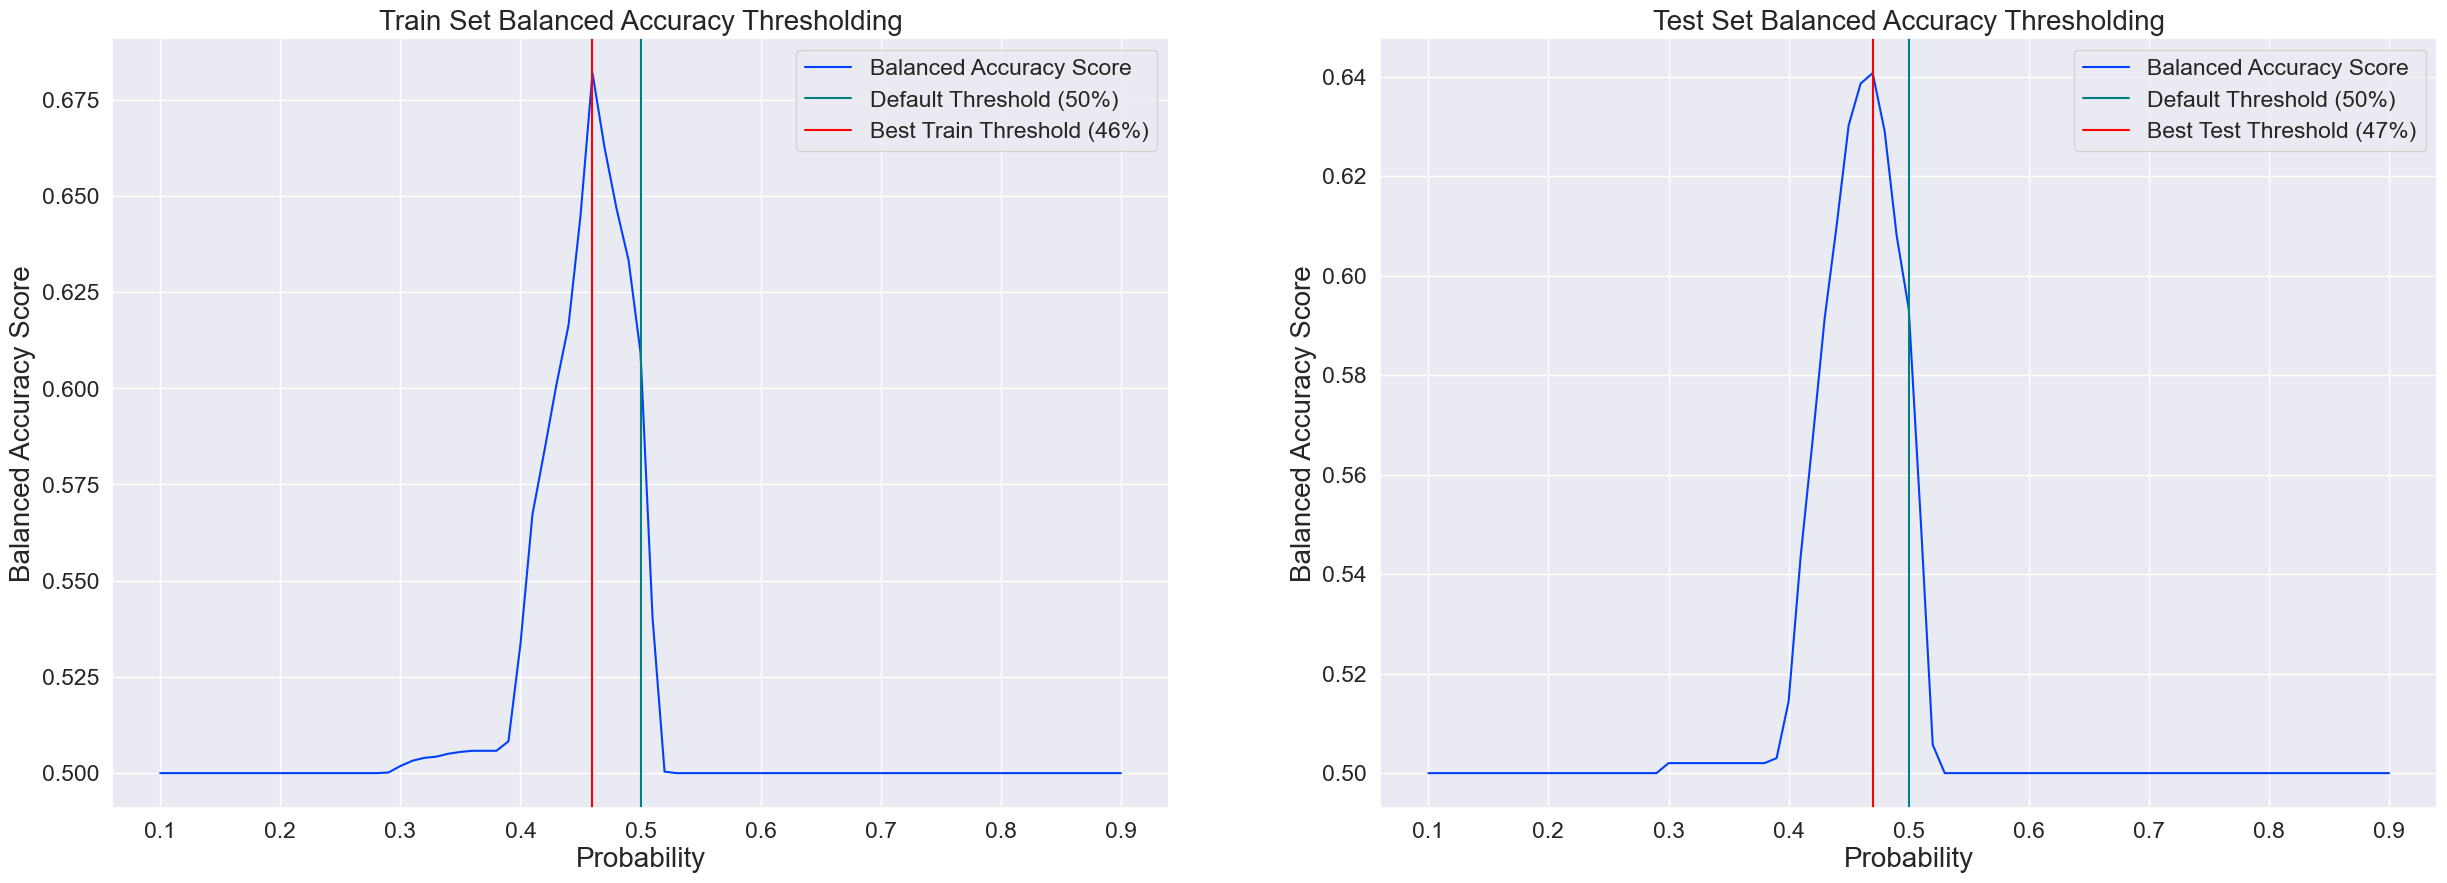

In [61]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = ada_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [62]:
# Calling the function to print out the classification report
print_classification_report(model = ada_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Adaptive Boosting")

Classification Report Summary for Adaptive Boosting Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.85      0.66      0.74      3272
        Loss       0.45      0.71      0.55      1288

    accuracy                           0.67      4560
   macro avg       0.65      0.68      0.65      4560
weighted avg       0.74      0.67      0.69      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.75      0.78      0.76       994
        Loss       0.54      0.51      0.52       526

    accuracy                           0.68      1520
   macro avg       0.65      0.64      0.64      1520
weighted avg       0.68      0.68      0.68      1520



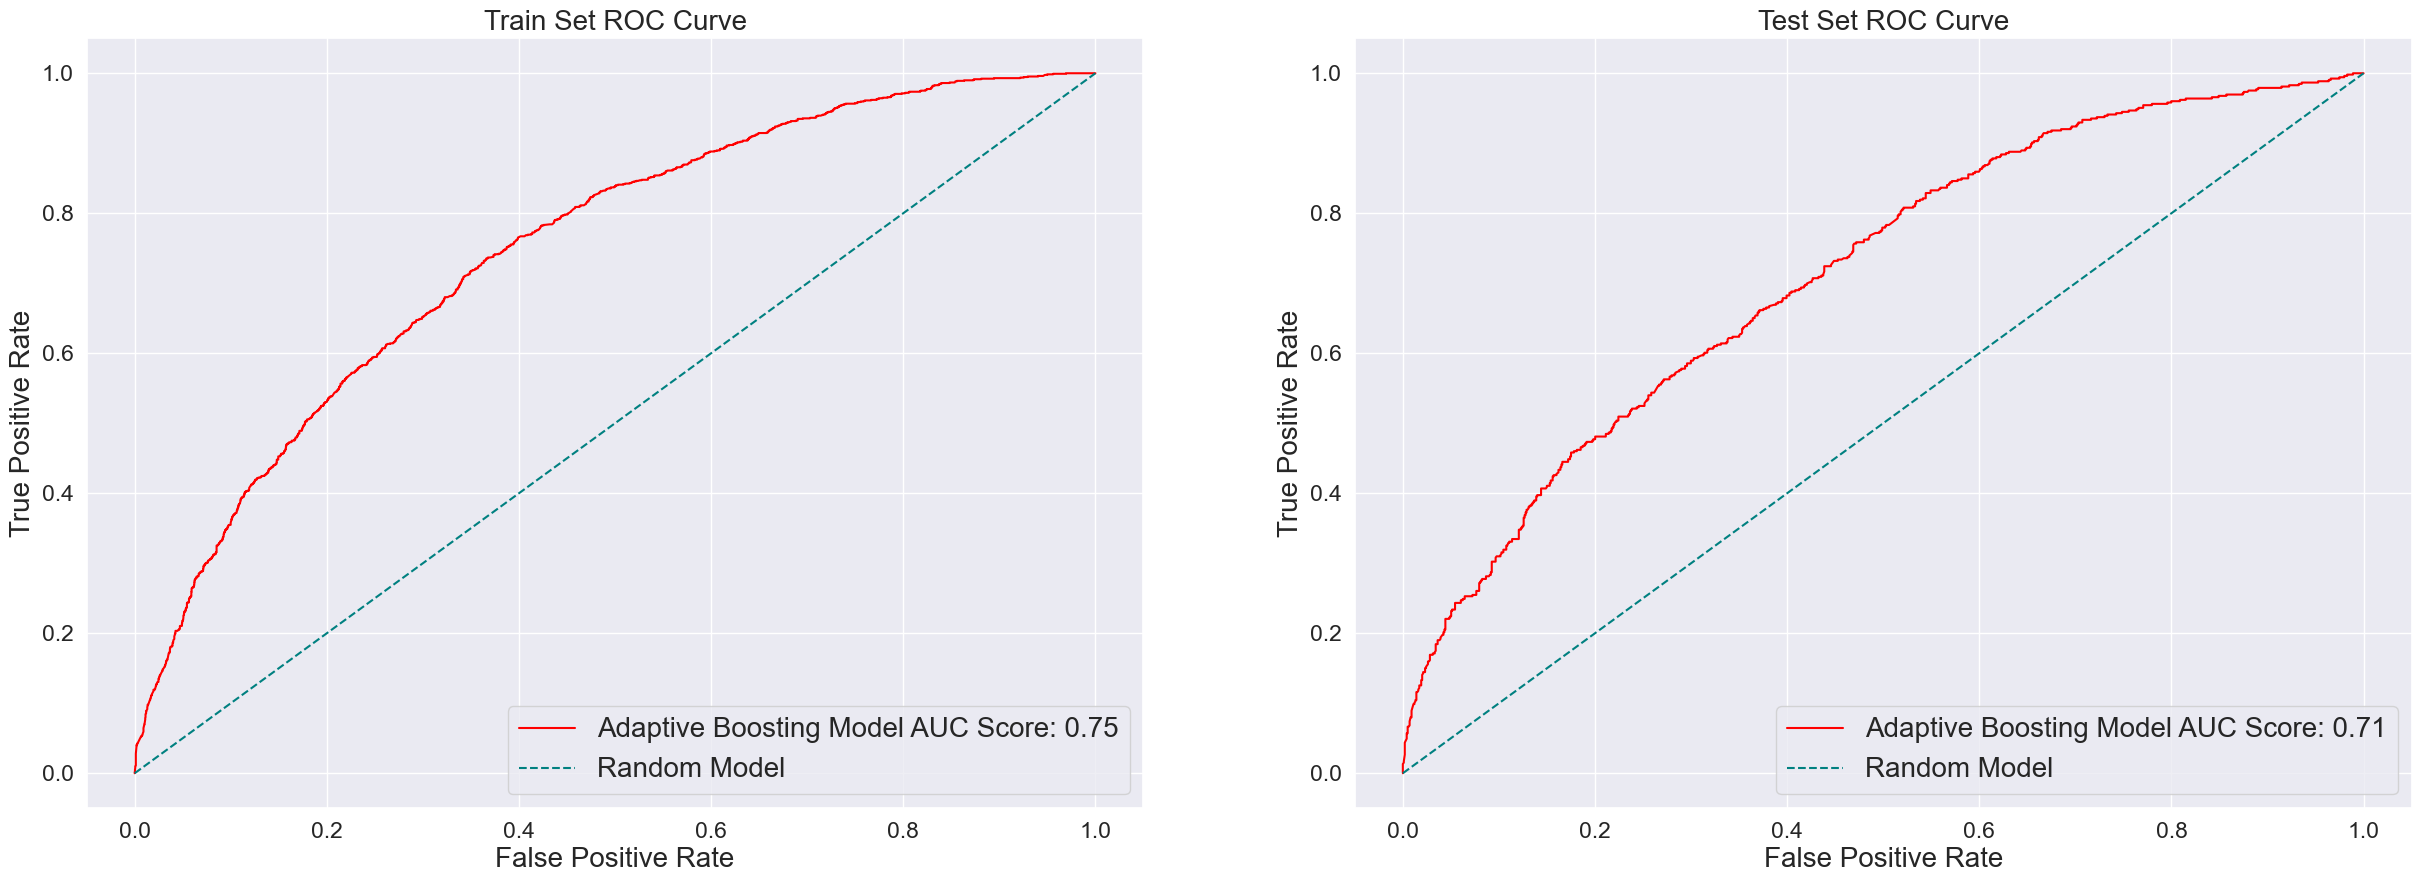

In [63]:
# Calling the function to plot ROC curve
plot_roc_curve(model = ada_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Adaptive Boosting")

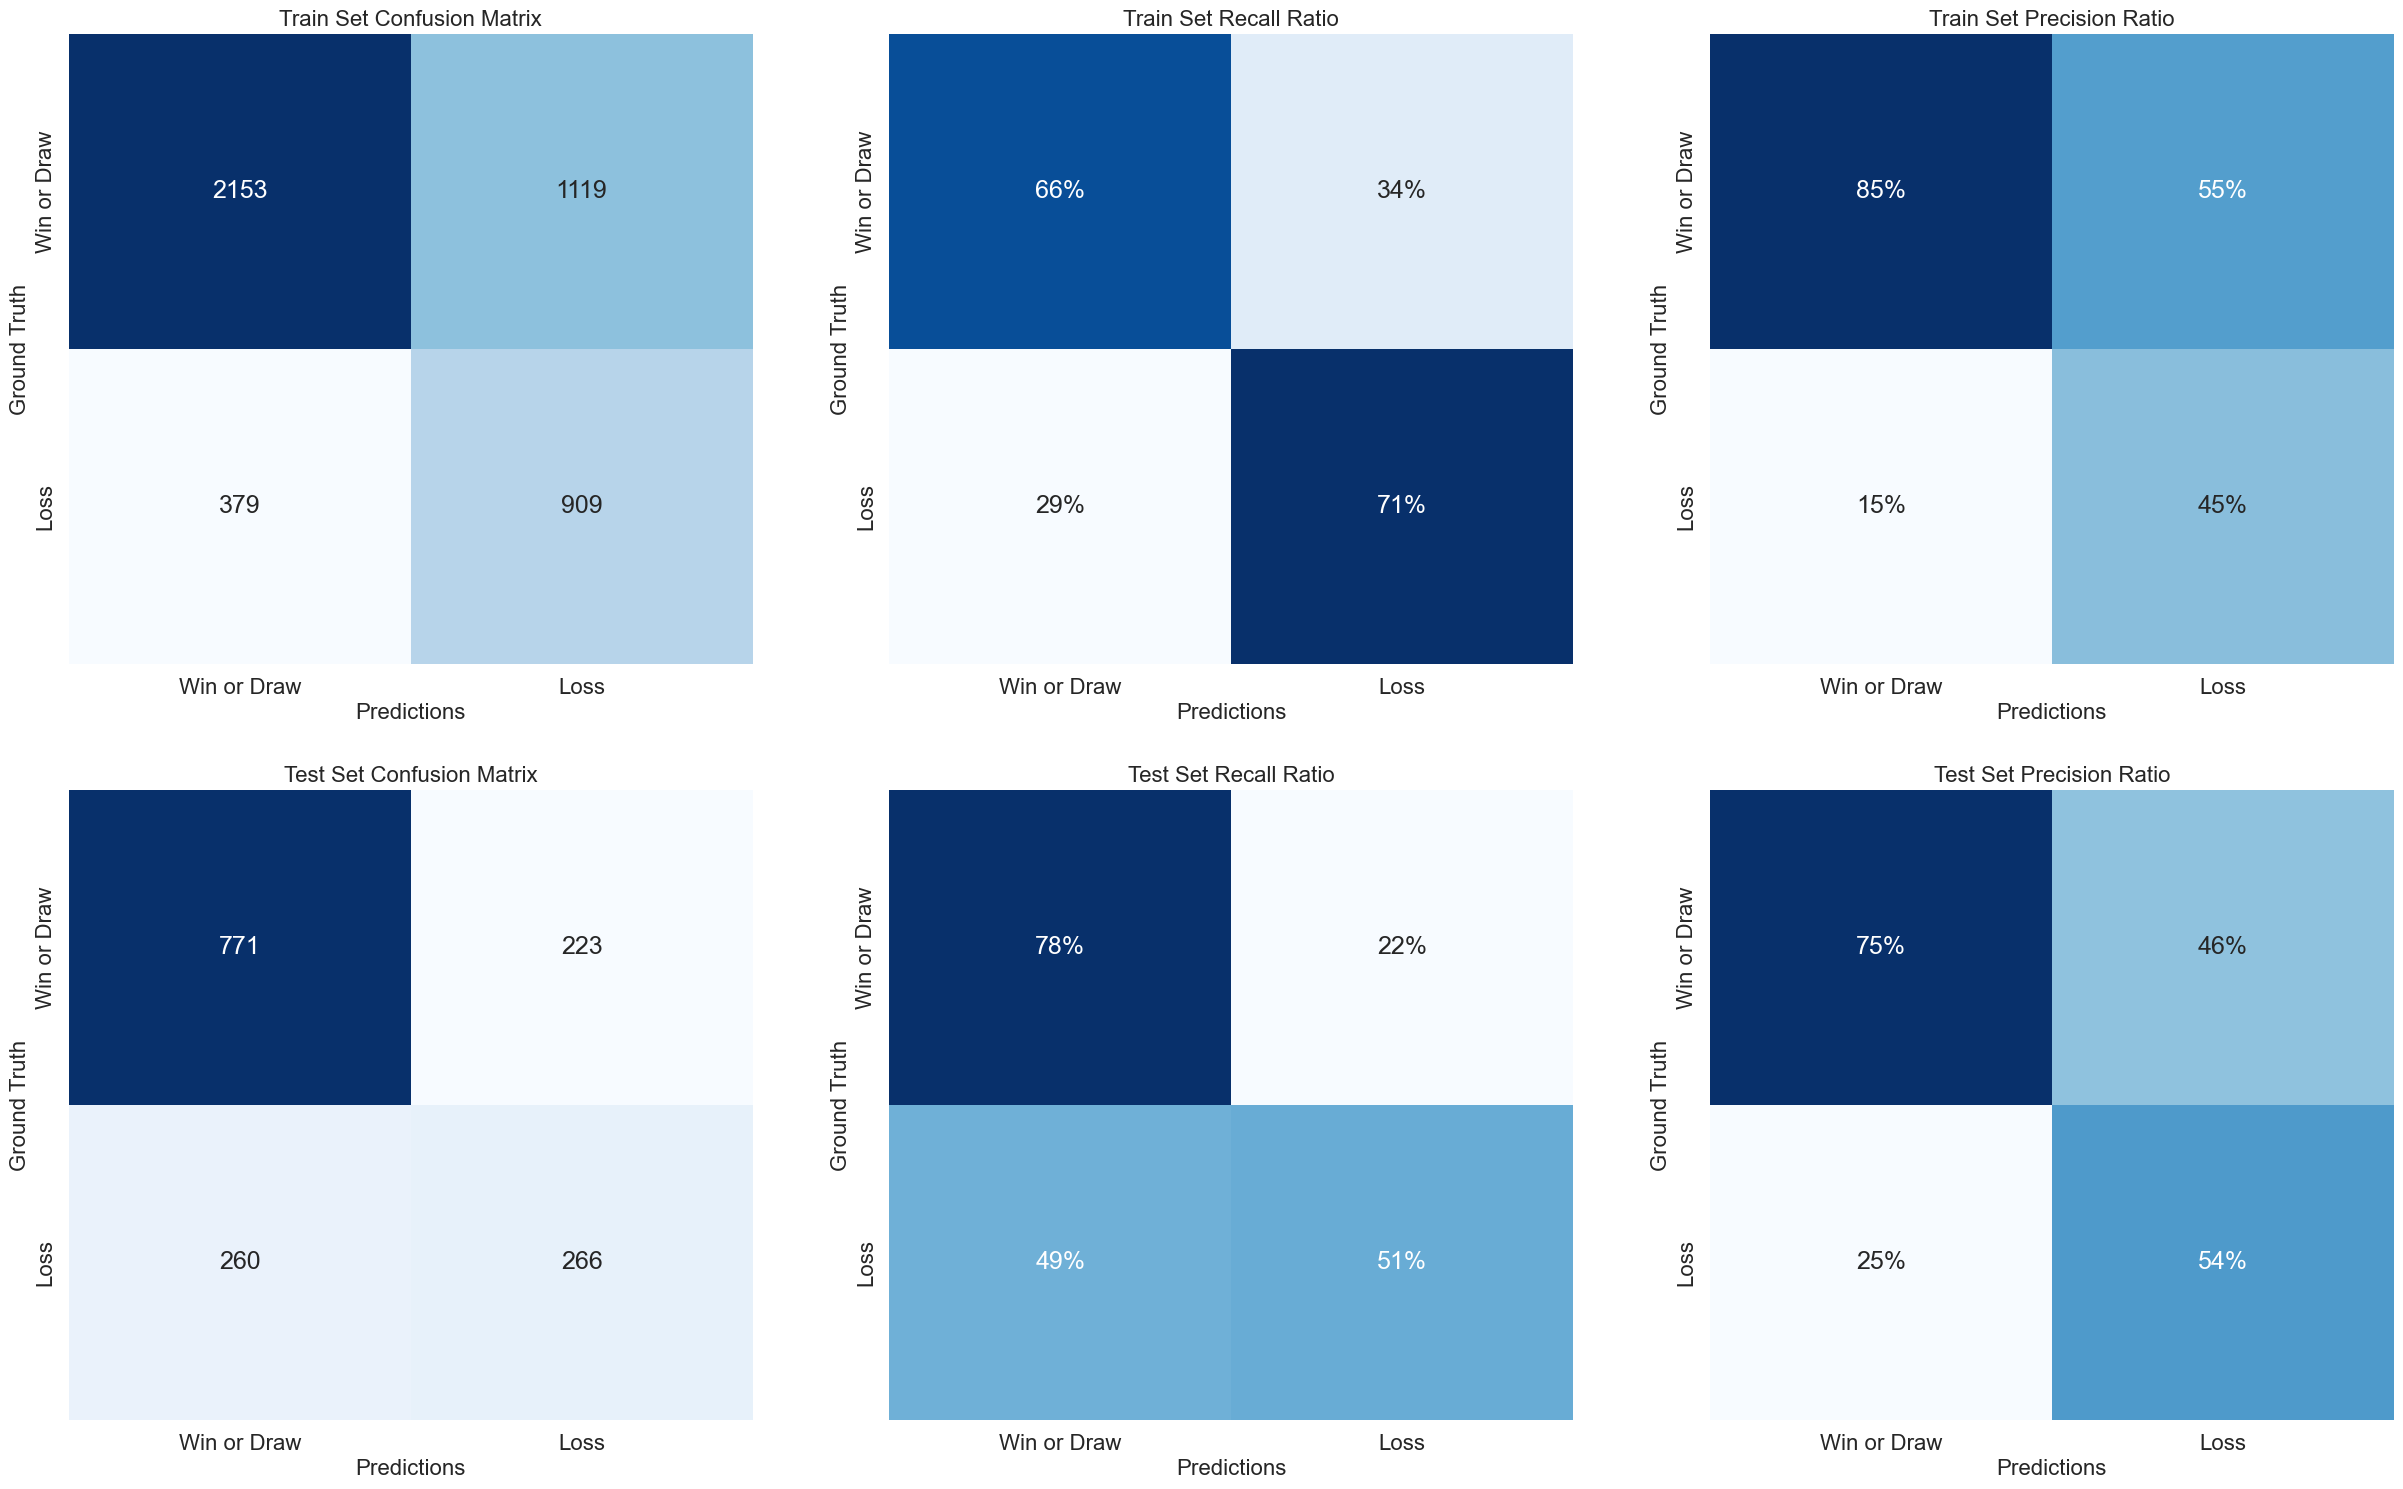

In [64]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = ada_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [65]:
# Calling the function to evaluate the performance of the classifier
ada_model_summary_df = evaluate_model_performance(model = ada_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "Adaptive Boosting",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the model performance
ada_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Adaptive Boosting       0.75      0.71                     0.68   

                   Test Balanced Accuracy  Accuracy  Precision  Recall    F1  \
Adaptive Boosting                    0.64      0.68       0.54    0.51  0.52   

                    MCC  Brier Loss  N Features  \
Adaptive Boosting  0.29        0.23         305   

                                                            Pipeline  
Adaptive Boosting  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Gradient Boosted Machine (GBM)

In [66]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__loss"] = skopt.space.Categorical(categories = ["deviance", "exponential"])
search_spaces["classifier__learning_rate"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["classifier__min_samples_split"] = skopt.space.Integer(low = 2, high = 6)
search_spaces["classifier__min_samples_leaf"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__max_depth"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__max_features"] = skopt.space.Categorical(categories = [None, "auto", "sqrt", "log2"])
search_spaces["classifier__tol"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")

# Building a classifier
gbm_model = build_pipeline(classifier = GradientBoostingClassifier(random_state = 42, n_iter_no_change = 3), 
                           apply_feature_selection = True,
                           feature_selection_type = "meta",
                           apply_bayesian_optimization = True,
                           hyperparameters = search_spaces,
                           n_iterations = 100,
                           train_features = X_train, 
                           train_labels = y_train, 
                           verbosity = 1)

# Logging information to the log file
logging.info(msg = "Gradient Boosted Machine model has been built")
 
# Displaying the architecture of the classifier
gbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                 SelectFromModel(estimator=GradientBoostingClassifier(n_iter_no_change=3,
                                                                      random_state=42),
                                 threshold='median')),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=5.293394748301241e-05,
                                            loss='exponential', max_depth=6,
                                            max_features='log2',
                                            min_samples_leaf=2,
                                            min_samples_split=6,
                                            n_estimators=209,
                                            n_iter_no_change=3, random_state=42,
                                            tol=3.663385297163735e-06))])

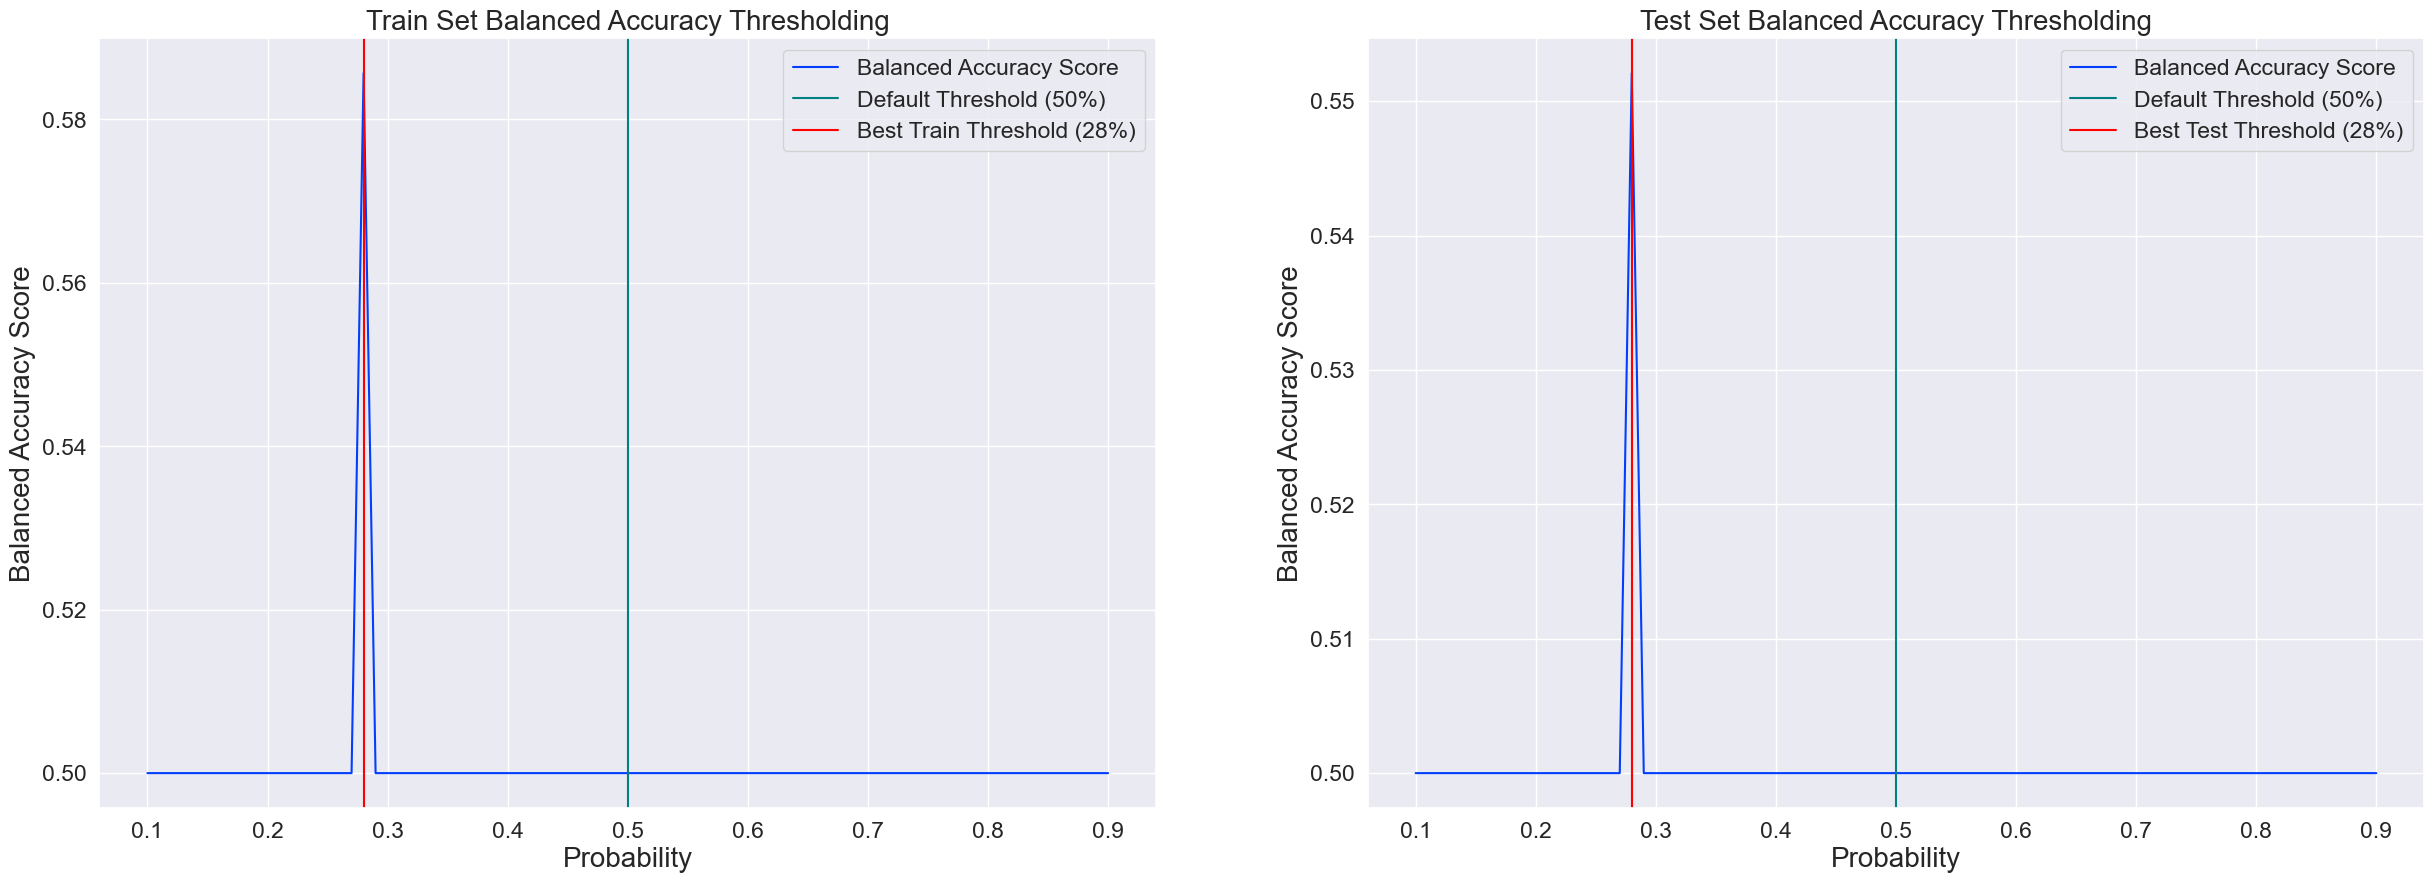

In [67]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = gbm_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [68]:
# Calling the function to print out the classification report
print_classification_report(model = gbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test,
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Gradient Boosted Machine")

Classification Report Summary for Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.98      0.18      0.31      3272
        Loss       0.32      0.99      0.49      1288

    accuracy                           0.41      4560
   macro avg       0.65      0.59      0.40      4560
weighted avg       0.79      0.41      0.36      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.90      0.13      0.23       994
        Loss       0.37      0.97      0.54       526

    accuracy                           0.42      1520
   macro avg       0.64      0.55      0.38      1520
weighted avg       0.72      0.42      0.34      1520



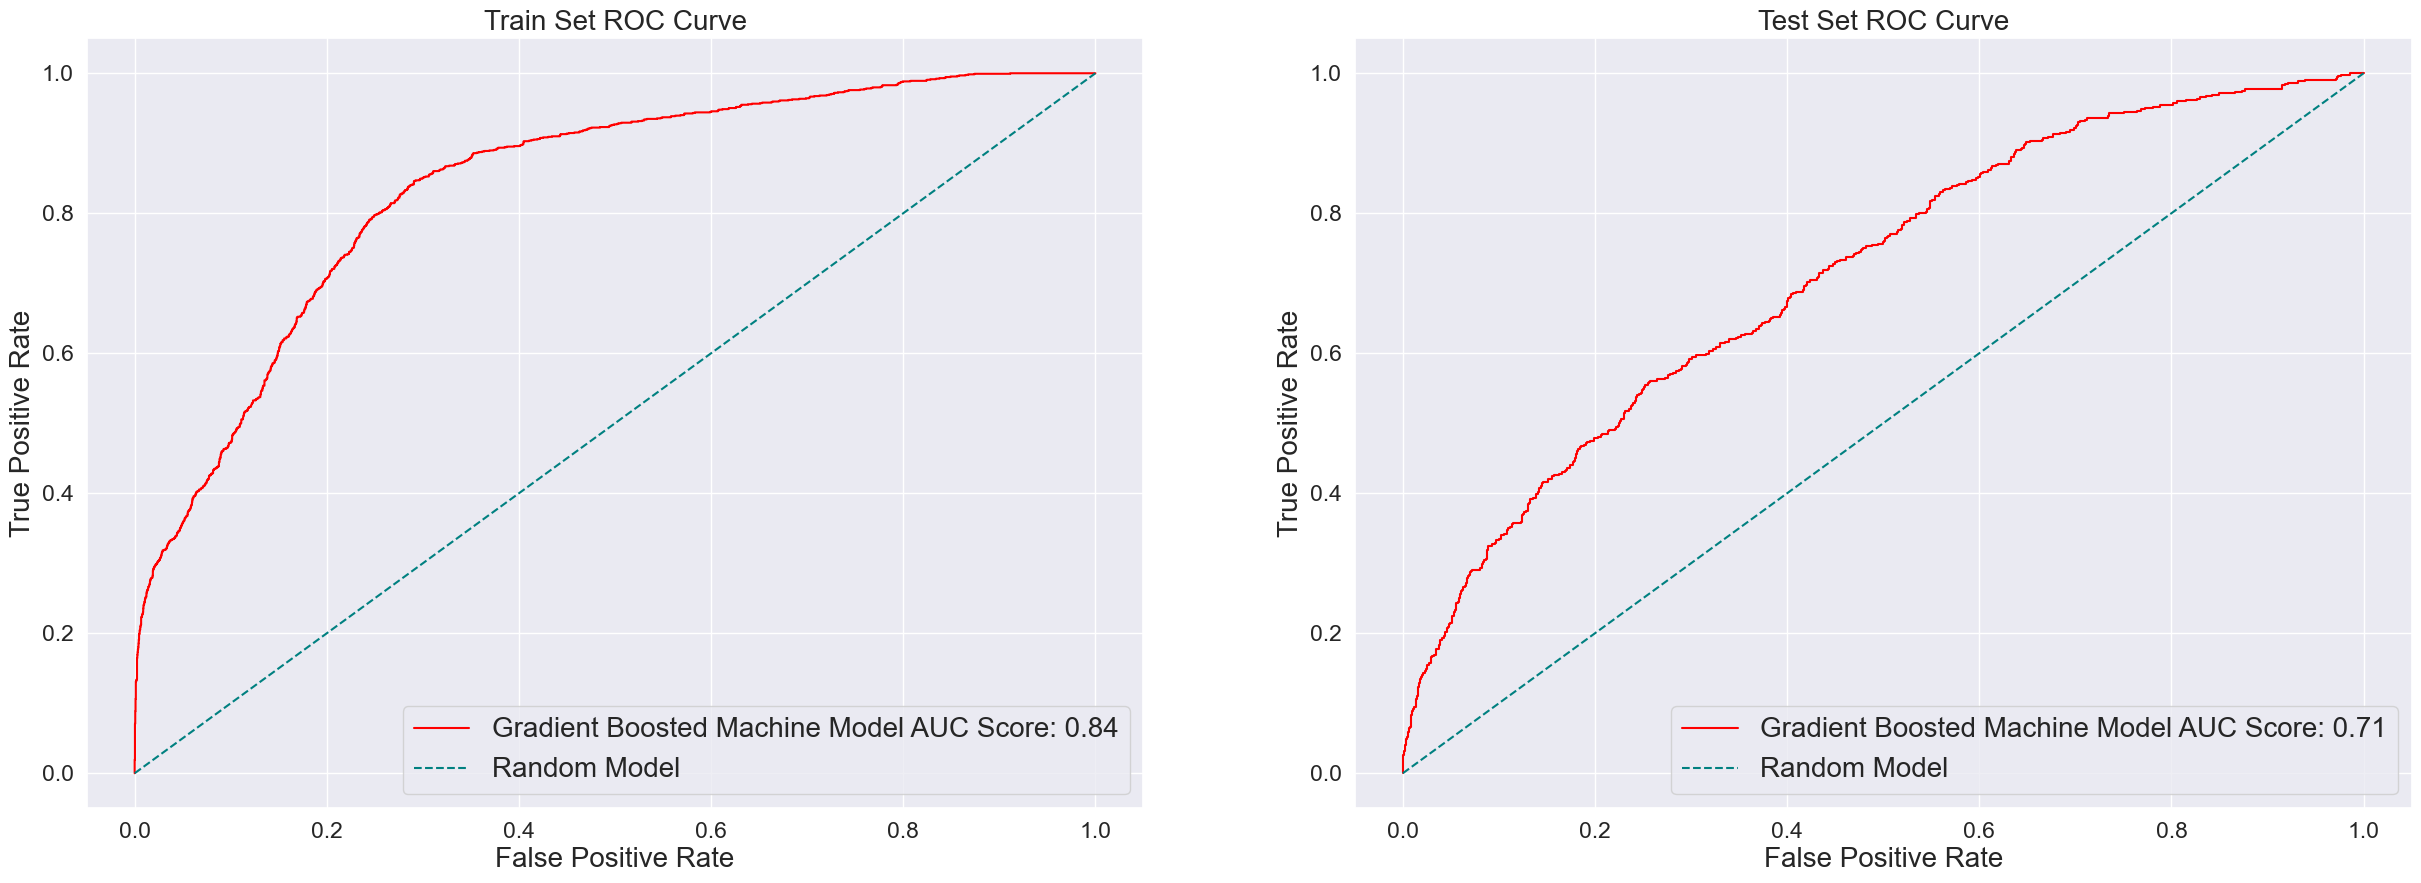

In [69]:
# Calling the function to plot ROC curve
plot_roc_curve(model = gbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Gradient Boosted Machine")

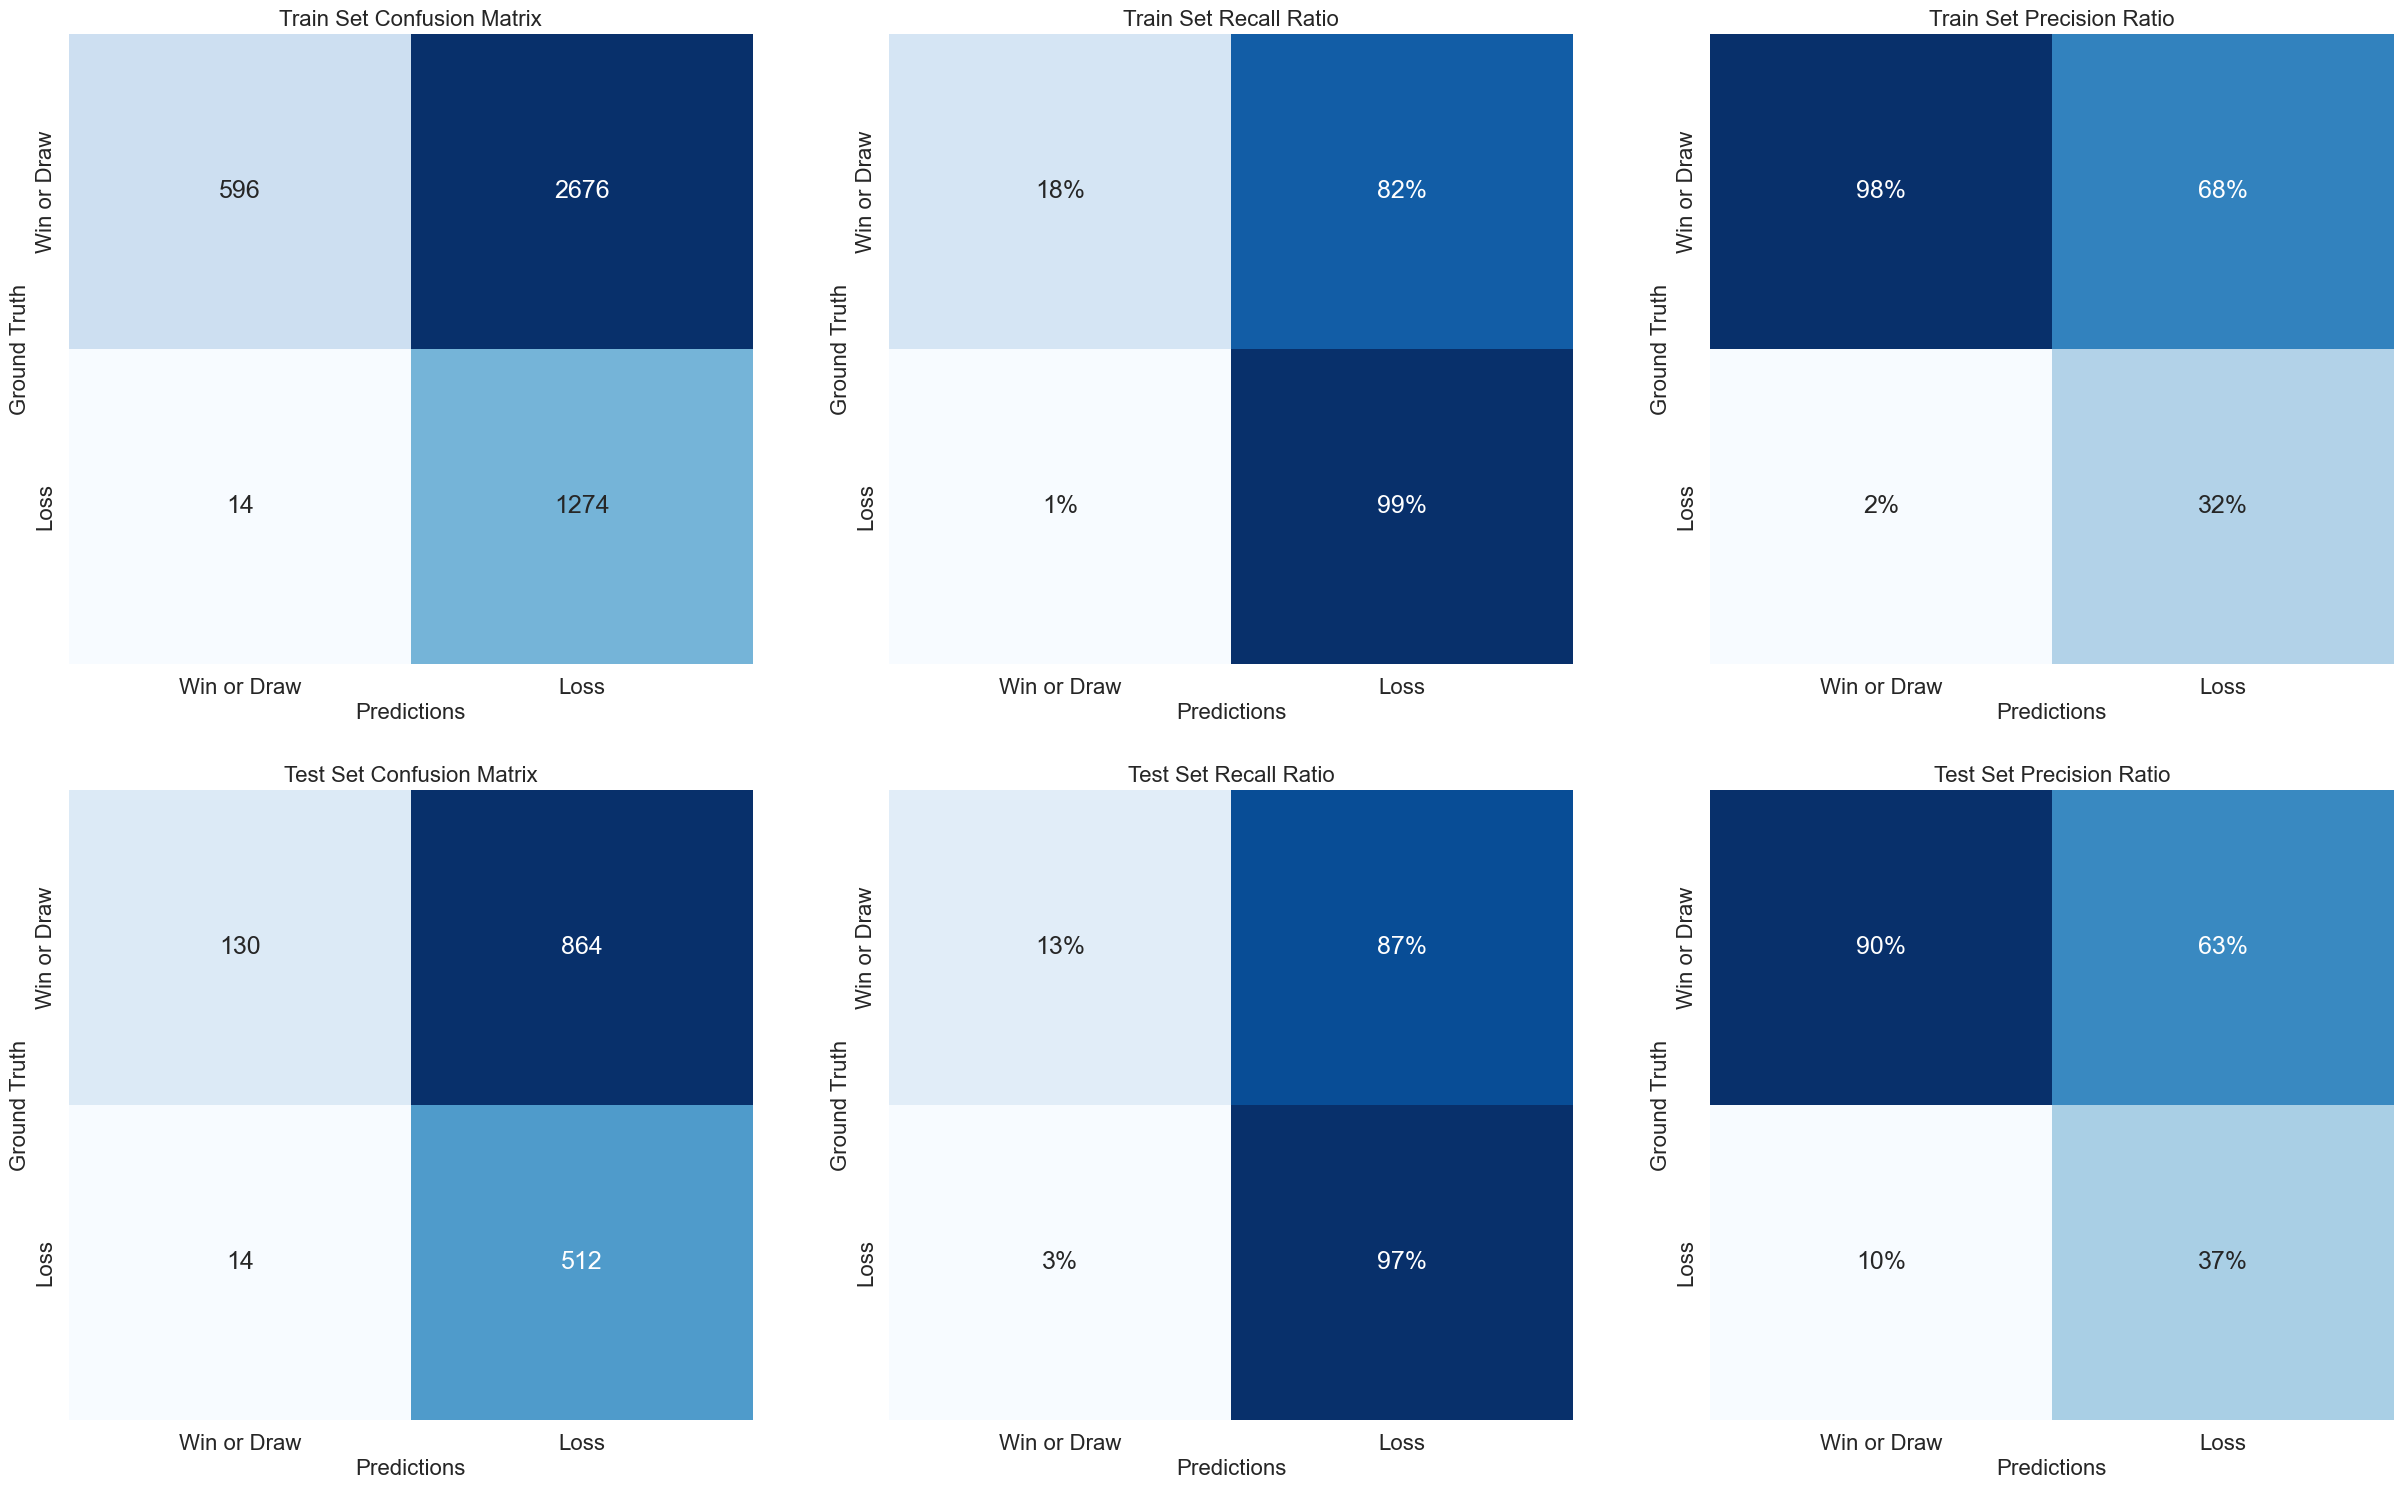

In [70]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = gbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [71]:
# Calling the function to evaluate the performance of the classifier
gbm_model_summary_df = evaluate_model_performance(model = gbm_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = "Gradient Boosted Machine",
                                                  train_threshold = train_threshold,
                                                  test_threshold = test_threshold)
# Displaying the architecture of the classifier
gbm_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Gradient Boosted Machine       0.84      0.71                     0.59   

                          Test Balanced Accuracy  Accuracy  Precision  Recall  \
Gradient Boosted Machine                    0.55      0.42       0.37    0.97   

                            F1   MCC  Brier Loss  N Features  \
Gradient Boosted Machine  0.54  0.17        0.23         305   

                                                                   Pipeline  
Gradient Boosted Machine  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Extreme Gradient Boosted Machine (XGBoost)

In [72]:
# Defining an operating level seed
np.random.seed(seed = 42)

# Creating a dictionary of hyperparameters
search_spaces = {}
search_spaces["feature_selector__threshold"] = skopt.space.Categorical(categories = [None, "median"])
search_spaces["classifier__n_estimators"] = skopt.space.Integer(low = 100, high = 300)
search_spaces["classifier__max_depth"] = skopt.space.Integer(low = 1, high = 6)
search_spaces["classifier__learning_rate"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__reg_alpha"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")
search_spaces["classifier__reg_lambda"] = skopt.space.Real(low = 1e-8, high = 0.1, prior = "log-uniform")

# Building a classifier
xgbm_model = build_pipeline(classifier = XGBClassifier(use_label_encoder = False, 
                                                       objective = "binary:logistic", 
                                                       n_jobs = -1,
                                                       eval_metric = "auc", 
                                                       random_state = 42), 
                            apply_feature_selection = True,
                            feature_selection_type = "meta",
                            apply_bayesian_optimization = True,
                            hyperparameters = search_spaces,
                            n_iterations = 100,
                            train_features = X_train, 
                            train_labels = y_train, 
                            verbosity = 1)

# Logging information to the log file
logging.info(msg = "Extreme Gradient Boosted Machine model has been built")
 
# Displaying the architecture of the classifier
xgbm_model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.016451534376309435,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=235,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0.1, reg_lambda=0.1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

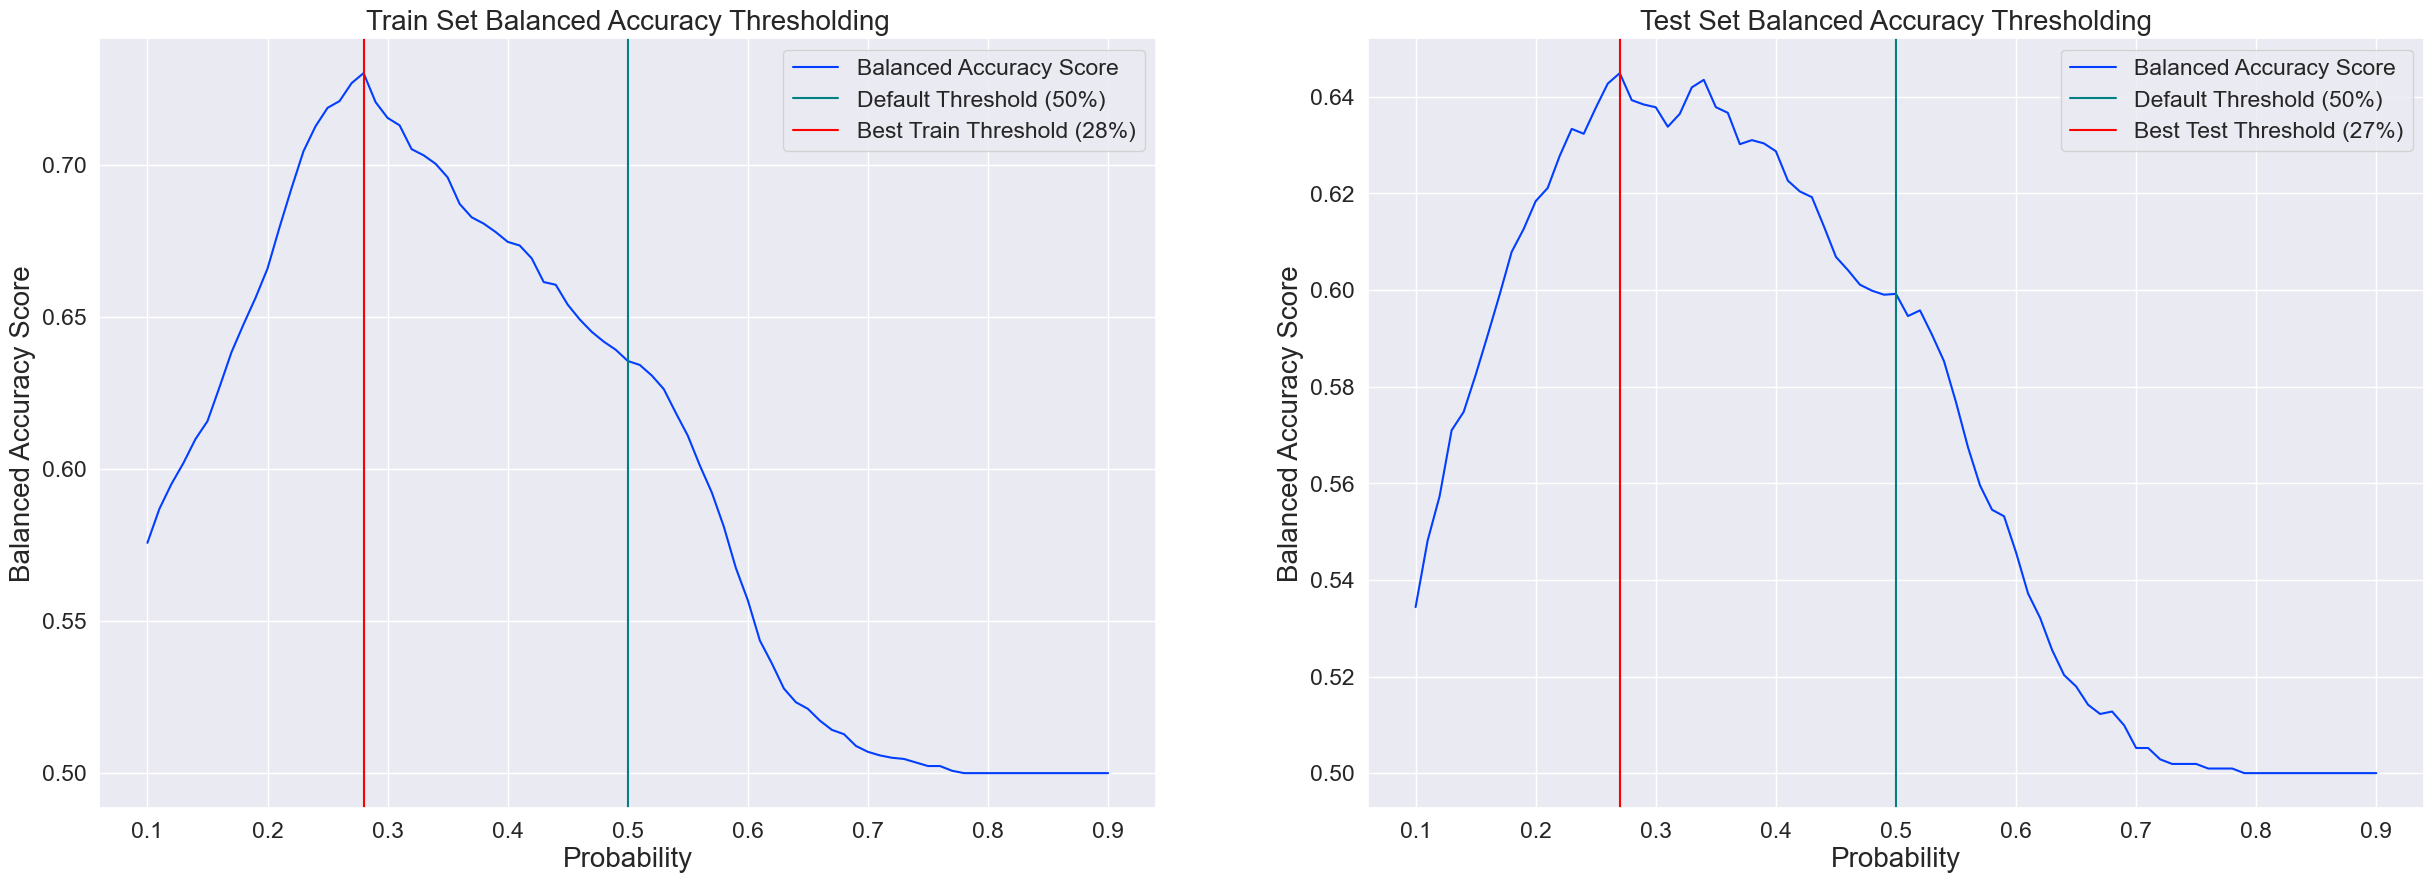

In [73]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = xgbm_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [74]:
# Calling the function to print out the classification report
print_classification_report(model = xgbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test,
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Extreme Gradient Boosted Machine")

Classification Report Summary for Extreme Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.88      0.71      0.78      3272
        Loss       0.50      0.75      0.60      1288

    accuracy                           0.72      4560
   macro avg       0.69      0.73      0.69      4560
weighted avg       0.77      0.72      0.73      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.79      0.57      0.66       994
        Loss       0.47      0.72      0.57       526

    accuracy                           0.62      1520
   macro avg       0.63      0.64      0.62      1520
weighted avg       0.68      0.62      0.63      1520



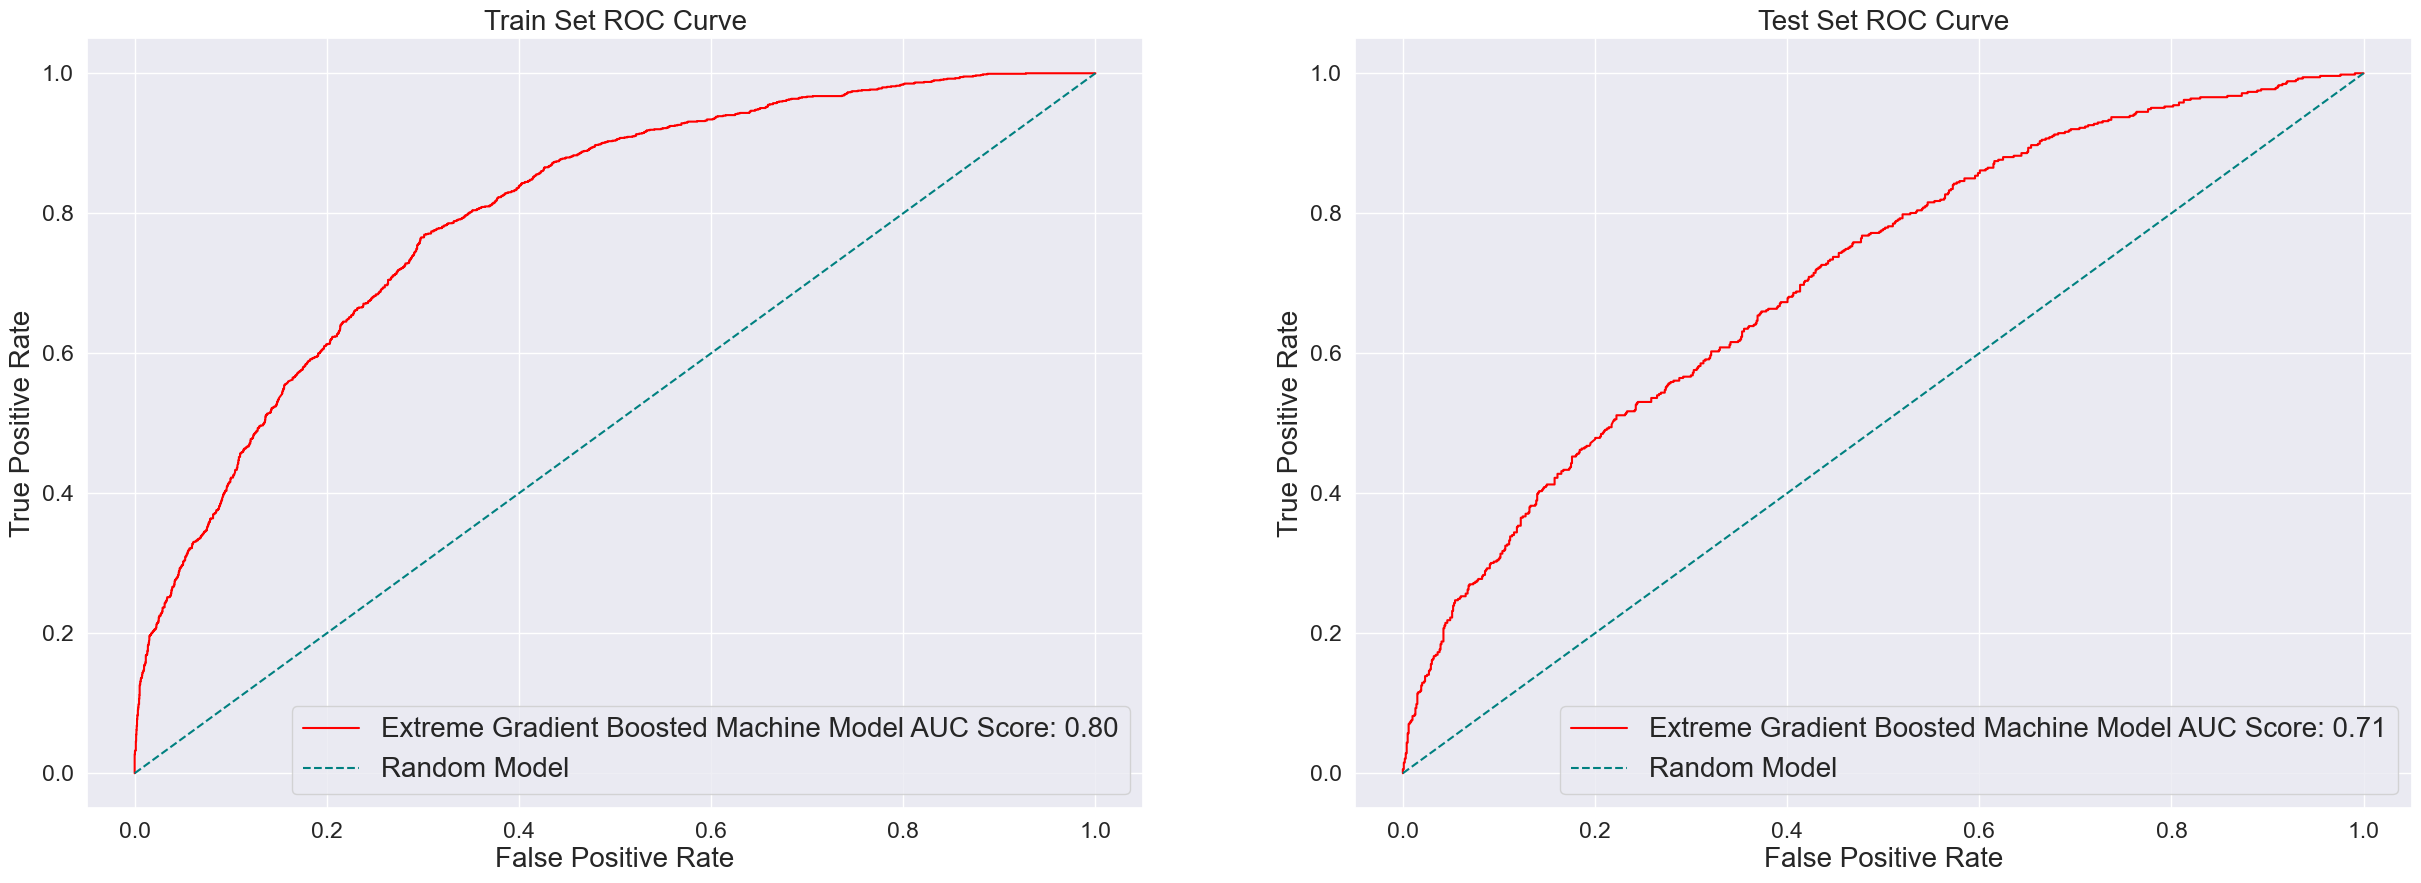

In [75]:
# Calling the function to plot ROC curve
plot_roc_curve(model = xgbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Extreme Gradient Boosted Machine")

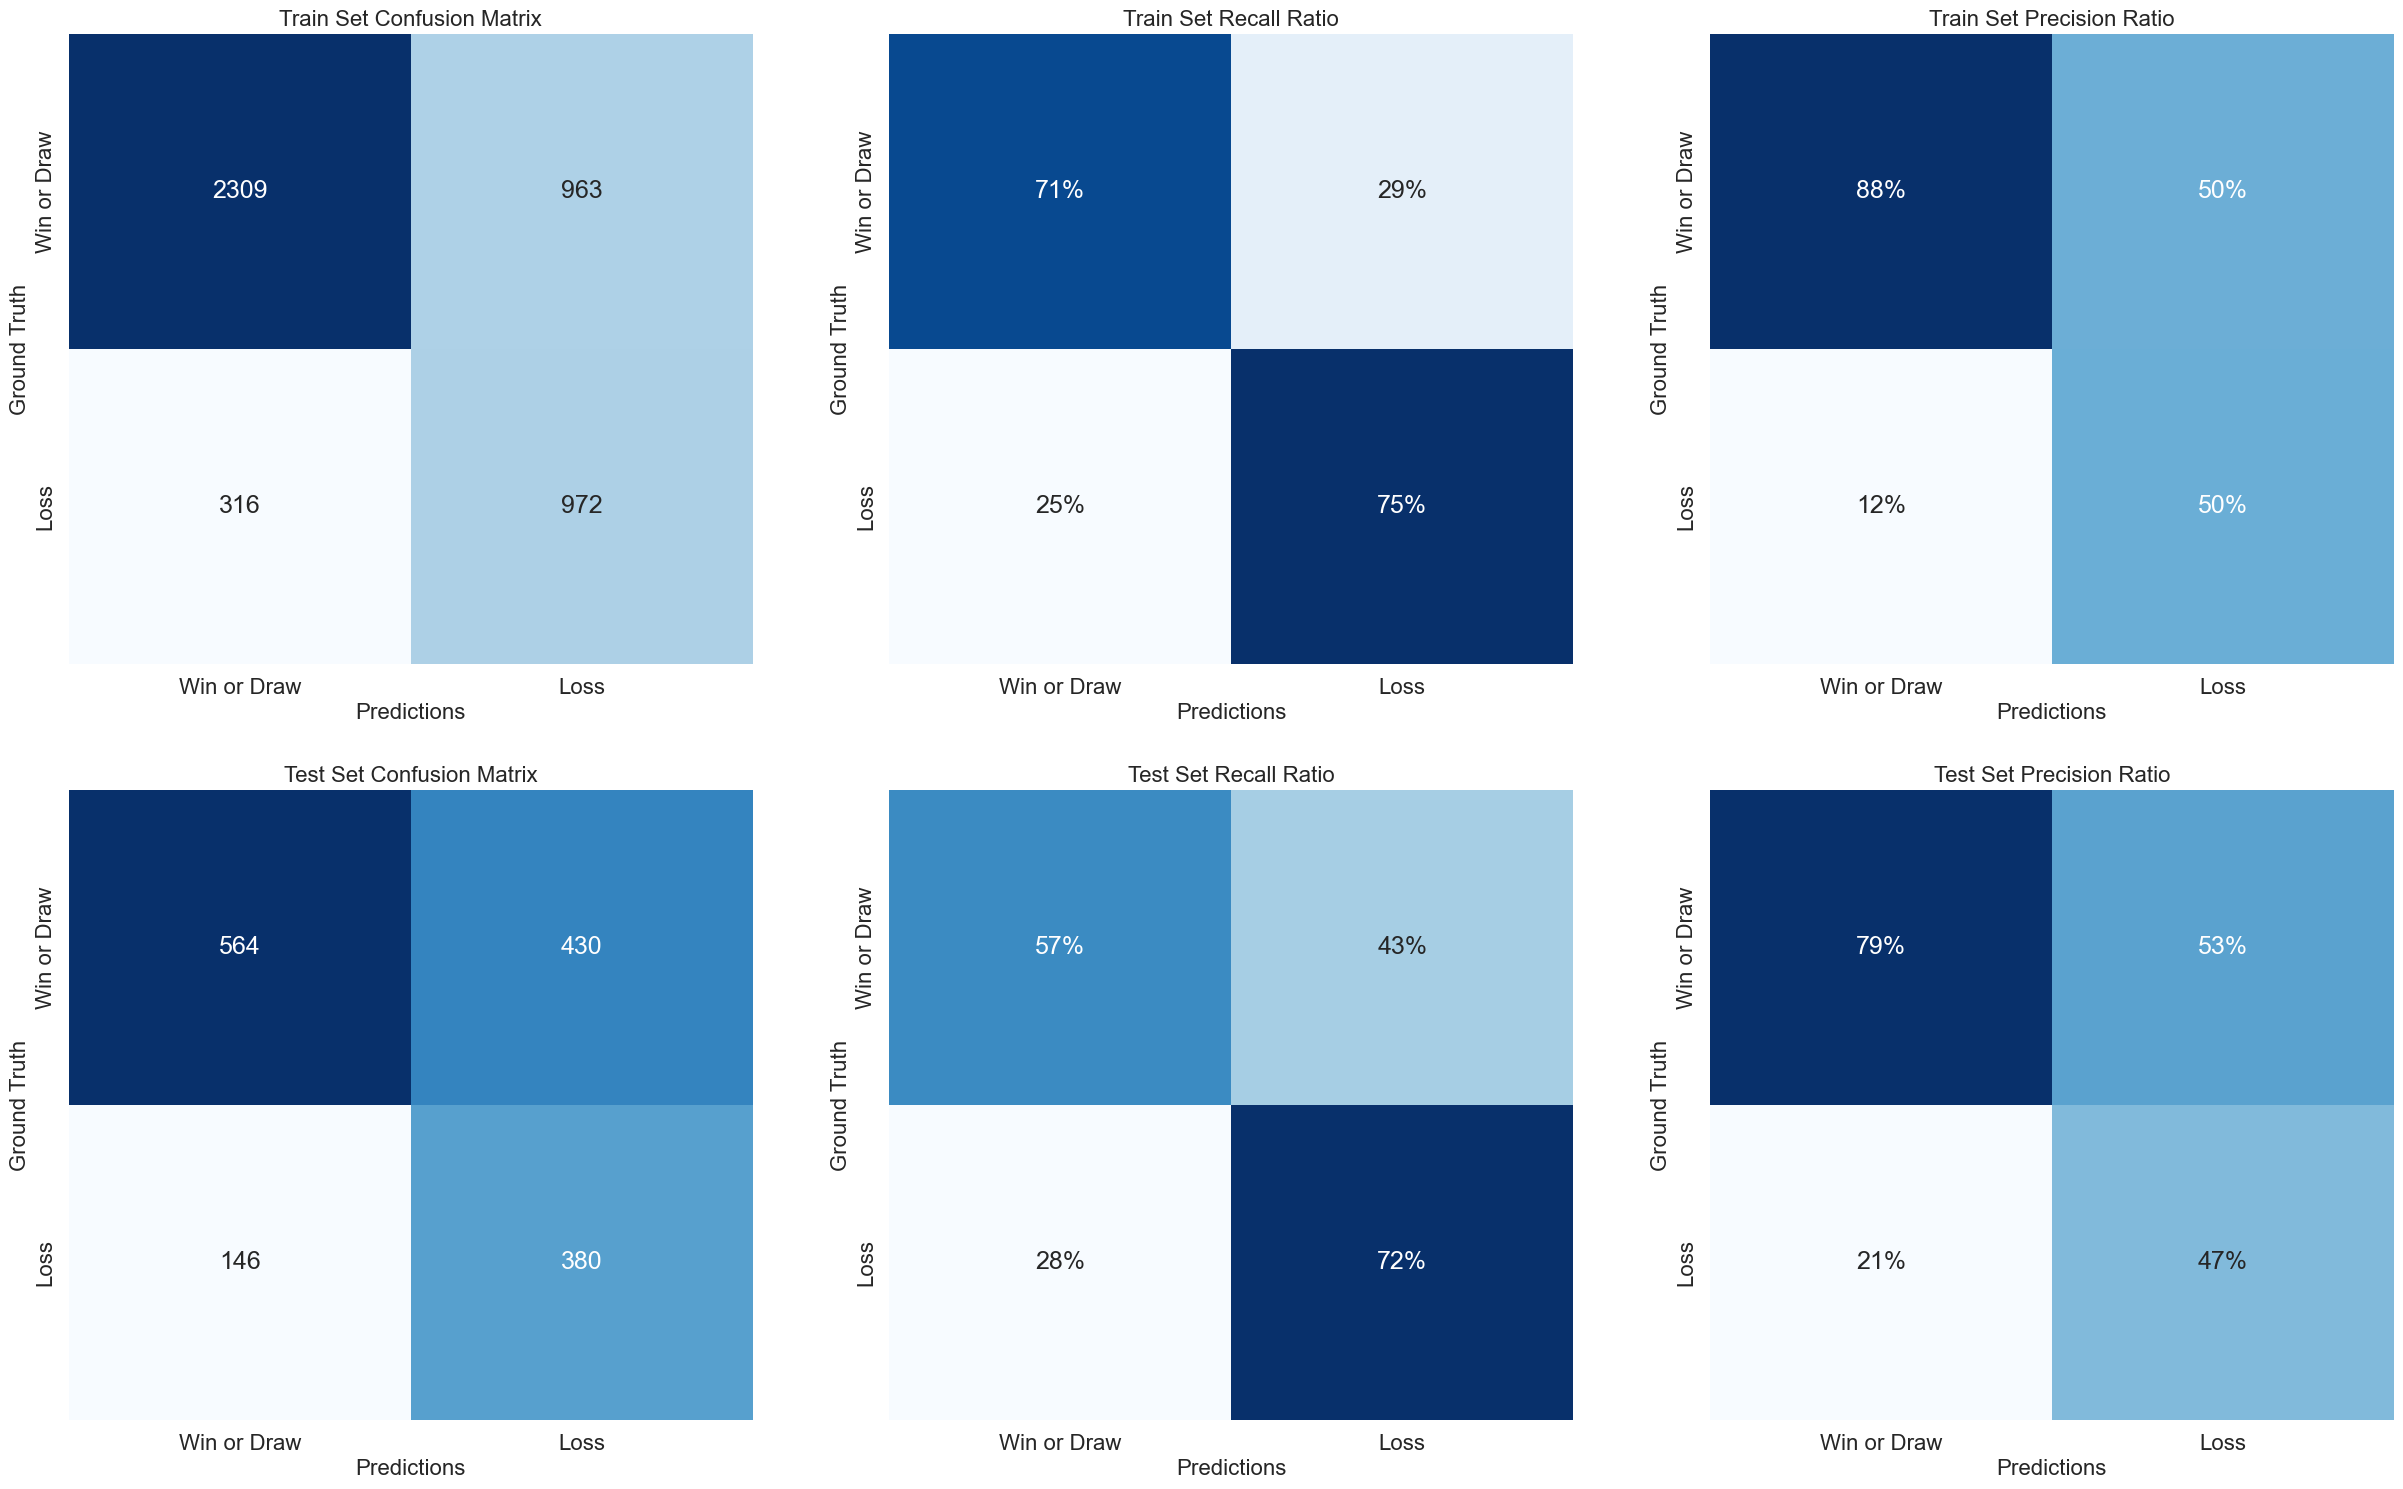

In [76]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = xgbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [77]:
# Calling the function to evaluate the performance of the classifier
xgbm_model_summary_df = evaluate_model_performance(model = xgbm_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = "Extreme Gradient Boosted Machine",
                                                   train_threshold = train_threshold,
                                                   test_threshold = test_threshold)
# Displaying the architecture of the classifier
xgbm_model_summary_df

Train AUC  Test AUC  \
Extreme Gradient Boosted Machine        0.8      0.71   

                                  Train Balanced Accuracy  \
Extreme Gradient Boosted Machine                     0.73   

                                  Test Balanced Accuracy  Accuracy  Precision  \
Extreme Gradient Boosted Machine                    0.64      0.62       0.47   

                                  Recall    F1   MCC  Brier Loss  N Features  \
Extreme Gradient Boosted Machine    0.72  0.57  0.28         0.2         153   

                                                                           Pipeline  
Extreme Gradient Boosted Machine  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Category Boosting (CatBoost)

In [78]:
# Building a classifier
catb_model = build_pipeline(classifier = CatBoostClassifier(eval_metric = "AUC", 
                                                            task_type = "CPU", 
                                                            verbose = False, 
                                                            random_state = 42), 
                            apply_feature_selection = True,
                            feature_selection_type = 'meta',
                            train_features = X_train, 
                            train_labels = y_train)

# Logging information to the log file
logging.info(msg = "Category Boosting model has been built")

# Removing the log folder
shutil.rmtree(path = "catboost_info")
 
# Displaying the architecture of the classifier
catb_model

Pipeline(steps=[('initial_preprocessor', InitialPreprocessor()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['derby_name', 'home_team',
                                                   'away_team']),
                                                 ('ordinal_pipeline',
                                                  P...
                                                   'total_avg_goals_scored_last_3_h',
                                                   'total_avg_goals_scored_last_3_a',
                                                   'total_avg_goals_scored_last_5_h',
                                                   'total_avg_goals_scored_last_5_a',
                                                   'total_goals_conceded_h',
                                                   'total_goals_conceded_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=<catboost.core.CatBoostClassifier object at 0x7fa9b5ca92b0>)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fa9b5ca92b0>)])

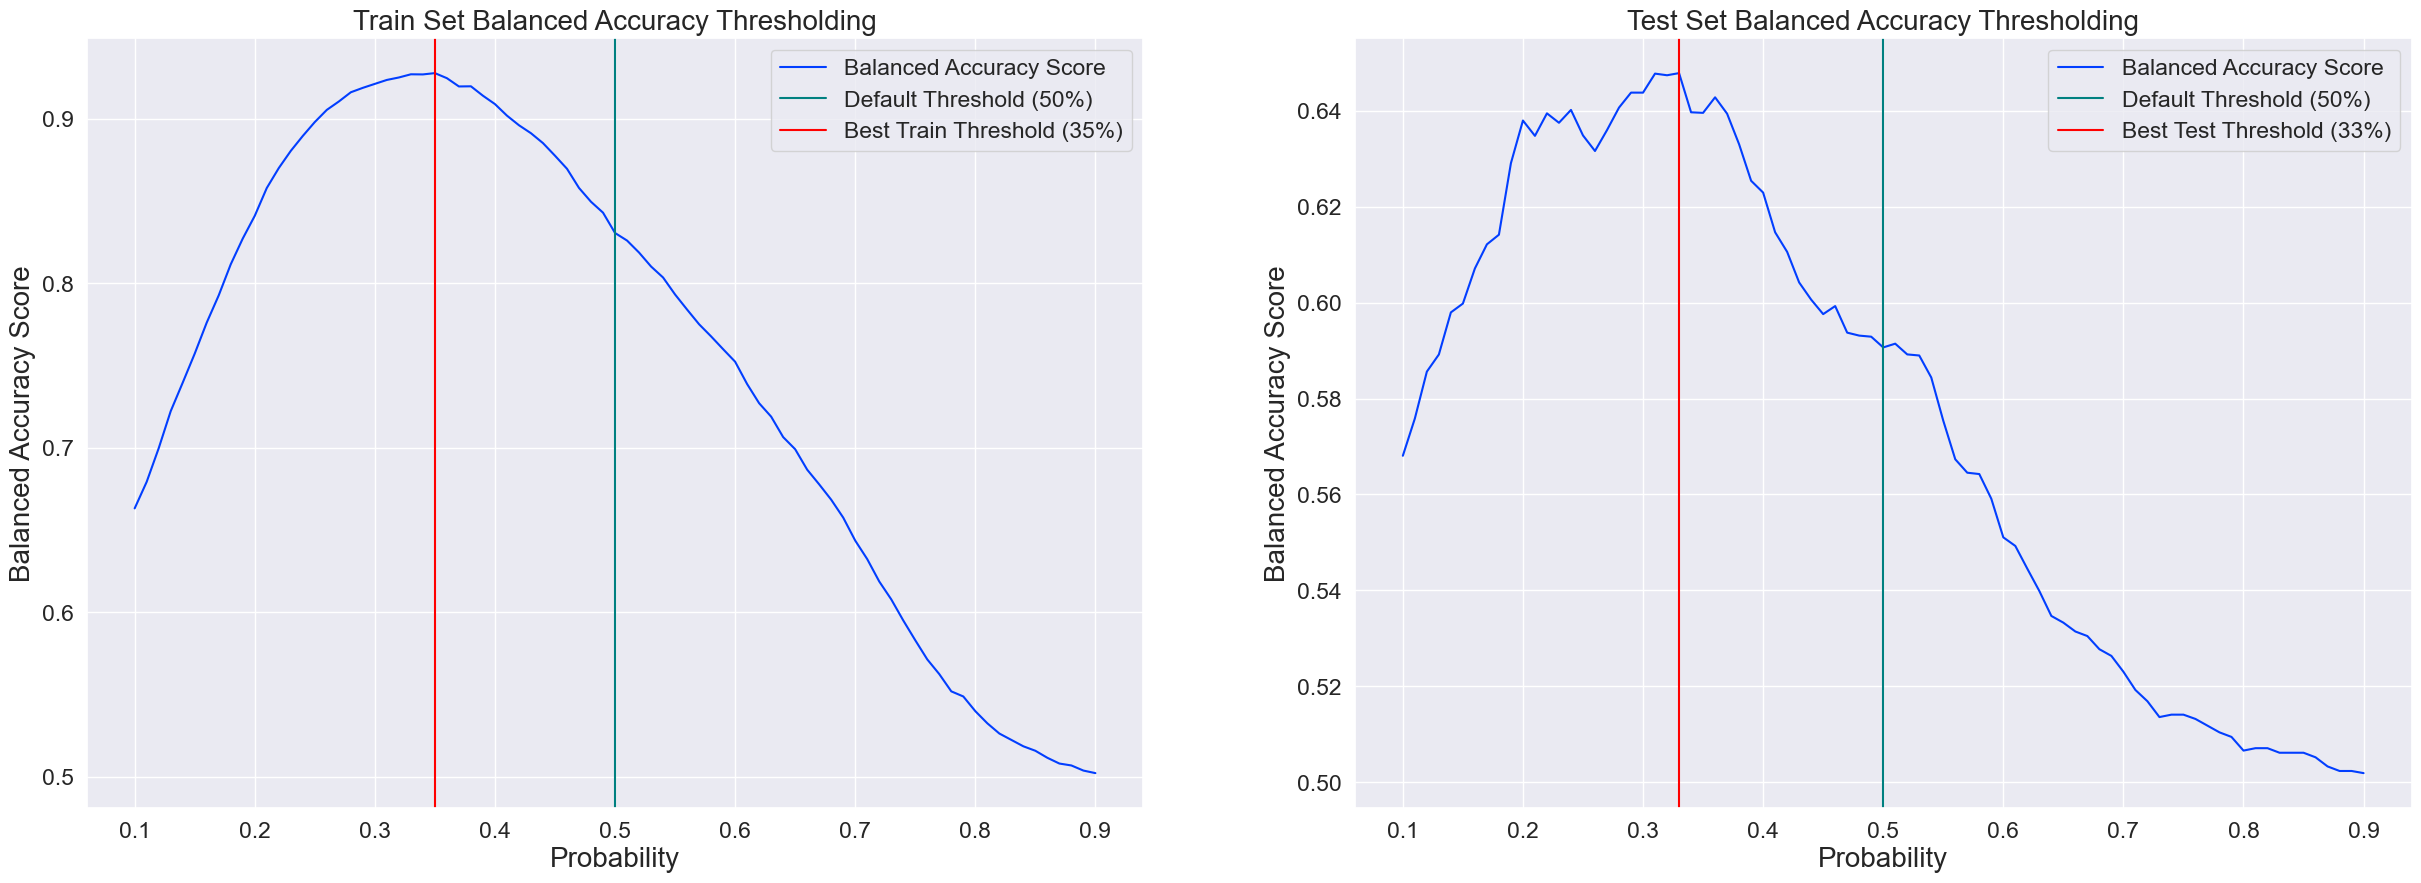

In [79]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = catb_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [80]:
# Calling the function to print out the classification report
print_classification_report(model = catb_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Category Boosting")

Classification Report Summary for Category Boosting Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.97      0.94      0.95      3272
        Loss       0.85      0.92      0.88      1288

    accuracy                           0.93      4560
   macro avg       0.91      0.93      0.92      4560
weighted avg       0.93      0.93      0.93      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.76      0.74      0.75       994
        Loss       0.53      0.55      0.54       526

    accuracy                           0.68      1520
   macro avg       0.65      0.65      0.65      1520
weighted avg       0.68      0.68      0.68      1520



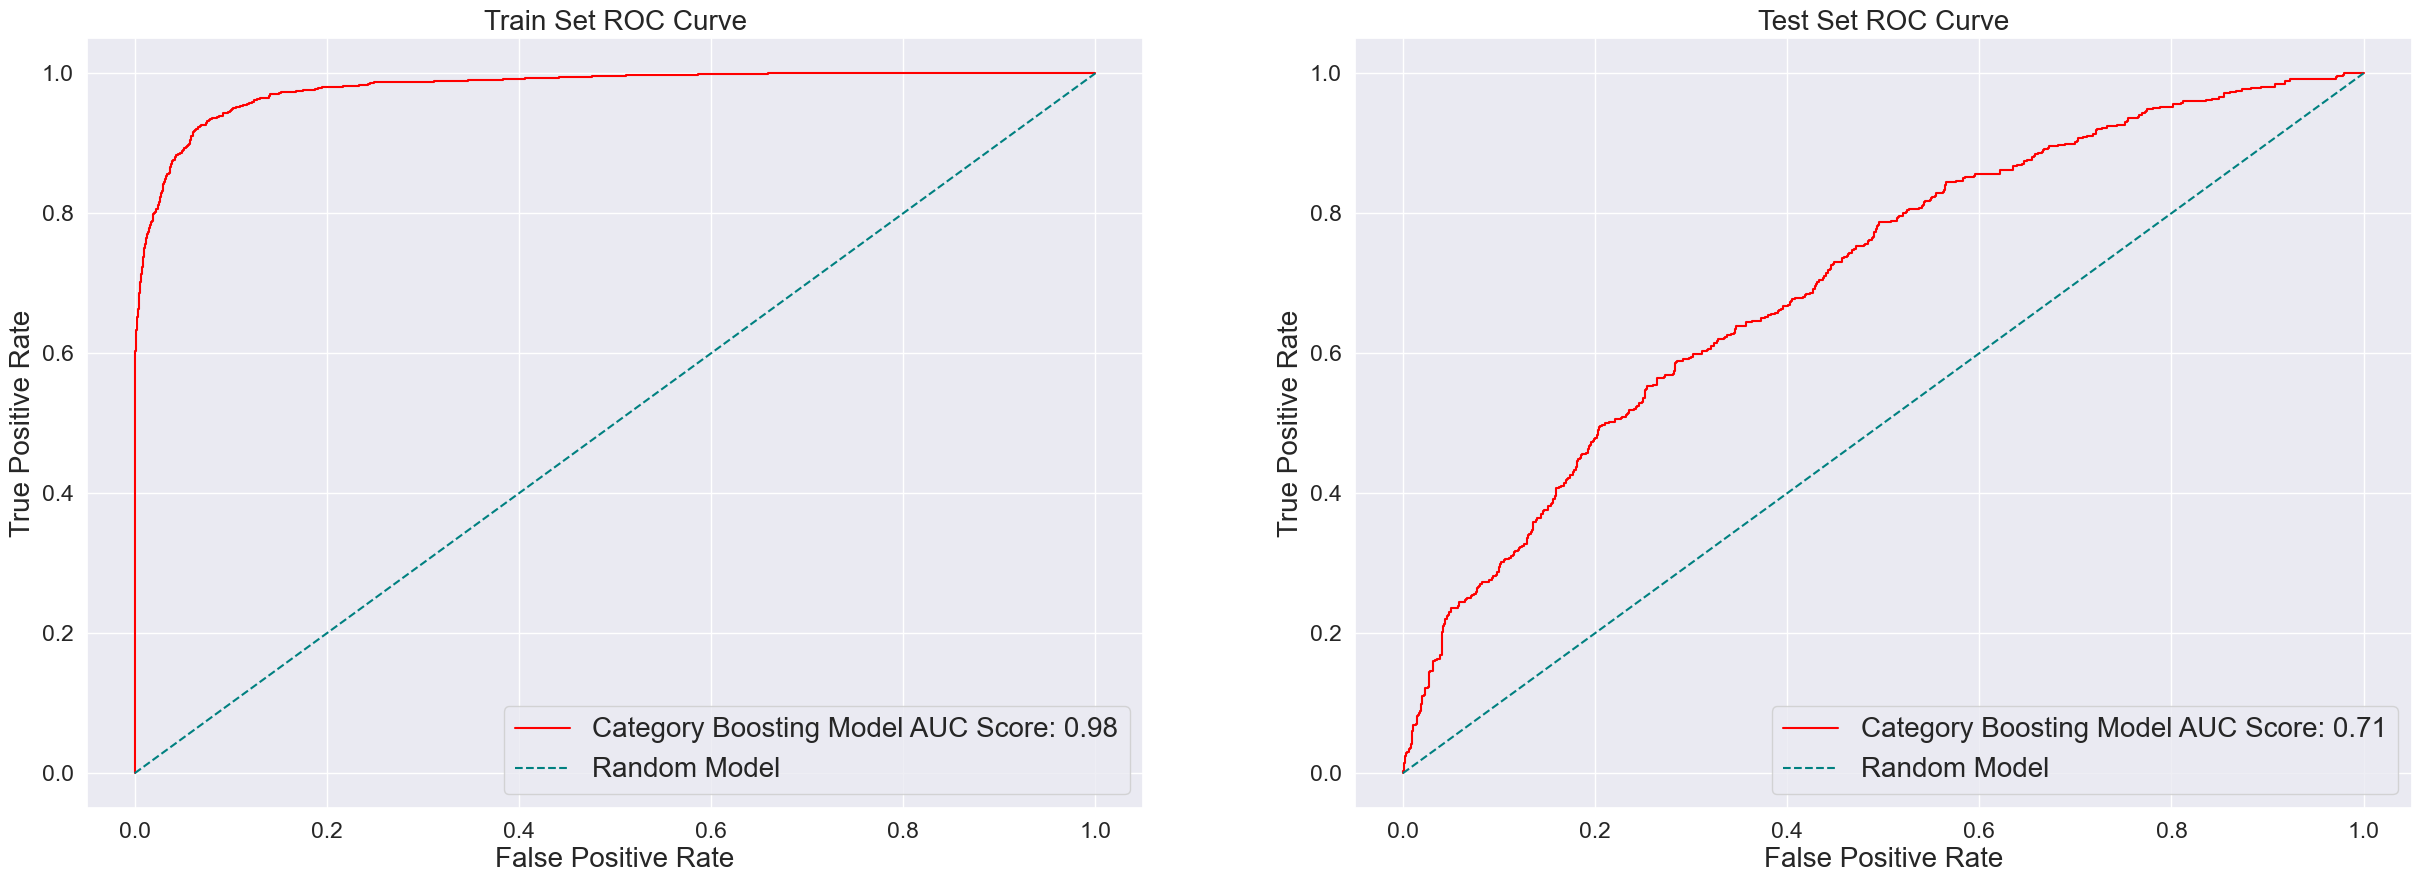

In [81]:
# Calling the function to plot ROC curve
plot_roc_curve(model = catb_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Category Boosting")

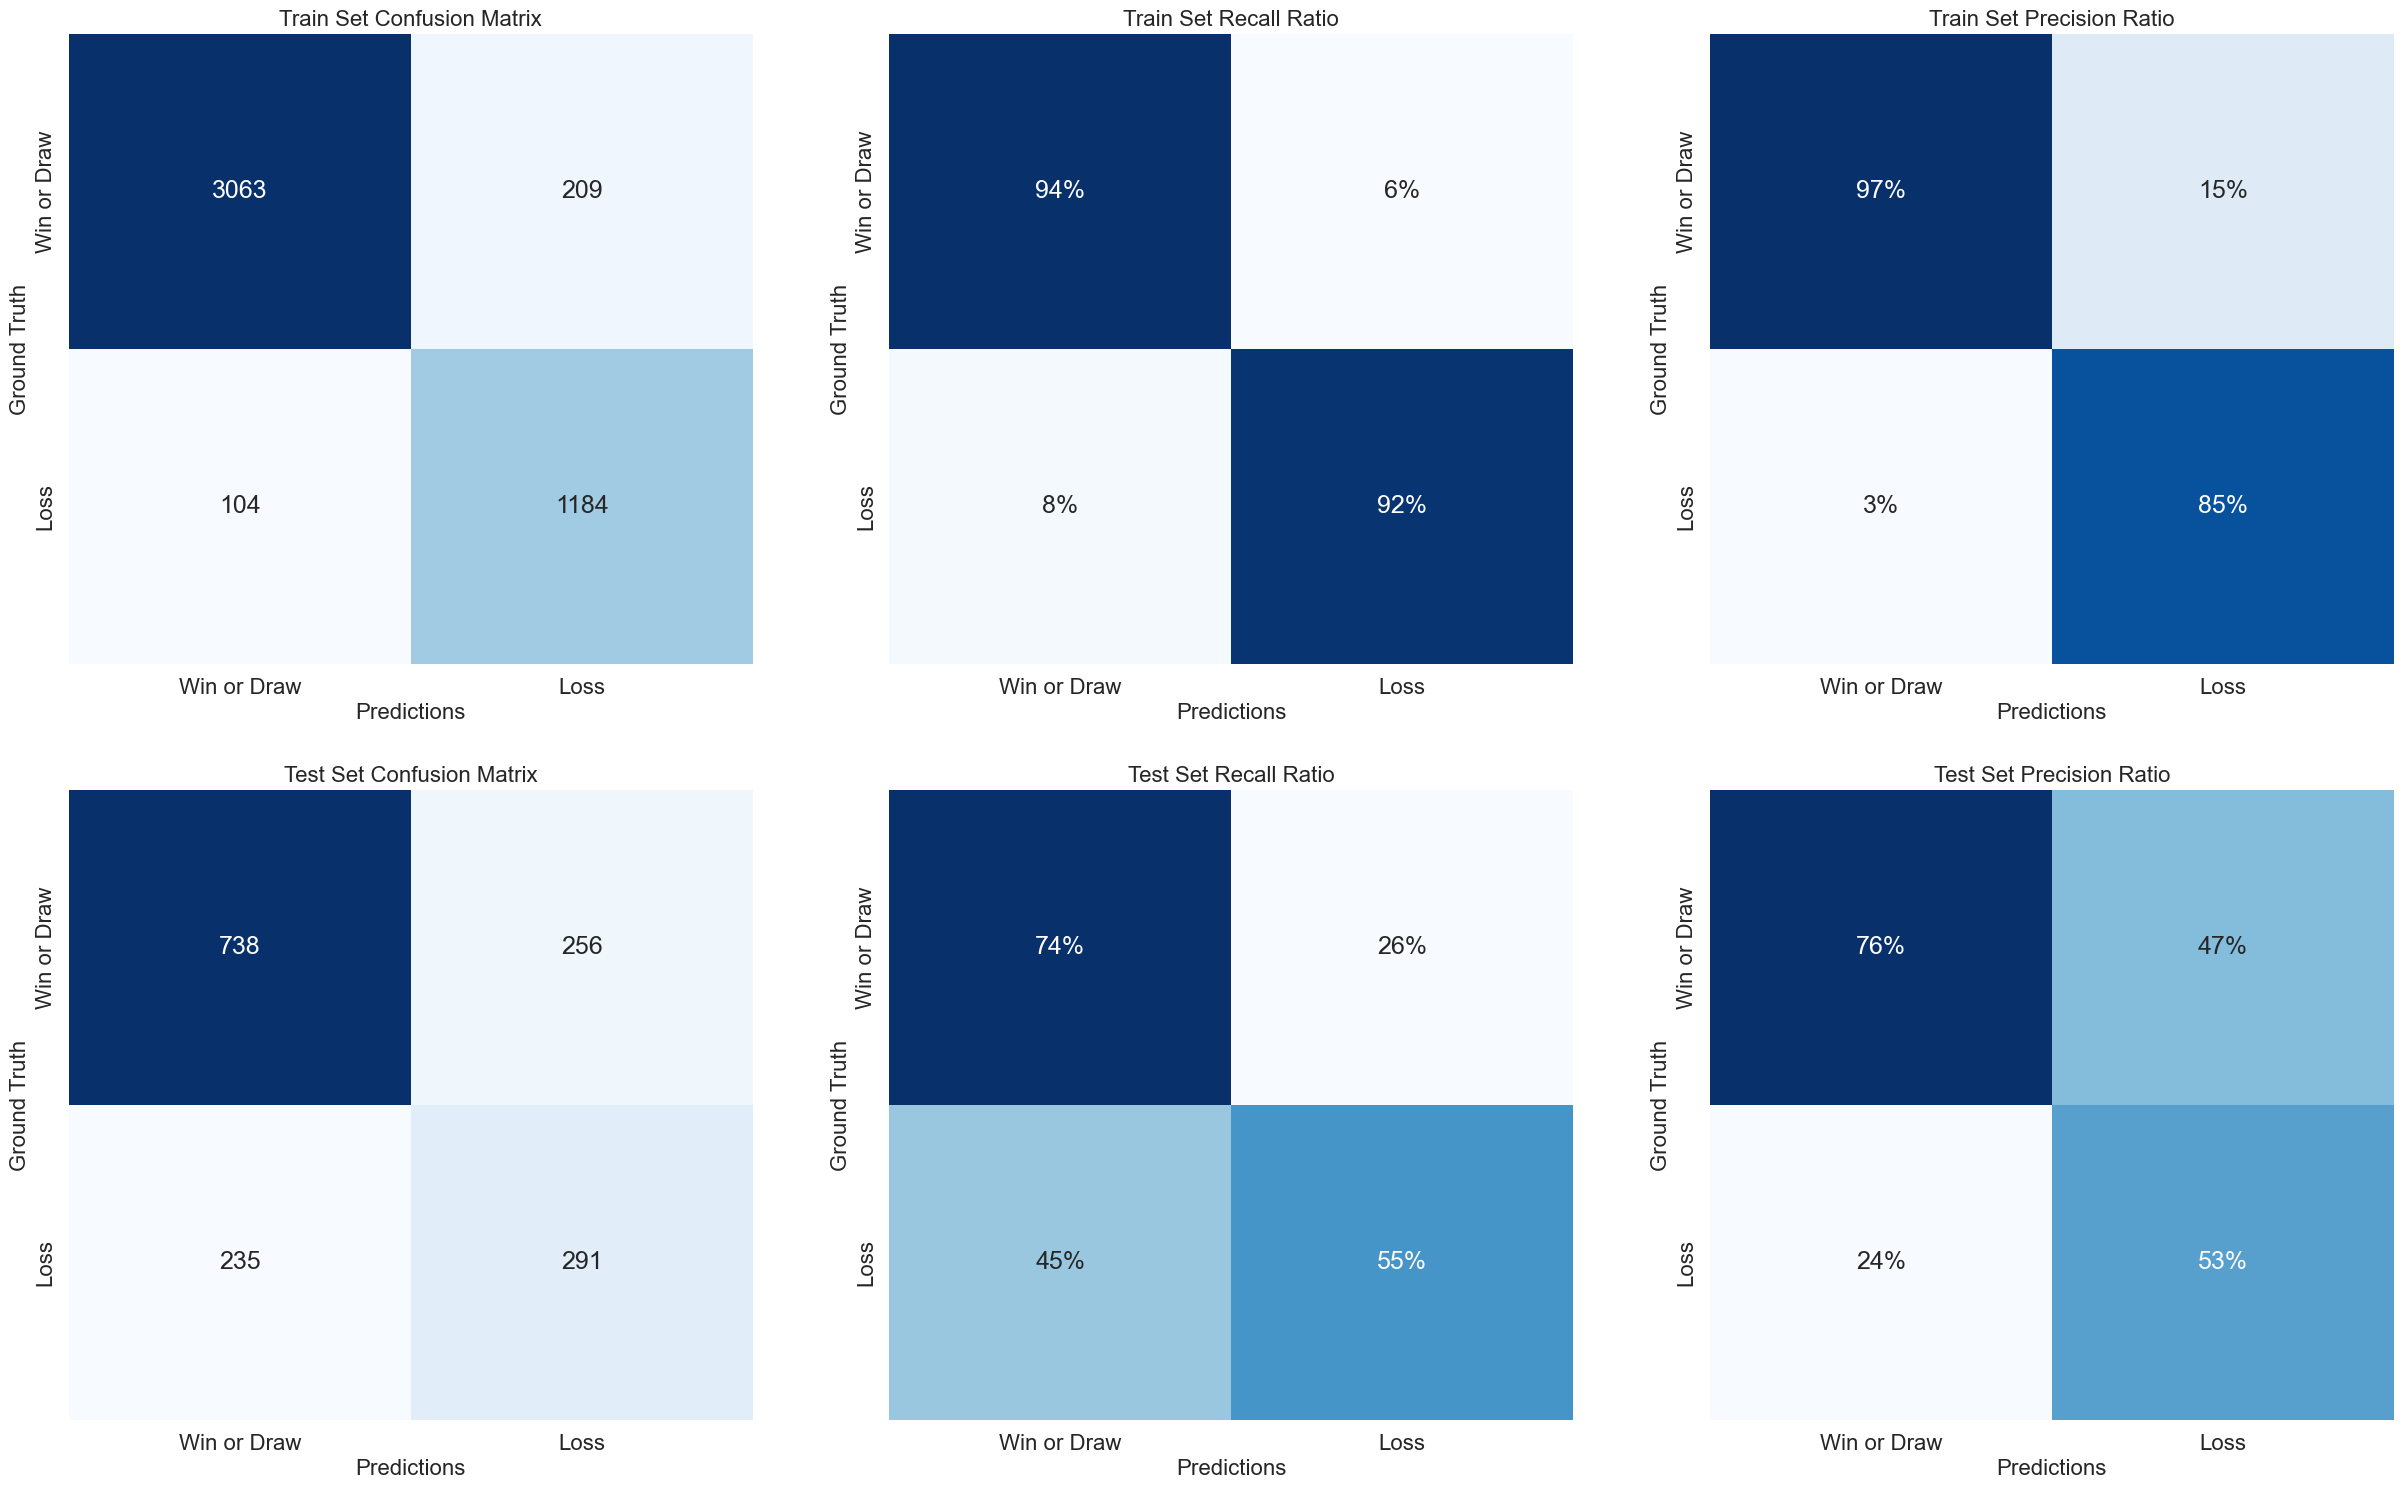

In [82]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = catb_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [83]:
# Calling the function to evaluate the performance of the classifier
catb_model_summary_df = evaluate_model_performance(model = catb_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = "Category Boosting",
                                                   train_threshold = train_threshold,
                                                   test_threshold = test_threshold)
# Displaying the architecture of the classifier
catb_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  \
Category Boosting       0.98      0.71                     0.93   

                   Test Balanced Accuracy  Accuracy  Precision  Recall    F1  \
Category Boosting                    0.65      0.68       0.53    0.55  0.54   

                    MCC  Brier Loss  N Features  \
Category Boosting  0.29         0.2         126   

                                                            Pipeline  
Category Boosting  (InitialPreprocessor(), ColumnTransformer(n_jo...

***
### Stacked

In [84]:
# Creating a list of estimators
models = [('Logistic Regression', lr_model), 
          ('Light Gradient Boosted Machine', lgbm_model), 
          ('Multi Layer Perceptron', mlp_model)]

# Creating an estimator of stacked classifier
stacked_model = StackingClassifier(estimators = models, 
                                   n_jobs = -1)

# Logging information to the log file
logging.info(msg = "Stacked model has been built")

# Fitting the train features and labels
stacked_model.fit(X = X_train, y = y_train)

StackingClassifier(estimators=[('Logistic Regression',
                                Pipeline(steps=[('initial_preprocessor',
                                                 InitialPreprocessor()),
                                                ('feature_transformer',
                                                 ColumnTransformer(n_jobs=-1,
                                                                   remainder='passthrough',
                                                                   transformers=[('nominal_pipeline',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['derby_...
                                                                                   'total_avg_goals_scored_last_5_h',
                                                                                   'total_avg_goals_scored_last_5_a',
                                                                                   'total_goals_conceded_h',
                                                                                   'total_goals_conceded_a', ...])])),
                                                ('feature_selector',
                                                 SelectPercentile(percentile=90)),
                                                ('classifier',
                                                 MLPClassifier(alpha=0.1,
                                                               early_stopping=True,
                                                               learning_rate='adaptive',
                                                               learning_rate_init=0.03552197786623699,
                                                               max_iter=1000,
                                                               n_iter_no_change=3,
                                                               shuffle=False,
                                                               tol=1e-08))]))],
                   n_jobs=-1)

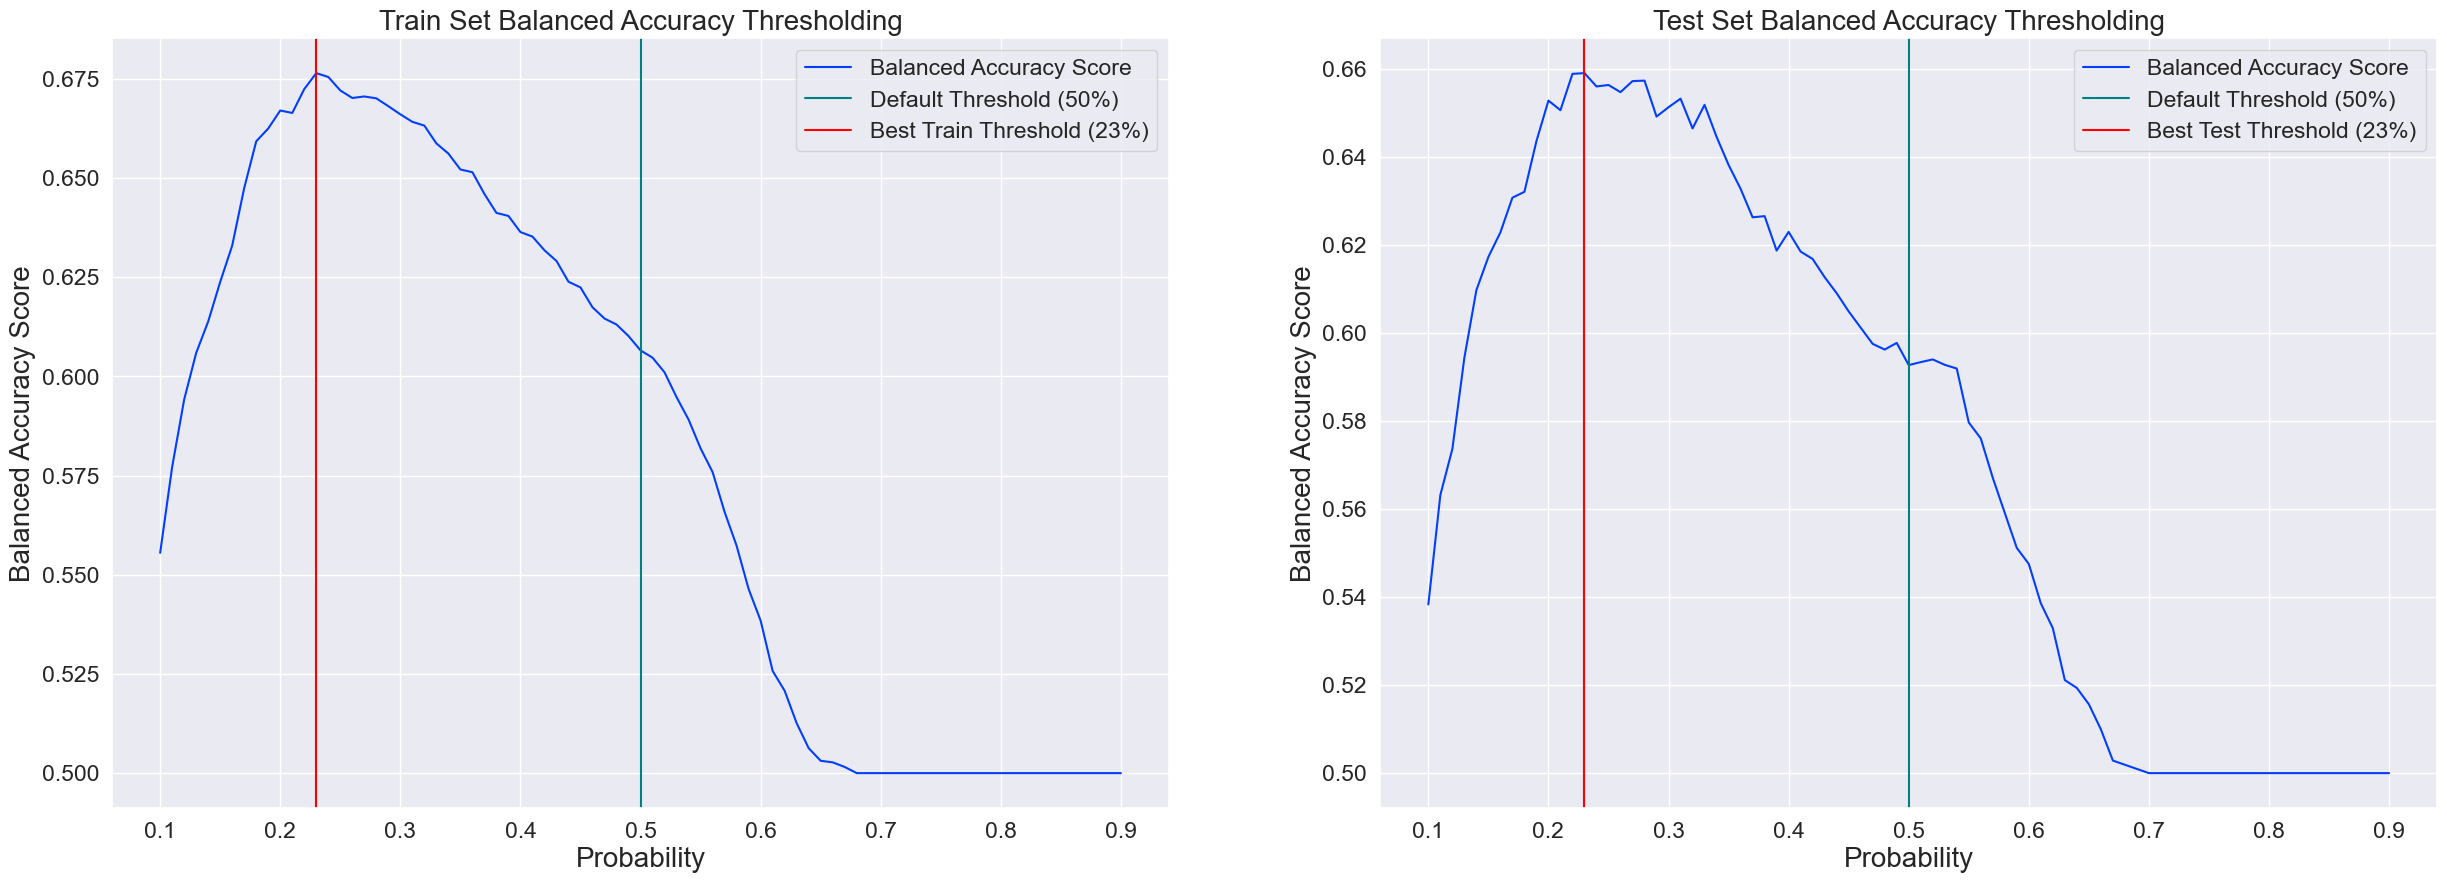

In [85]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = stacked_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [86]:
# Calling the function to print out the classification report
print_classification_report(model = stacked_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Stacked")

Classification Report Summary for Stacked Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.85      0.65      0.74      3272
        Loss       0.44      0.70      0.54      1288

    accuracy                           0.67      4560
   macro avg       0.64      0.68      0.64      4560
weighted avg       0.73      0.67      0.68      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.81      0.58      0.68       994
        Loss       0.48      0.74      0.58       526

    accuracy                           0.63      1520
   macro avg       0.64      0.66      0.63      1520
weighted avg       0.69      0.63      0.64      1520



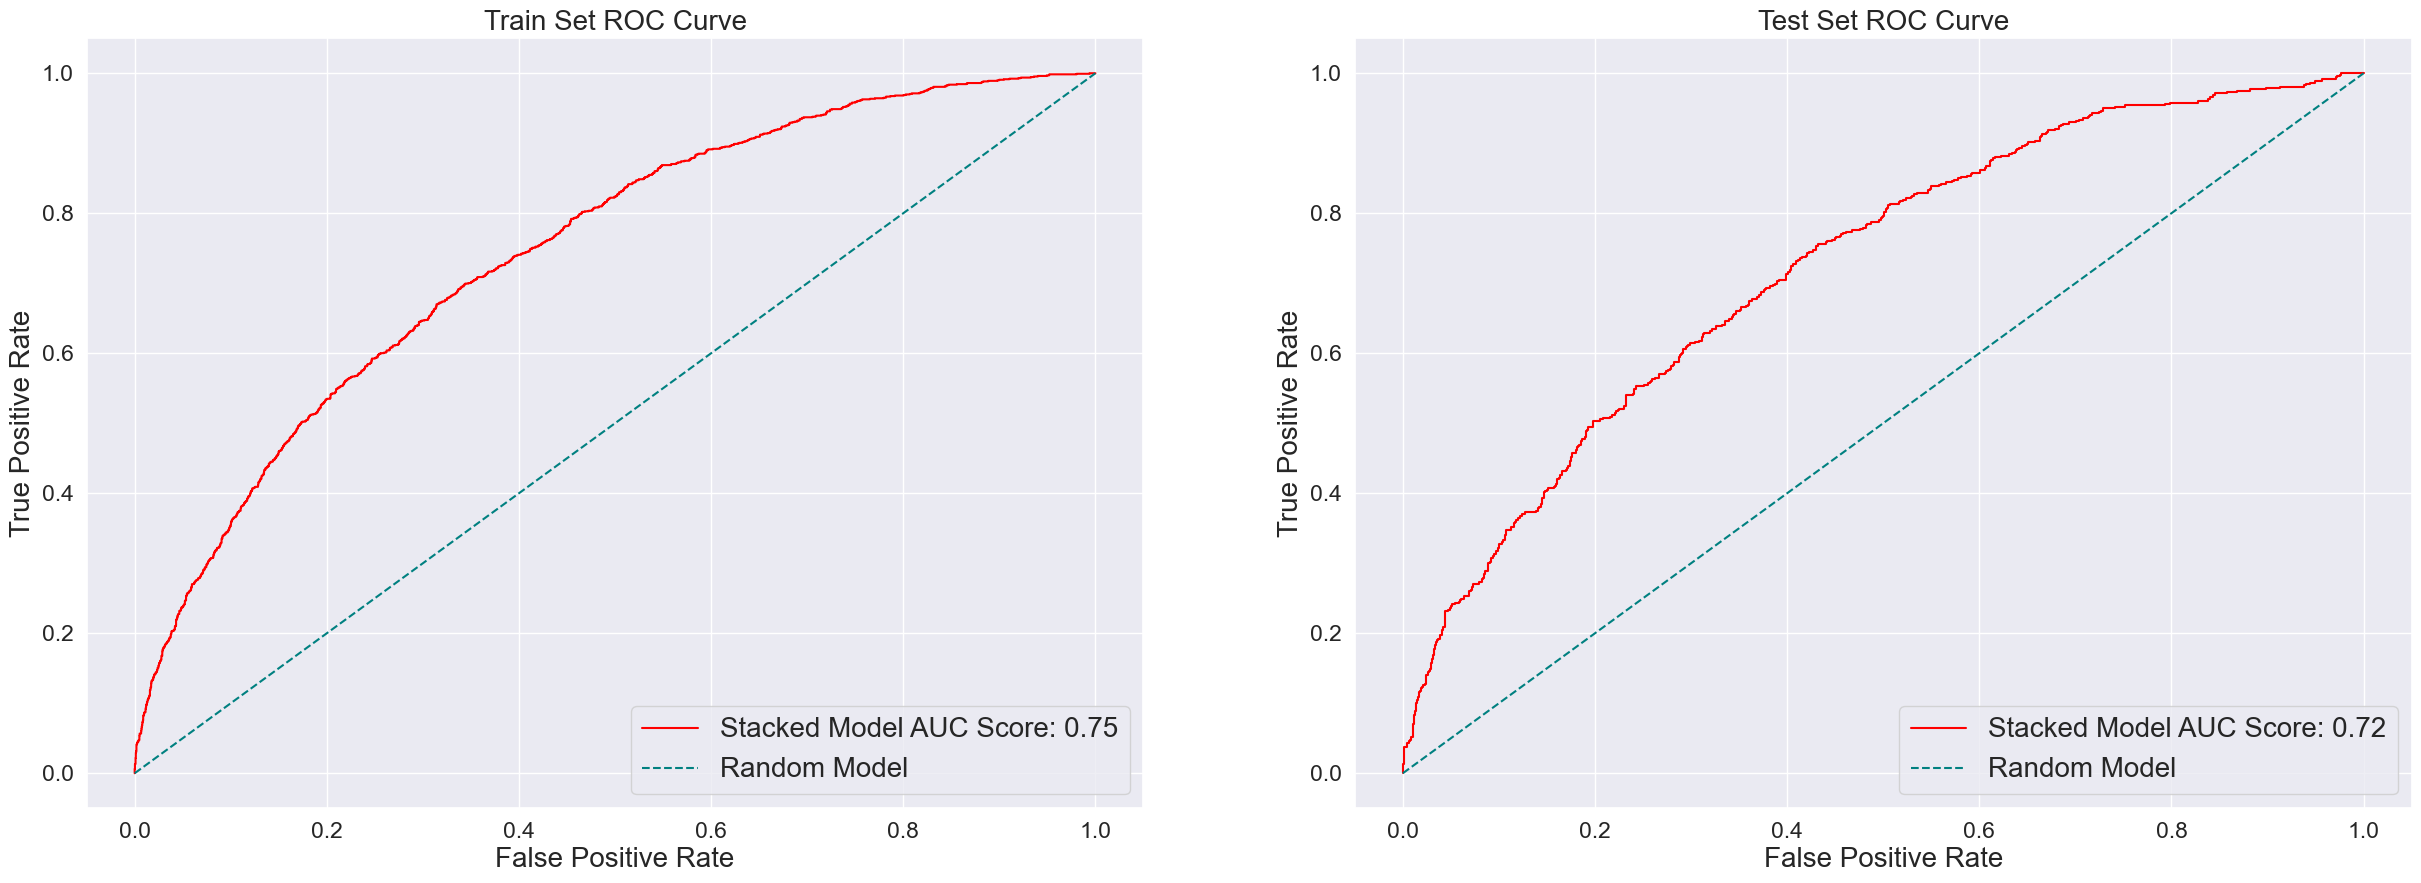

In [87]:
# Calling the function to plot ROC curve
plot_roc_curve(model = stacked_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Stacked")

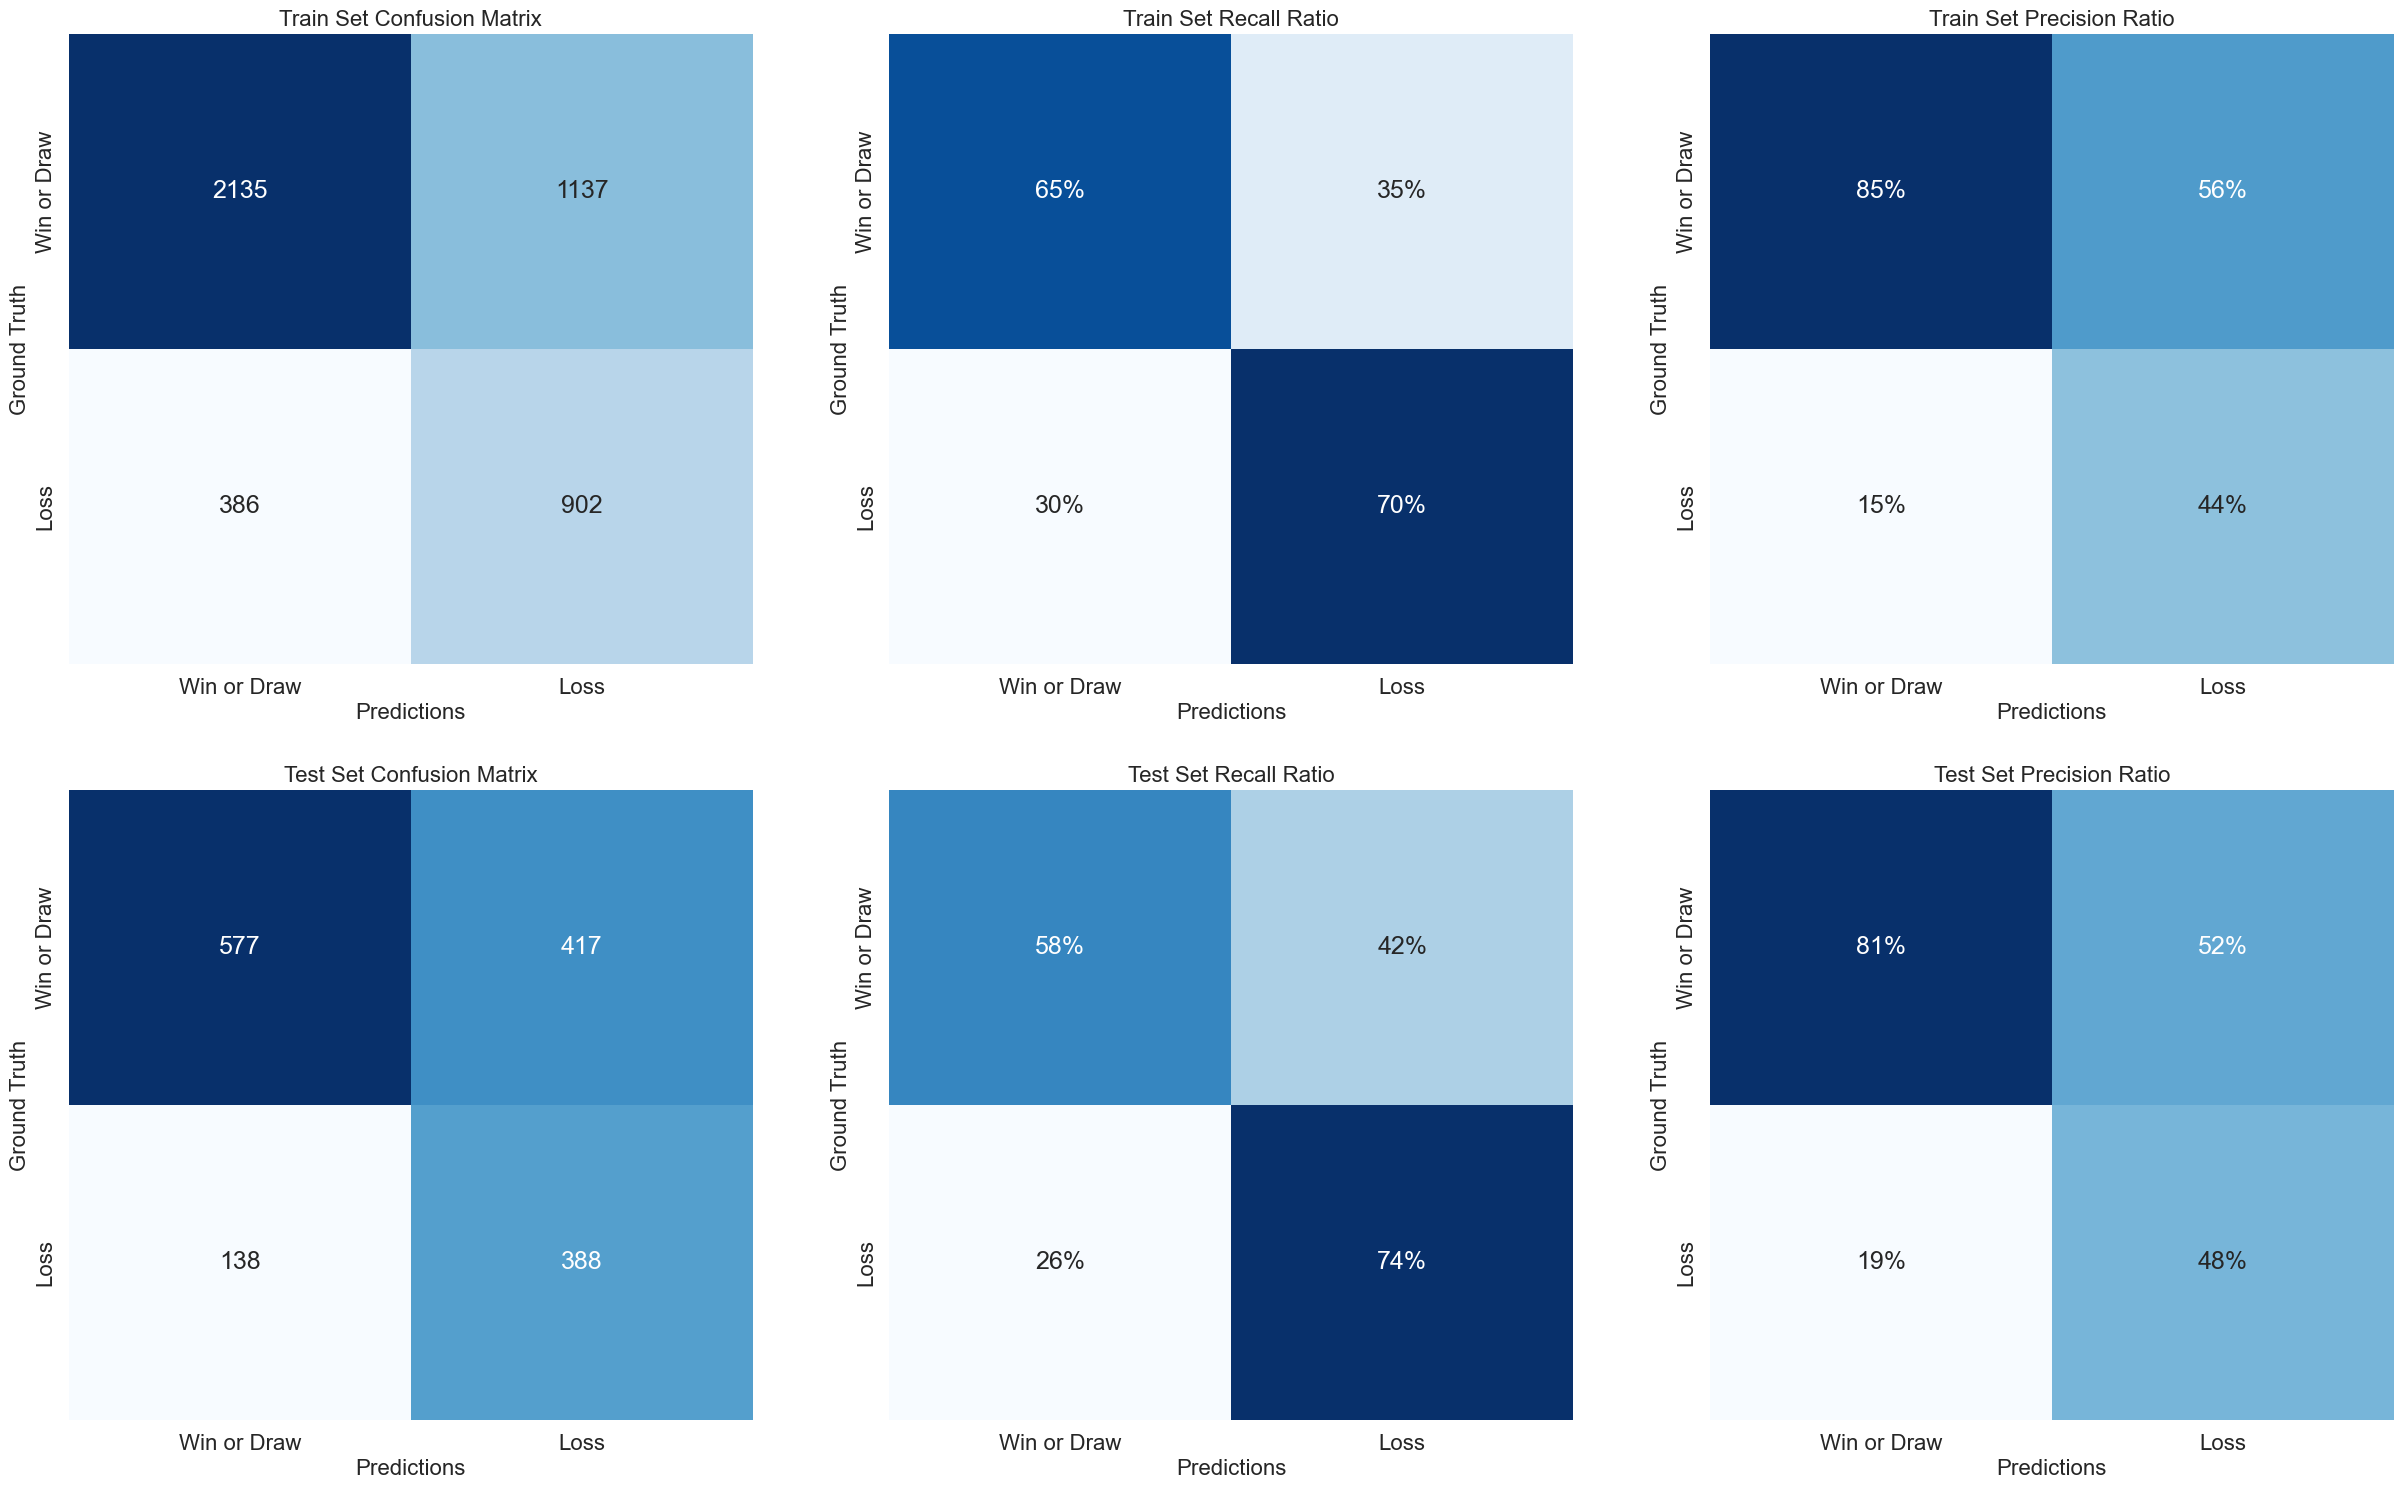

In [88]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = stacked_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [89]:
# Calling the function to evaluate the performance of the classifier
stacked_model_summary_df = evaluate_model_performance(model = stacked_model, 
                                                      train_features = X_train, 
                                                      train_labels = y_train, 
                                                      test_features = X_test, 
                                                      test_labels = y_test,
                                                      algorithm_name = "Stacked",
                                                      train_threshold = train_threshold,
                                                      test_threshold = test_threshold)
# Displaying the architecture of the classifier
stacked_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  Test Balanced Accuracy  \
Stacked       0.75      0.72                     0.68                    0.66   

         Accuracy  Precision  Recall    F1  MCC  Brier Loss  N Features  \
Stacked      0.63       0.48    0.74  0.58  0.3         0.2         235   

                                                  Pipeline  
Stacked  StackingClassifier(estimators=[('Logistic Regr...

***
### Voting

In [90]:
# Creating an estimator of voting classifier
voting_model = VotingClassifier(estimators = models, 
                                voting = 'soft',
                                n_jobs = -1)

# Logging information to the log file
logging.info(msg = "Voting model has been built")

# Fitting the train features and labels
voting_model.fit(X = X_train, y = y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              Pipeline(steps=[('initial_preprocessor',
                                               InitialPreprocessor()),
                                              ('feature_transformer',
                                               ColumnTransformer(n_jobs=-1,
                                                                 remainder='passthrough',
                                                                 transformers=[('nominal_pipeline',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['derby_na...
                                                                                 'total_avg_goals_scored_last_5_a',
                                                                                 'total_goals_conceded_h',
                                                                                 'total_goals_conceded_a', ...])])),
                                              ('feature_selector',
                                               SelectPercentile(percentile=90)),
                                              ('classifier',
                                               MLPClassifier(alpha=0.1,
                                                             early_stopping=True,
                                                             learning_rate='adaptive',
                                                             learning_rate_init=0.03552197786623699,
                                                             max_iter=1000,
                                                             n_iter_no_change=3,
                                                             shuffle=False,
                                                             tol=1e-08))]))],
                 n_jobs=-1, voting='soft')

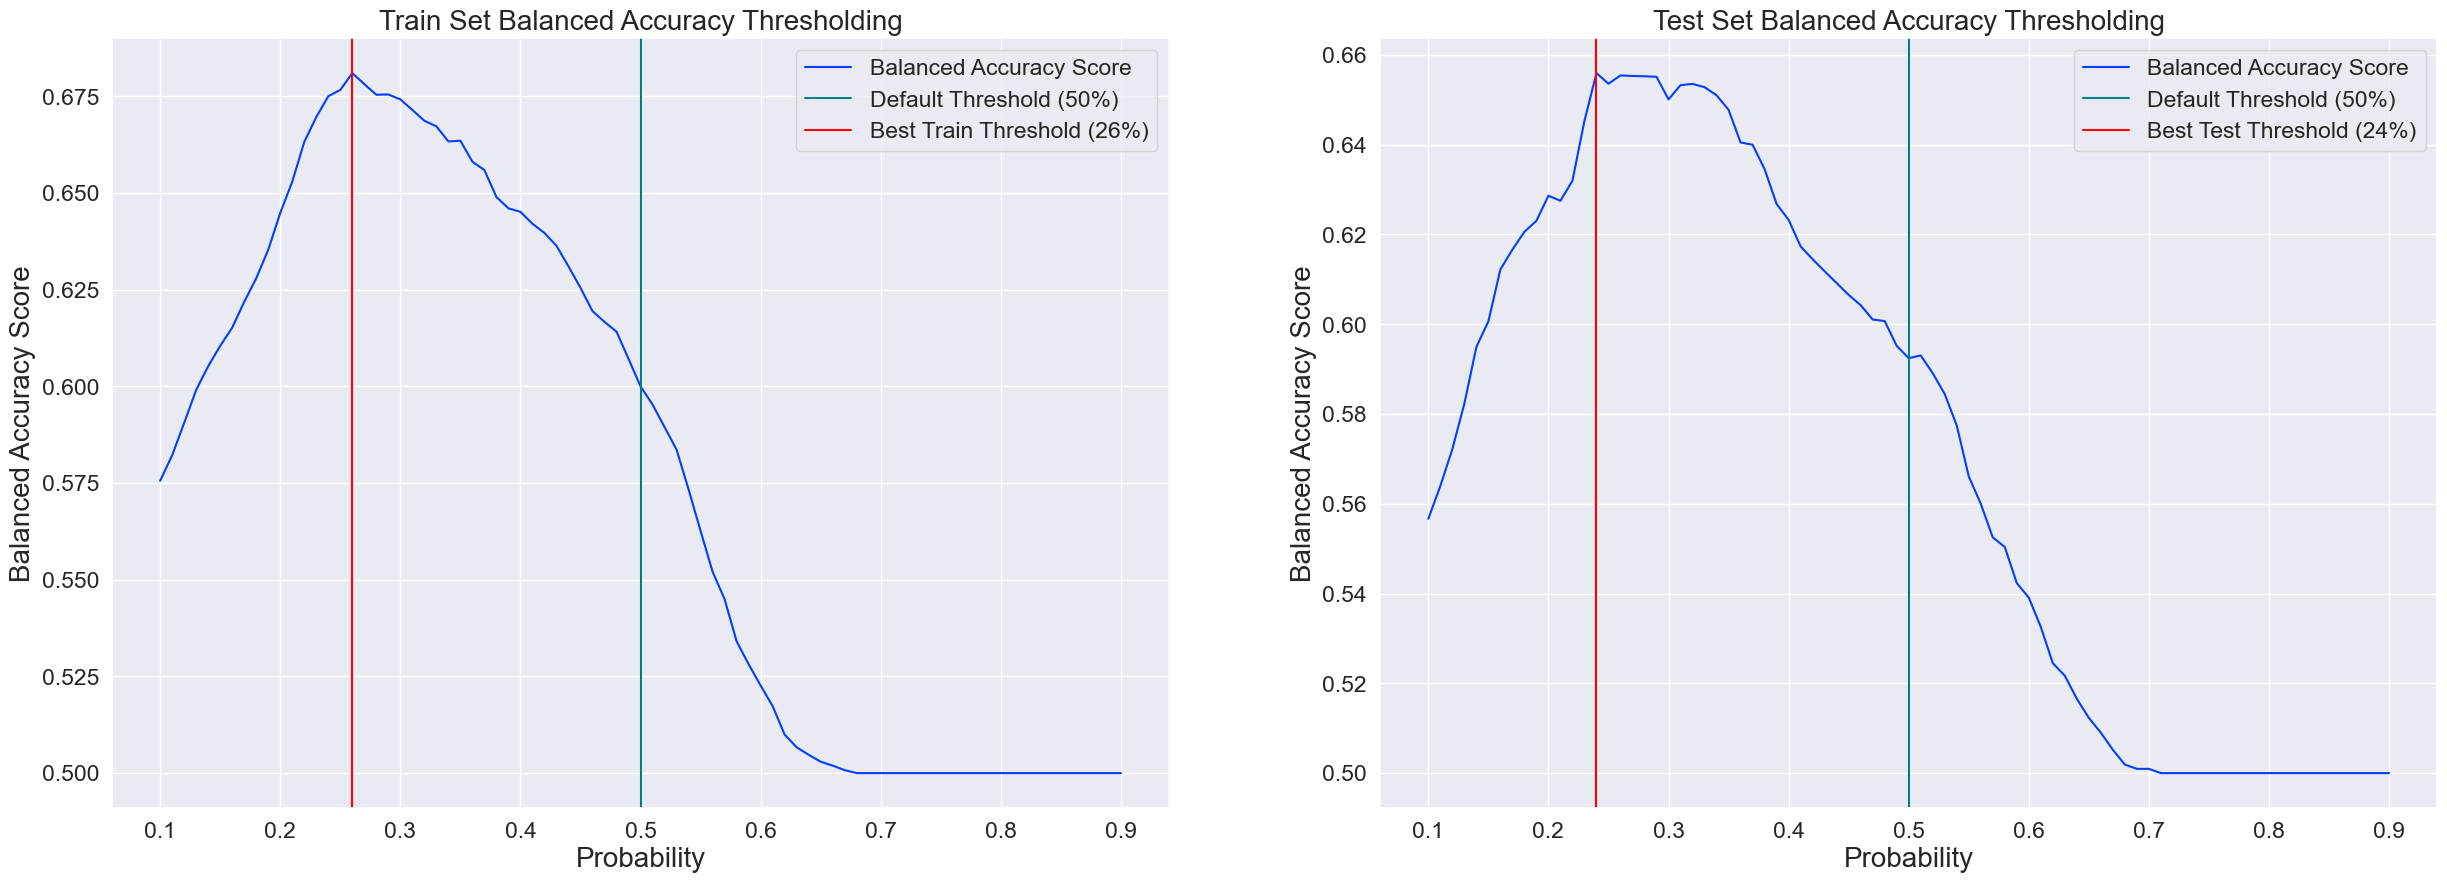

In [91]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = voting_model, 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [92]:
# Calling the function to print out the classification report
print_classification_report(model = voting_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            train_threshold = train_threshold,
                            test_threshold = test_threshold,
                            class_labels = ["Win or Draw", "Loss"],
                            algorithm_name = "Voting")

Classification Report Summary for Voting Model:

Train report:
              precision    recall  f1-score   support

 Win or Draw       0.85      0.64      0.73      3272
        Loss       0.44      0.72      0.55      1288

    accuracy                           0.66      4560
   macro avg       0.65      0.68      0.64      4560
weighted avg       0.74      0.66      0.68      4560



Test report:
              precision    recall  f1-score   support

 Win or Draw       0.83      0.50      0.63       994
        Loss       0.46      0.81      0.59       526

    accuracy                           0.61      1520
   macro avg       0.65      0.66      0.61      1520
weighted avg       0.70      0.61      0.61      1520



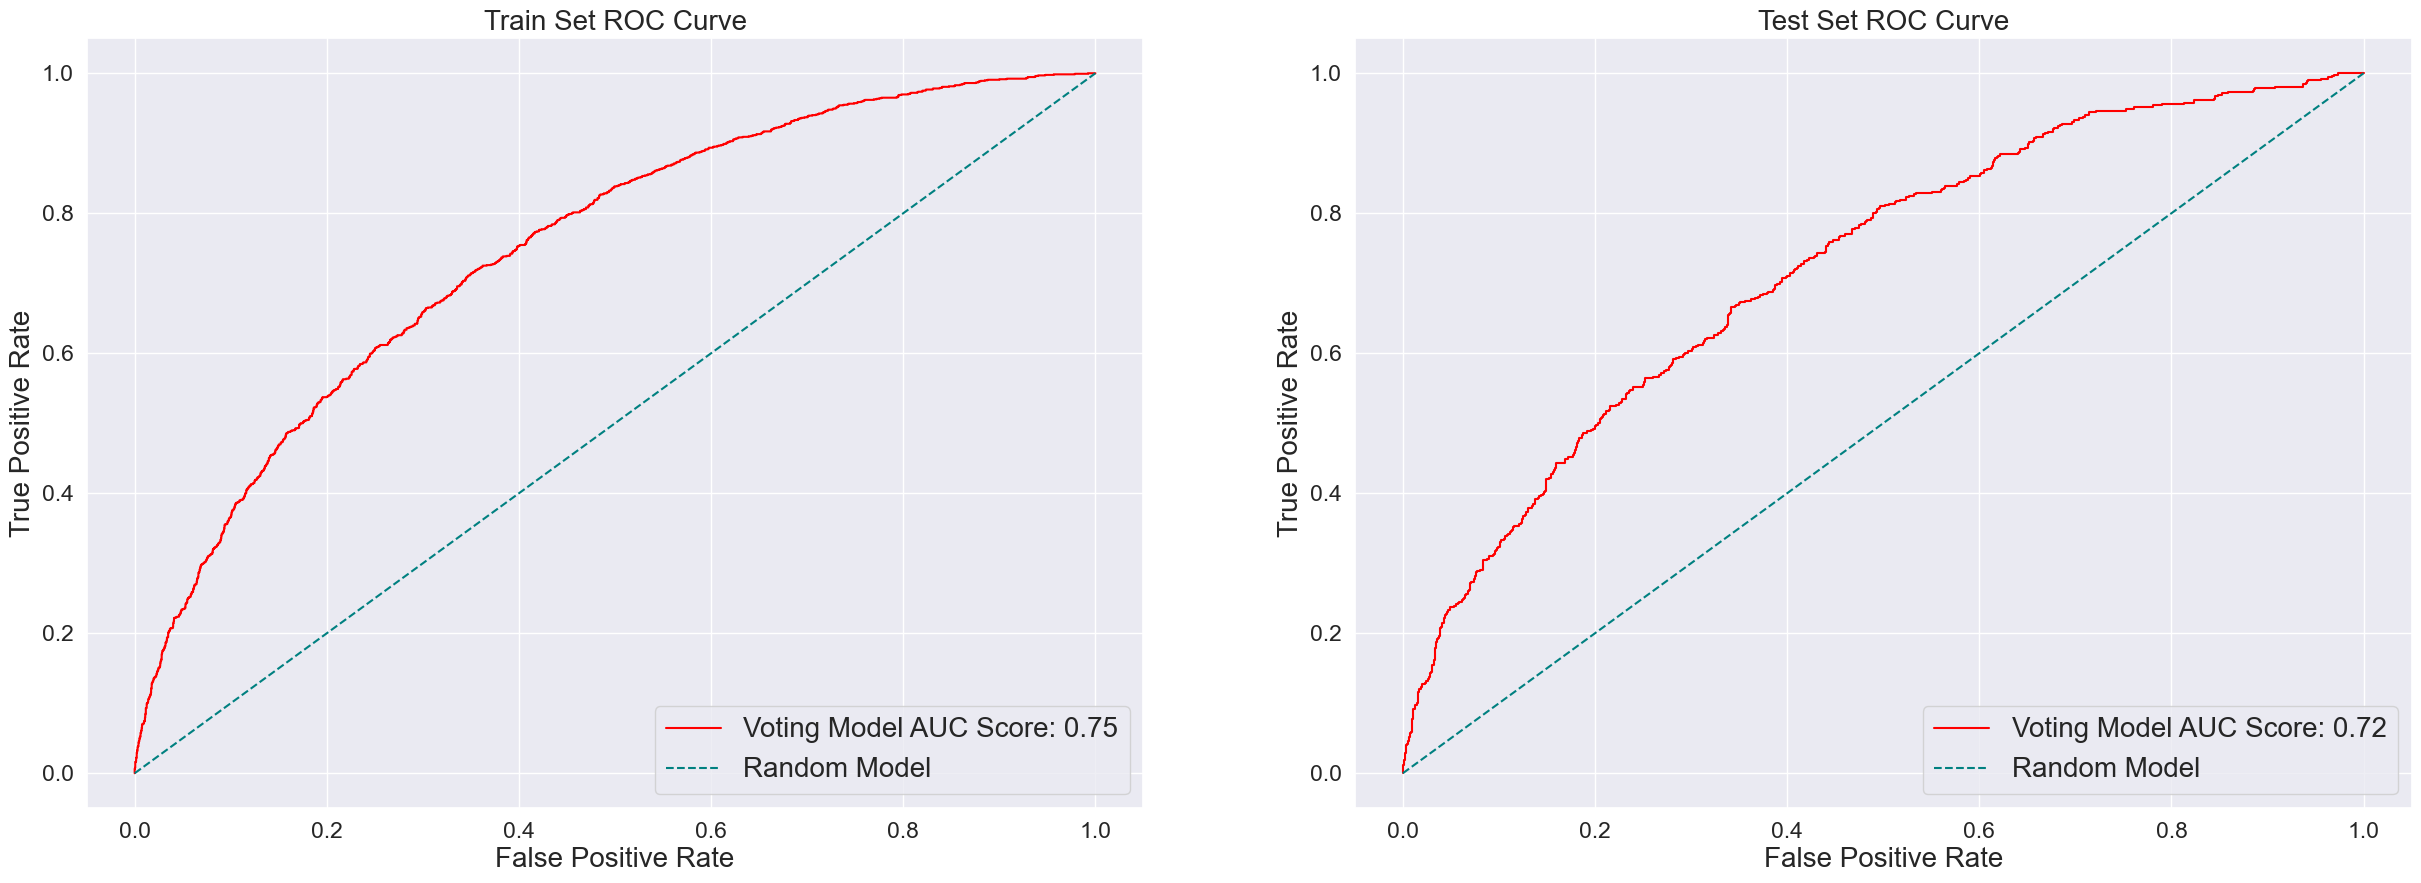

In [93]:
# Calling the function to plot ROC curve
plot_roc_curve(model = voting_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = "Voting")

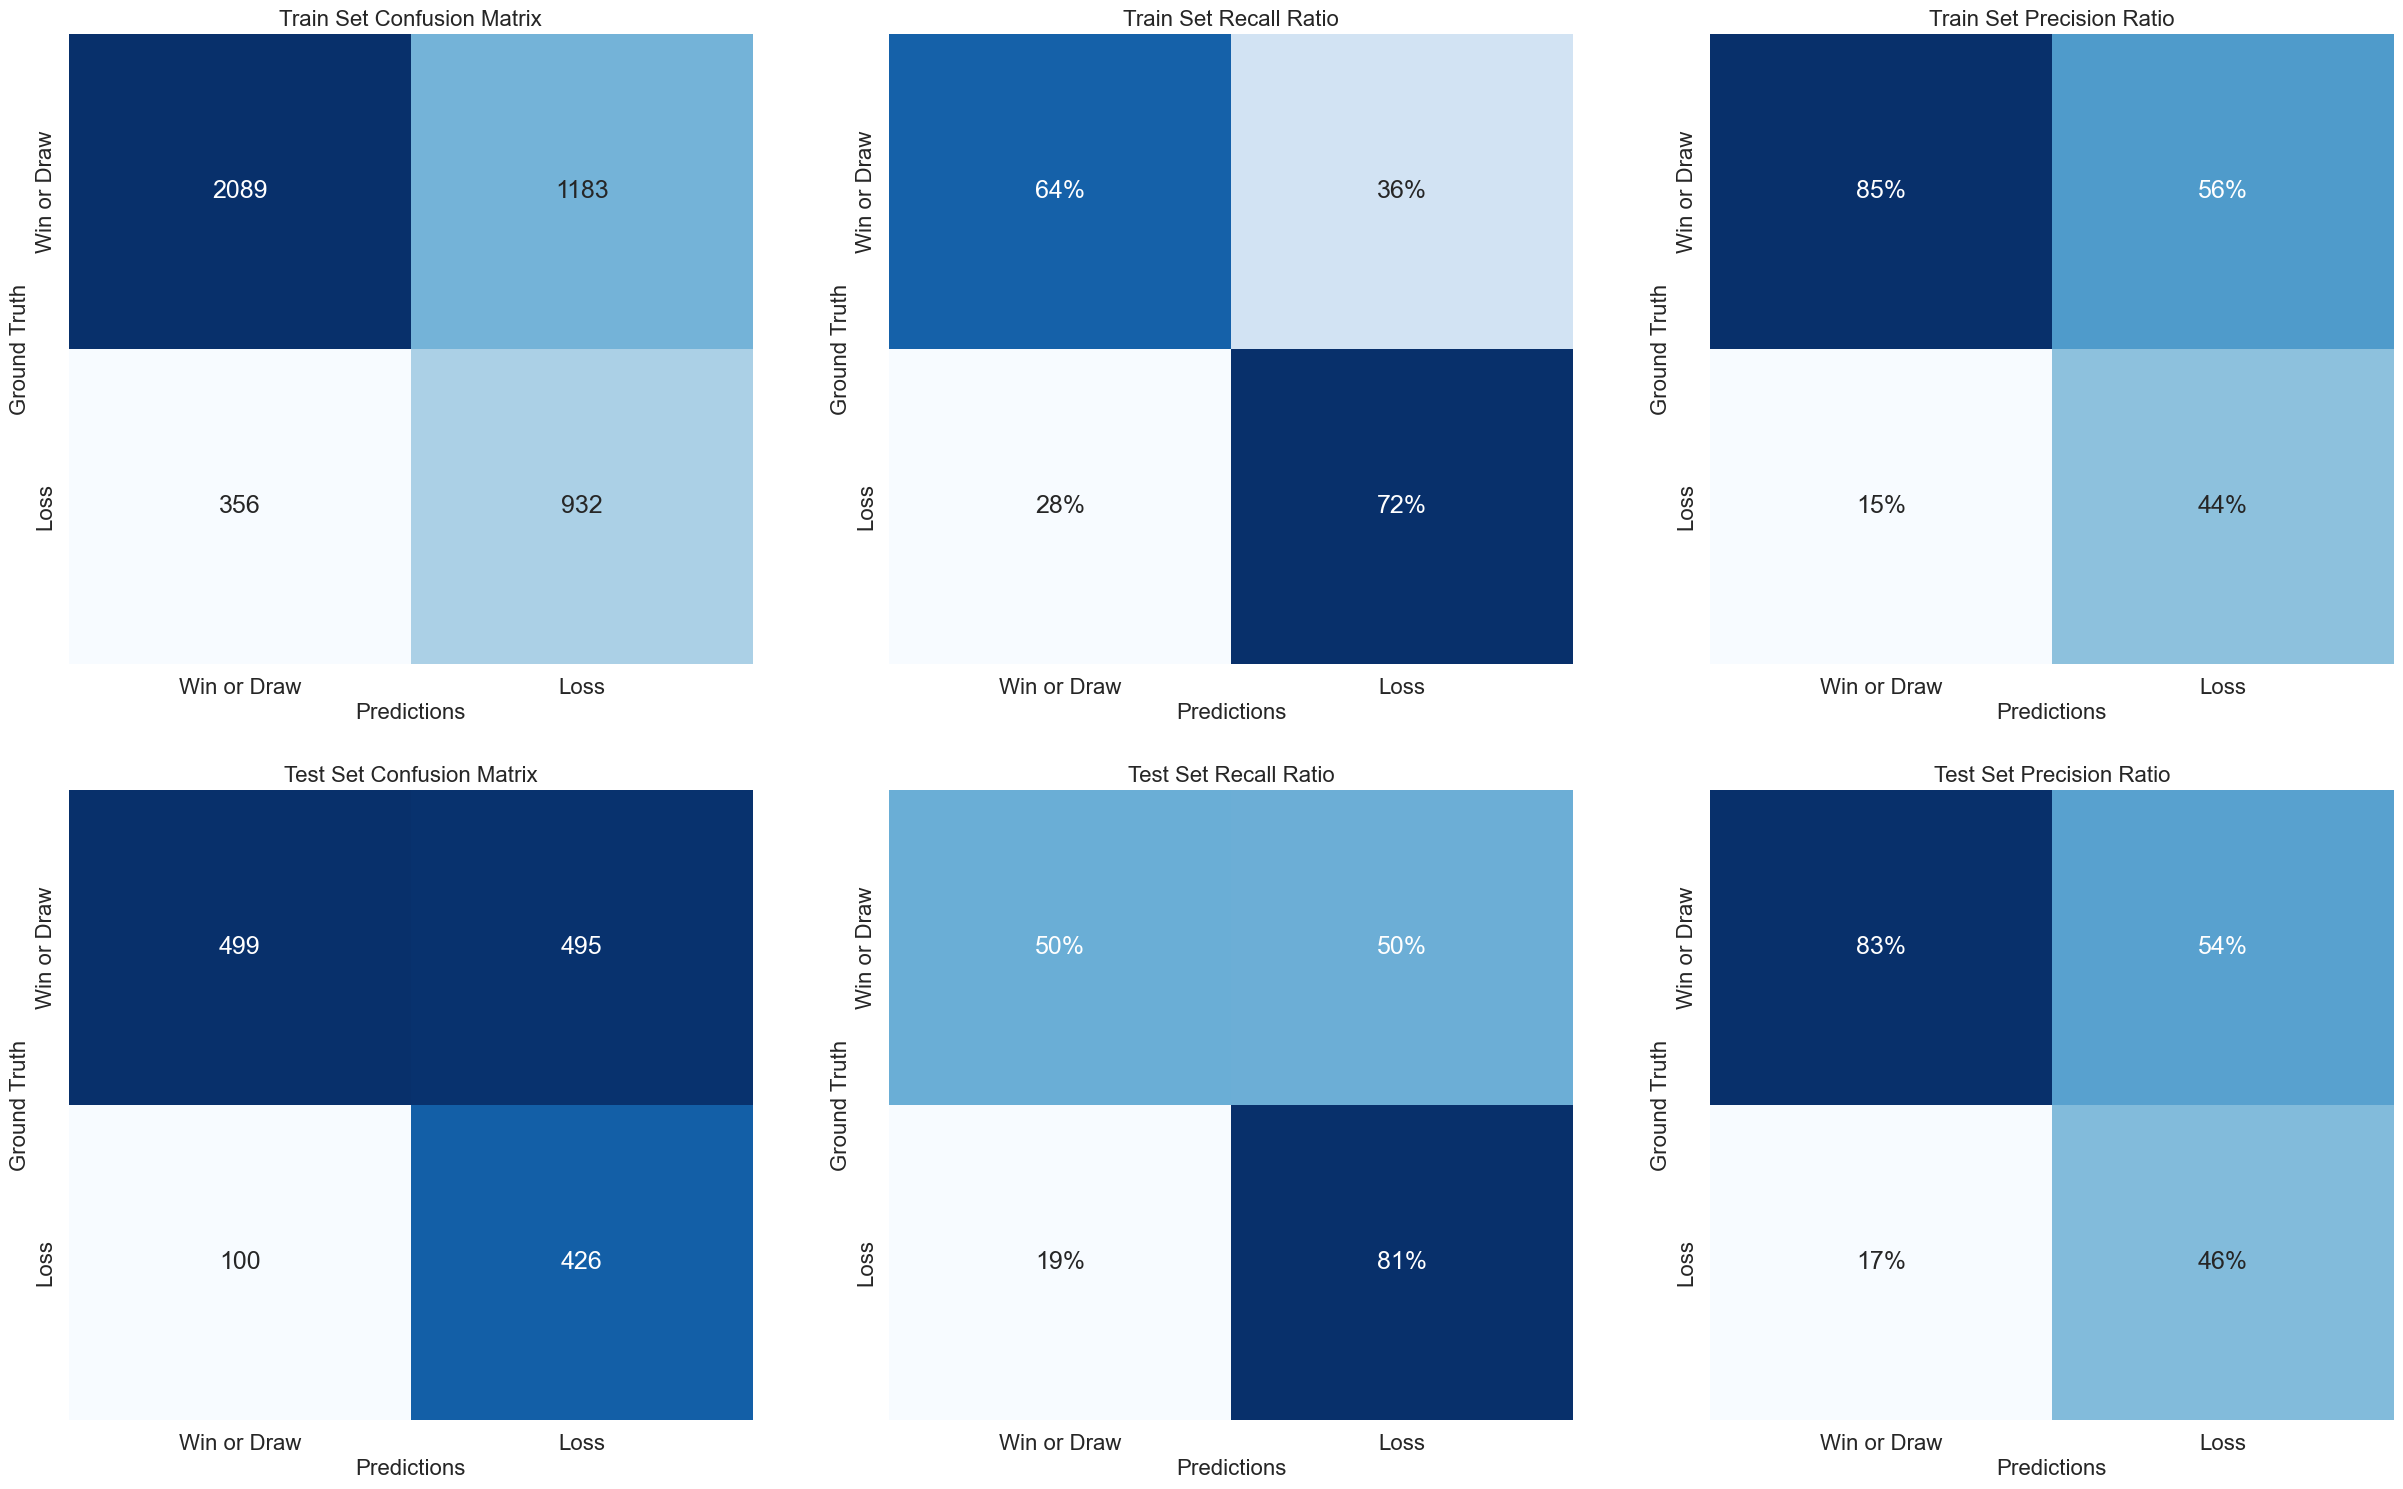

In [94]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = voting_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test,
                      train_threshold = train_threshold,
                      test_threshold = test_threshold,
                      class_labels = ["Win or Draw", "Loss"])

In [95]:
# Calling the function to evaluate the performance of the classifier
voting_model_summary_df = evaluate_model_performance(model = voting_model, 
                                                     train_features = X_train, 
                                                     train_labels = y_train, 
                                                     test_features = X_test, 
                                                     test_labels = y_test,
                                                     algorithm_name = "Voting",
                                                     train_threshold = train_threshold,
                                                     test_threshold = test_threshold)
# Displaying the architecture of the classifier
voting_model_summary_df

Train AUC  Test AUC  Train Balanced Accuracy  Test Balanced Accuracy  \
Voting       0.75      0.72                     0.68                    0.66   

        Accuracy  Precision  Recall    F1  MCC  Brier Loss  N Features  \
Voting      0.61       0.46    0.81  0.59  0.3         0.2         235   

                                                 Pipeline  
Voting  VotingClassifier(estimators=[('Logistic Regres...

***
### Model Selection

Let"s concatenate the evaluation metrics summary for the models in a Pandas data frame.

In [96]:
# Concatenating the evaluation metrics summary for the models in a Pandas DataFrame
models_summary_df = pd.concat(objs = [baseline_model_summary_df, gnb_model_summary_df, lr_model_summary_df, svm_model_summary_df, 
                                      knn_model_summary_df, mlp_model_summary_df, dt_model_summary_df, rf_model_summary_df, 
                                      lgbm_model_summary_df, ada_model_summary_df, gbm_model_summary_df, xgbm_model_summary_df, 
                                      catb_model_summary_df, stacked_model_summary_df, voting_model_summary_df])

# Sorting the models based on a specified metric in descending order 
models_summary_df.sort_values(by = ["Test AUC", "Test Balanced Accuracy", "F1"], ascending = False, inplace = True)

# Saving the model selection summary for Loss Modeling to a csv file
models_summary_df.to_csv(path_or_buf = "/Users/kzeynalzade/Documents/EPL Redevelopment/epl_engine/Data/Summary/loss_models_summary.csv", index_label = "Algorithm")

# Displaying the model selection summary for Loss Modeling
models_summary_df

Train AUC  Test AUC  \
Voting                                 0.75      0.72   
Logistic Regression                    0.75      0.72   
Multi Layer Perceptron                 0.74      0.72   
Stacked                                0.75      0.72   
Light Gradient Boosted Machine         0.76      0.71   
Gaussian Naïve Bayes                   0.73      0.71   
Random Forest                          0.83      0.71   
Category Boosting                      0.98      0.71   
Extreme Gradient Boosted Machine       0.80      0.71   
Adaptive Boosting                      0.75      0.71   
Gradient Boosted Machine               0.84      0.71   
Support Vector Machine                 0.70      0.67   
Decision Tree                          0.72      0.67   
K Nearest Neighbors                    1.00      0.64   
Baseline                               0.50      0.50   

                                  Train Balanced Accuracy  \
Voting                                               0.68   
Logistic Regression                                  0.68   
Multi Layer Perceptron                               0.67   
Stacked                                              0.68   
Light Gradient Boosted Machine                       0.70   
Gaussian Naïve Bayes                                 0.66   
Random Forest                                        0.76   
Category Boosting                                    0.93   
Extreme Gradient Boosted Machine                     0.73   
Adaptive Boosting                                    0.68   
Gradient Boosted Machine                             0.59   
Support Vector Machine                               0.66   
Decision Tree                                        0.65   
K Nearest Neighbors                                  1.00   
Baseline                                             0.50   

                                  Test Balanced Accuracy  Accuracy  Precision  \
Voting                                              0.66      0.61       0.46   
Logistic Regression                                 0.66      0.65       0.49   
Multi Layer Perceptron                              0.66      0.66       0.51   
Stacked                                             0.66      0.63       0.48   
Light Gradient Boosted Machine                      0.65      0.61       0.46   
Gaussian Naïve Bayes                                0.65      0.64       0.49   
Random Forest                                       0.65      0.67       0.52   
Category Boosting                                   0.65      0.68       0.53   
Extreme Gradient Boosted Machine                    0.64      0.62       0.47   
Adaptive Boosting                                   0.64      0.68       0.54   
Gradient Boosted Machine                            0.55      0.42       0.37   
Support Vector Machine                              0.64      0.68       0.55   
Decision Tree                                       0.63      0.70       0.59   
K Nearest Neighbors                                 0.60      0.62       0.46   
Baseline                                            0.50      0.35       0.35   

                                  Recall    F1   MCC  Brier Loss  N Features  \
Voting                              0.81  0.59  0.30        0.20         235   
Logistic Regression                 0.72  0.58  0.31        0.20         274   
Multi Layer Perceptron              0.66  0.58  0.30        0.20         274   
Stacked                             0.74  0.58  0.30        0.20         235   
Light Gradient Boosted Machine      0.77  0.58  0.29        0.20         156   
Gaussian Naïve Bayes                0.67  0.57  0.28        0.32          92   
Random Forest                       0.59  0.55  0.29        0.20         145   
Category Boosting                   0.55  0.54  0.29        0.20         126   
Extreme Gradient Boosted Machine    0.72  0.57  0.28        0.20         153   
Adaptive Boosting                   0.51  0.52 